In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class GenerateC(nn.Module):
    def __init__(self):
        super(GenerateC, self).__init__()
        
    def forward(self, x):
        mean = x[:, :128]  
#         print("mean:" , mean.shape)
        log_sigma = x[:, 128:]
#         print("logsigma:", log_sigma.shape)
        stddev = torch.exp(log_sigma)
#         print("stdev shape:",stddev.shape)
        epsilon = torch.randn(mean.shape[0], mean.shape[1], device=mean.device)
#         print("epsilon shape:",epsilon.shape)
        c = stddev * epsilon + mean
        return c

class ConditionalAugmentation(nn.Module):
    def __init__(self):
        super(ConditionalAugmentation, self).__init__()
        self.fc = nn.Linear(768, 256)  # Adjusted to 768 input and 256 output
        self.lrelu = nn.LeakyReLU(0.2)
        
    def forward(self, x):
        x = self.fc(x)
        x = self.lrelu(x)
        return x

class EmbeddingCompressor(nn.Module):
    def __init__(self):
        super(EmbeddingCompressor, self).__init__()
        self.fc = nn.Linear(768, 256)  # Adjusted to 768 input and 256 output
        self.relu = nn.ReLU()
        
    def forward(self, x):
        x = self.fc(x)
        x = self.relu(x)
        return x

class Stage1Generator(nn.Module):
    def __init__(self):
        super(Stage1Generator, self).__init__()
        self.fc1 = nn.Linear(768, 256)  # Adjusted to 768 input and 256 output
        self.lrelu = nn.LeakyReLU(0.2)
        self.generate_c = GenerateC()
        
        self.fc2 = nn.Linear(128 + 100, 128 * 8 * 4 * 4)  # Adjusted to 256 + 100
        self.relu = nn.ReLU()
        self.reshape = nn.Unflatten(1, (128 * 8, 4, 4))
        
        self.upconv1 = nn.Sequential(
            nn.Upsample(scale_factor=2),
            nn.Conv2d(128 * 8, 512, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU()
        )
        
        self.upconv2 = nn.Sequential(
            nn.Upsample(scale_factor=2),
            nn.Conv2d(512, 256, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU()
        )
        
        self.upconv3 = nn.Sequential(
            nn.Upsample(scale_factor=2),
            nn.Conv2d(256, 128, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU()
        )
        
        self.upconv4 = nn.Sequential(
            nn.Upsample(scale_factor=2),
            nn.Conv2d(128, 64, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )
        
        self.final_conv = nn.Conv2d(64, 3, kernel_size=3, padding=1, bias=False)
        self.tanh = nn.Tanh()
        
    def forward(self, x1, x2):
        x1= x1.squeeze(1)
        x1=self.fc1(x1)
        mean_logsigma = self.lrelu(x1)
#         print("mean_logsigma shape:", mean_logsigma.shape)
        c = self.generate_c(mean_logsigma)
#         print("c shape",c.shape)
        gen_input = torch.cat([c, x2], dim=1)
#         print("shape after concatenate:", gen_input.shape)
        
        x = self.fc2(gen_input)
        x = self.relu(x)
        x = self.reshape(x)
        
        x = self.upconv1(x)
        x = self.upconv2(x)
        x = self.upconv3(x)
        x = self.upconv4(x)
        x = self.final_conv(x)
        x = self.tanh(x)
        
        return x, mean_logsigma

class Stage1Discriminator(nn.Module):
    def __init__(self):
        super(Stage1Discriminator, self).__init__()
        
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1, bias=False),
            nn.LeakyReLU(0.2)
        )
        
        self.conv2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2)
        )
        
        self.conv3 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2)
        )
        
        self.conv4 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2)
        )
        
        self.conv5 = nn.Conv2d(512, 64 * 8, kernel_size=1, stride=1)
        self.batch_norm = nn.BatchNorm2d(64 * 8)
        self.leaky_relu = nn.LeakyReLU(0.2)
        
        self.fc_embedding = nn.Linear(768, 512 * 4 * 4)
        
        self.conv5_convert = nn.Conv2d(in_channels=1024, out_channels=512, kernel_size=1, stride=1, padding=0)
        
        self.flatten = nn.Flatten()
        self.fc = nn.Linear(4 * 4 * 64 * 8, 1)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x1, x2):
#         x1 is the image (generated or real one) x 2 is the text embedding
        x = self.conv1(x1)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x2 = self.fc_embedding(x2)  # [batch_size, 512 * 4 * 4]
        x2 = x2.view(x2.size(0), 512, 4, 4)
#         print(x2.shape) 

        x2 = torch.cat([x, x2], dim=1)
        
        x2= self.conv5_convert(x2)
        x2 = self.conv5(x2)
        x2 = self.batch_norm(x2)
        x2 = self.leaky_relu(x2)
        x2 = self.flatten(x2)
        x2 = self.fc(x2)
        x2 = self.sigmoid(x2)
        
        return x2

class AdversarialModel(nn.Module):
    def __init__(self, gen_model, dis_model):
        super(AdversarialModel, self).__init__()
        self.gen_model = gen_model
        self.dis_model = dis_model
        
    def forward(self, x1, x2, x3):
        x, mean_logsigma = self.gen_model(x1, x2)
        self.dis_model.eval()
        valid = self.dis_model(x, x3)
        return valid, mean_logsigma


In [2]:
def KL_loss(y_pred):
    # Extract mean and log_sigma from y_pred
    mean = y_pred[:, :128]
    log_sigma = y_pred[:, 128:]
    
    # Compute the KL divergence loss
    loss = -log_sigma + 0.5 * (-1 + torch.exp(2. * log_sigma) + mean**2)
    
    # Average the loss over all elements
    loss = loss.mean()
    
    return loss

def custom_generator_loss(y_true, y_pred):
    # Create loss function
    criterion = nn.BCEWithLogitsLoss()
    
    # Calculate binary cross-entropy loss
    return criterion(y_pred, y_true)

In [3]:
import matplotlib.pyplot as plt
import numpy as np

def save_rgb_img(img, path):
    """
    Save an RGB image.
    Args:
        img (numpy.ndarray): Image to save. Shape should be (H, W, C).
        path (str): Path to save the image.
    """
    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)
    
    # Convert PyTorch tensor to numpy array if necessary
    if isinstance(img, torch.Tensor):
        img = img.detach().permute(1, 2, 0).cpu().numpy()  # Convert CHW to HWC and move to CPU
    
    ax.imshow(img)
    ax.axis("off")
    ax.set_title("Image")

    plt.savefig(path)
    plt.close()
    


In [4]:
from torch.utils.tensorboard import SummaryWriter

def write_log(writer, name, loss, global_step):
    """
    Write training summary to TensorBoard.
    Args:
        writer (SummaryWriter): TensorBoard writer object.
        name (str): The name of the summary.
        loss (float): The loss value to log.
        global_step (int): The global step value.
    """
    writer.add_scalar(name, loss, global_step)

In [5]:
# Discriminator loss
def wasserstein_discriminator_loss(real_preds, fake_preds):
    return torch.mean(fake_preds) - torch.mean(real_preds)

# Generator loss
def wasserstein_generator_loss(fake_preds):
    return -torch.mean(fake_preds)



In [6]:
import torch
from torch import autograd

def compute_gradient_penalty(dis_model, real_samples, fake_samples, embeddings):
    """
    Computes the gradient penalty for WGAN-GP.

    Args:
        dis_model (torch.nn.Module): The discriminator model.
        real_samples (torch.Tensor): Batch of real images.
        fake_samples (torch.Tensor): Batch of generated (fake) images.
        device (torch.device): The device (CPU or GPU) to perform calculations.

    Returns:
        torch.Tensor: The gradient penalty value.
    """
    # Get the batch size from real samples
    batch_size = real_samples.size(0)

    # Create random interpolation factor
    alpha = torch.rand(batch_size, 1, 1, 1).to(device)
    
    # Create interpolated samples
    interpolates = (alpha * real_samples + (1 - alpha) * fake_samples).requires_grad_(True)

    # Pass interpolated samples through the discriminator
    d_interpolates = dis_model(interpolates , embeddings)

    # Create gradients with respect to the interpolated samples
    gradients = autograd.grad(
        outputs=d_interpolates,
        inputs=interpolates,
        grad_outputs=torch.ones_like(d_interpolates),
        create_graph=True,
        retain_graph=True,
        only_inputs=True
    )[0]

    # Flatten the gradients and compute the gradient penalty
    gradients = gradients.view(gradients.size(0), -1)
    gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean()

    return gradient_penalty


In [12]:
def plot_generated_images(images, epoch, n_images=8):
    """
    Plot generated images in a grid.
    
    Args:
        images (Tensor): A batch of generated images (batch_size, 3, 64, 64).
        epoch (int): Current epoch for title.
        n_images (int): Number of images to plot. Default is 8.
    """
    fig, axes = plt.subplots(1, n_images, figsize=(n_images * 2, 2))  # Set up the figure and axes
    for i in range(n_images):
        ax = axes[i]
        img = images[i].detach().permute(1, 2, 0).cpu().numpy()  # Convert CHW to HWC and move to CPU
        ax.imshow(img)
        ax.axis("off")  # Turn off axis
    plt.suptitle(f'Generated Images at Epoch {epoch}')  # Add a title
    plt.show()  # Display the plot

/tmp/ipykernel_30/3385041332.py:71: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  train_images = torch.load('/kaggle/input/qwerty-3/image_tensors.pt_2')# Load resized images

Epoch [0/240] Step [0] Discriminator Loss: 3.5460424423217773 Generator Loss: -0.8906732797622681
Epoch [0/240] Step [1600] Discriminator Loss: 0.356229692697525 Generator Loss: -0.25164464116096497
Epoch [0/240] Step [3200] Discriminator Loss: 0.820697009563446 Generator Loss: -0.09623321890830994
Epoch [0/240] Step [4800] Discriminator Loss: 0.04894110560417175 Generator Loss: -0.36905571818351746
Epoch [0/240] Step [6400] Discriminator Loss: -0.3657190799713135 Generator Loss: -0.03865328058600426


Epochs:   0%|          | 1/240 [00:29<1:59:09, 29.91s/it]

Epoch [0/240] Avg Discriminator Loss: 0.8715165225314159 Avg Generator Loss: -0.28116090891554074
Epoch [1/240] Step [0] Discriminator Loss: 5.197966575622559 Generator Loss: -0.4865948557853699
Epoch [1/240] Step [600] Discriminator Loss: -0.1149691492319107 Generator Loss: -0.28153514862060547
Epoch [1/240] Step [1200] Discriminator Loss: -0.04294900596141815 Generator Loss: -0.3534291386604309
Epoch [1/240] Step [1800] Discriminator Loss: 0.07151873409748077 Generator Loss: -0.31718793511390686
Epoch [1/240] Step [2400] Discriminator Loss: 0.5240539908409119 Generator Loss: -0.31088903546333313
Epoch [1/240] Step [3000] Discriminator Loss: 0.09884485602378845 Generator Loss: -0.31197983026504517
Epoch [1/240] Step [3600] Discriminator Loss: 0.12263398617506027 Generator Loss: -0.356777548789978
Epoch [1/240] Step [4200] Discriminator Loss: 0.5312337875366211 Generator Loss: -0.3043251633644104
Epoch [1/240] Step [4800] Discriminator Loss: 0.1299757957458496 Generator Loss: -0.491698

Epochs:   1%|          | 2/240 [01:06<2:13:21, 33.62s/it]

Epoch [1/240] Avg Discriminator Loss: 0.405985720482938 Avg Generator Loss: -0.38101112489134836
Epoch [2/240] Step [0] Discriminator Loss: 0.9890694618225098 Generator Loss: -0.9095785617828369
Epoch [2/240] Step [600] Discriminator Loss: 0.19205114245414734 Generator Loss: -0.354276180267334
Epoch [2/240] Step [1200] Discriminator Loss: 0.11831901967525482 Generator Loss: -0.4584021270275116
Epoch [2/240] Step [1800] Discriminator Loss: 0.2530577480792999 Generator Loss: -0.47754526138305664
Epoch [2/240] Step [2400] Discriminator Loss: 0.10454048216342926 Generator Loss: -0.4349641799926758
Epoch [2/240] Step [3000] Discriminator Loss: -0.26216185092926025 Generator Loss: -0.28633859753608704
Epoch [2/240] Step [3600] Discriminator Loss: 0.019784852862358093 Generator Loss: -0.4519104063510895
Epoch [2/240] Step [4200] Discriminator Loss: -0.005407512187957764 Generator Loss: -0.42500436305999756
Epoch [2/240] Step [4800] Discriminator Loss: -0.28703513741493225 Generator Loss: -0.3

Epochs:   1%|▏         | 3/240 [01:43<2:19:03, 35.20s/it]

Epoch [2/240] Avg Discriminator Loss: 0.40346639189910105 Avg Generator Loss: -0.38195339818877394
Epoch [3/240] Step [0] Discriminator Loss: -0.08558404445648193 Generator Loss: -0.20850315690040588
Epoch [3/240] Step [600] Discriminator Loss: 6.2816596031188965 Generator Loss: -0.15249787271022797
Epoch [3/240] Step [1200] Discriminator Loss: -0.032224610447883606 Generator Loss: -0.41357508301734924
Epoch [3/240] Step [1800] Discriminator Loss: 0.0866677314043045 Generator Loss: -0.46124181151390076
Epoch [3/240] Step [2400] Discriminator Loss: 0.06369495391845703 Generator Loss: -0.41700148582458496
Epoch [3/240] Step [3000] Discriminator Loss: -0.15319204330444336 Generator Loss: -0.2515229880809784
Epoch [3/240] Step [3600] Discriminator Loss: 0.07569760084152222 Generator Loss: -0.3541460931301117
Epoch [3/240] Step [4200] Discriminator Loss: -0.003417670726776123 Generator Loss: -0.3116263747215271
Epoch [3/240] Step [4800] Discriminator Loss: 0.1090017557144165 Generator Loss:

Epochs:   2%|▏         | 4/240 [02:20<2:21:34, 36.00s/it]

Epoch [3/240] Avg Discriminator Loss: 0.20164489701062768 Avg Generator Loss: -0.39052704582502556
Epoch [4/240] Step [0] Discriminator Loss: -0.11138071119785309 Generator Loss: -0.2914964258670807
Epoch [4/240] Step [600] Discriminator Loss: -0.13942775130271912 Generator Loss: -0.32406434416770935
Epoch [4/240] Step [1200] Discriminator Loss: -0.06645005941390991 Generator Loss: -0.25870874524116516
Epoch [4/240] Step [1800] Discriminator Loss: -0.0442877933382988 Generator Loss: -0.396898478269577
Epoch [4/240] Step [2400] Discriminator Loss: -0.177597776055336 Generator Loss: -0.3325045704841614
Epoch [4/240] Step [3000] Discriminator Loss: 0.04191160202026367 Generator Loss: -0.3673550486564636
Epoch [4/240] Step [3600] Discriminator Loss: 0.01412452757358551 Generator Loss: -0.4136628210544586
Epoch [4/240] Step [4200] Discriminator Loss: -0.2818114161491394 Generator Loss: -0.15566223859786987
Epoch [4/240] Step [4800] Discriminator Loss: 0.5926149487495422 Generator Loss: -0.0

Epochs:   2%|▏         | 5/240 [02:57<2:23:04, 36.53s/it]

Epoch [4/240] Avg Discriminator Loss: 0.26002744517729176 Avg Generator Loss: -0.34874960673024585
Epoch [5/240] Step [0] Discriminator Loss: -0.04852362722158432 Generator Loss: -0.4093119204044342
Epoch [5/240] Step [600] Discriminator Loss: 0.12243930995464325 Generator Loss: -0.3950914442539215
Epoch [5/240] Step [1200] Discriminator Loss: 0.37767478823661804 Generator Loss: -0.45743227005004883
Epoch [5/240] Step [1800] Discriminator Loss: 2.167487382888794 Generator Loss: -0.43849262595176697
Epoch [5/240] Step [2400] Discriminator Loss: 0.08808678388595581 Generator Loss: -0.4238200783729553
Epoch [5/240] Step [3000] Discriminator Loss: 0.4648858904838562 Generator Loss: -0.1001339852809906
Epoch [5/240] Step [3600] Discriminator Loss: -0.18628469109535217 Generator Loss: -0.23442186415195465
Epoch [5/240] Step [4200] Discriminator Loss: -0.1462242305278778 Generator Loss: -0.32337912917137146
Epoch [5/240] Step [4800] Discriminator Loss: 0.04286475479602814 Generator Loss: -0.3

Epochs:   2%|▎         | 6/240 [03:35<2:24:08, 36.96s/it]

Epoch [5/240] Avg Discriminator Loss: 0.1397255795970286 Avg Generator Loss: -0.3268894169193048
Epoch [6/240] Step [0] Discriminator Loss: -0.17899659276008606 Generator Loss: -0.3706156015396118
Epoch [6/240] Step [600] Discriminator Loss: -0.397156298160553 Generator Loss: -0.17991098761558533
Epoch [6/240] Step [1200] Discriminator Loss: 1.3754377365112305 Generator Loss: -0.9613977670669556
Epoch [6/240] Step [1800] Discriminator Loss: 0.19270524382591248 Generator Loss: -0.6223914623260498
Epoch [6/240] Step [2400] Discriminator Loss: 0.06381189823150635 Generator Loss: -0.5965891480445862
Epoch [6/240] Step [3000] Discriminator Loss: 1.1778209209442139 Generator Loss: -0.29521194100379944
Epoch [6/240] Step [3600] Discriminator Loss: -0.06822150945663452 Generator Loss: -0.40248969197273254
Epoch [6/240] Step [4200] Discriminator Loss: -0.01473015546798706 Generator Loss: -0.4766785502433777
Epoch [6/240] Step [4800] Discriminator Loss: 0.1687839776277542 Generator Loss: -0.3045

Epochs:   3%|▎         | 7/240 [04:13<2:24:49, 37.29s/it]

Epoch [6/240] Avg Discriminator Loss: 0.2197940907007827 Avg Generator Loss: -0.35850598871871664
Epoch [7/240] Step [0] Discriminator Loss: 0.6145893335342407 Generator Loss: -0.1566455066204071
Epoch [7/240] Step [600] Discriminator Loss: -0.026924319565296173 Generator Loss: -0.3055642247200012
Epoch [7/240] Step [1200] Discriminator Loss: -0.188387930393219 Generator Loss: -0.2927704155445099
Epoch [7/240] Step [1800] Discriminator Loss: 0.14593657851219177 Generator Loss: -0.3801274299621582
Epoch [7/240] Step [2400] Discriminator Loss: 0.3759726285934448 Generator Loss: -0.5026406645774841
Epoch [7/240] Step [3000] Discriminator Loss: 1.0906059741973877 Generator Loss: -0.6194102764129639
Epoch [7/240] Step [3600] Discriminator Loss: 0.1518257111310959 Generator Loss: -0.6479348540306091
Epoch [7/240] Step [4200] Discriminator Loss: 0.04950705170631409 Generator Loss: -0.21961835026741028
Epoch [7/240] Step [4800] Discriminator Loss: 0.1199478805065155 Generator Loss: -0.35569053

Epochs:   3%|▎         | 8/240 [04:51<2:25:04, 37.52s/it]

Epoch [7/240] Avg Discriminator Loss: 0.29519258413613936 Avg Generator Loss: -0.3829947613186507
Epoch [8/240] Step [0] Discriminator Loss: -0.004928141832351685 Generator Loss: -0.4652542471885681
Epoch [8/240] Step [600] Discriminator Loss: -0.11778683960437775 Generator Loss: -0.15149928629398346
Epoch [8/240] Step [1200] Discriminator Loss: 6.911850452423096 Generator Loss: -0.7131953835487366
Epoch [8/240] Step [1800] Discriminator Loss: -0.08477585762739182 Generator Loss: -0.33105412125587463
Epoch [8/240] Step [2400] Discriminator Loss: -0.08604076504707336 Generator Loss: -0.3207298517227173
Epoch [8/240] Step [3000] Discriminator Loss: -0.3195091485977173 Generator Loss: -0.2560512125492096
Epoch [8/240] Step [3600] Discriminator Loss: 0.35714343190193176 Generator Loss: -0.4241170287132263
Epoch [8/240] Step [4200] Discriminator Loss: 0.2829307019710541 Generator Loss: -0.1855146884918213
Epoch [8/240] Step [4800] Discriminator Loss: -0.16495013236999512 Generator Loss: -0.

Epochs:   4%|▍         | 9/240 [05:30<2:25:48, 37.87s/it]

Epoch [8/240] Avg Discriminator Loss: 0.10068041558339919 Avg Generator Loss: -0.32428821984119033
Epoch [9/240] Step [0] Discriminator Loss: -0.3232252299785614 Generator Loss: -0.23853425681591034
Epoch [9/240] Step [600] Discriminator Loss: -0.23653459548950195 Generator Loss: -0.3825789988040924
Epoch [9/240] Step [1200] Discriminator Loss: -0.29619914293289185 Generator Loss: -0.28651896119117737
Epoch [9/240] Step [1800] Discriminator Loss: 0.22145438194274902 Generator Loss: -0.56914883852005
Epoch [9/240] Step [2400] Discriminator Loss: 0.23142275214195251 Generator Loss: -0.4482940435409546
Epoch [9/240] Step [3000] Discriminator Loss: 1.0325865745544434 Generator Loss: -0.17633581161499023
Epoch [9/240] Step [3600] Discriminator Loss: 0.11679673939943314 Generator Loss: -0.4580520987510681
Epoch [9/240] Step [4200] Discriminator Loss: -0.12729522585868835 Generator Loss: -0.3042873740196228
Epoch [9/240] Step [4800] Discriminator Loss: -0.43801456689834595 Generator Loss: -0.

Epochs:   4%|▍         | 10/240 [06:08<2:25:52, 38.05s/it]

Epoch [9/240] Avg Discriminator Loss: 0.2775652558566668 Avg Generator Loss: -0.37230439943640115
Epoch [10/240] Step [0] Discriminator Loss: -0.1303916871547699 Generator Loss: -0.5400640964508057
Epoch [10/240] Step [600] Discriminator Loss: -0.18751537799835205 Generator Loss: -0.20946434140205383
Epoch [10/240] Step [1200] Discriminator Loss: -0.2952384948730469 Generator Loss: -0.1339116245508194
Epoch [10/240] Step [1800] Discriminator Loss: 0.27818000316619873 Generator Loss: -0.3165743052959442
Epoch [10/240] Step [2400] Discriminator Loss: -0.22190707921981812 Generator Loss: -0.29707053303718567
Epoch [10/240] Step [3000] Discriminator Loss: 0.36225178837776184 Generator Loss: -0.16520023345947266
Epoch [10/240] Step [3600] Discriminator Loss: 3.68530535697937 Generator Loss: -0.49628373980522156
Epoch [10/240] Step [4200] Discriminator Loss: -0.30324211716651917 Generator Loss: -0.2411040961742401
Epoch [10/240] Step [4800] Discriminator Loss: 0.23678702116012573 Generator L

Epochs:   5%|▍         | 11/240 [06:47<2:25:39, 38.16s/it]

Epoch [10/240] Avg Discriminator Loss: 0.007646749430632854 Avg Generator Loss: -0.2823864720870942
Epoch [11/240] Step [0] Discriminator Loss: 0.3211991786956787 Generator Loss: -0.5477399826049805
Epoch [11/240] Step [600] Discriminator Loss: -0.23638856410980225 Generator Loss: -0.3638392984867096
Epoch [11/240] Step [1200] Discriminator Loss: -0.19376340508460999 Generator Loss: -0.09878335893154144
Epoch [11/240] Step [1800] Discriminator Loss: -0.08708760142326355 Generator Loss: -0.021054426208138466
Epoch [11/240] Step [2400] Discriminator Loss: 0.0012344717979431152 Generator Loss: -0.24929234385490417
Epoch [11/240] Step [3000] Discriminator Loss: 0.2025059461593628 Generator Loss: -0.36460477113723755
Epoch [11/240] Step [3600] Discriminator Loss: -0.27388685941696167 Generator Loss: -0.308223694562912
Epoch [11/240] Step [4200] Discriminator Loss: -0.41107332706451416 Generator Loss: -0.14676302671432495
Epoch [11/240] Step [4800] Discriminator Loss: -0.0687815248966217 Gen

Epochs:   5%|▌         | 12/240 [07:25<2:25:25, 38.27s/it]

Epoch [11/240] Avg Discriminator Loss: -0.024074540633858343 Avg Generator Loss: -0.2535854727916774
Epoch [12/240] Step [0] Discriminator Loss: -0.31385692954063416 Generator Loss: -0.22347895801067352
Epoch [12/240] Step [600] Discriminator Loss: 0.8500460982322693 Generator Loss: -0.25362101197242737
Epoch [12/240] Step [1200] Discriminator Loss: -0.2912020683288574 Generator Loss: -0.22357884049415588
Epoch [12/240] Step [1800] Discriminator Loss: -0.3640710115432739 Generator Loss: -0.2561529576778412
Epoch [12/240] Step [2400] Discriminator Loss: -0.4585740864276886 Generator Loss: -0.019395101815462112
Epoch [12/240] Step [3000] Discriminator Loss: 0.09299102425575256 Generator Loss: -0.38539591431617737
Epoch [12/240] Step [3600] Discriminator Loss: -0.1759394109249115 Generator Loss: -0.30091720819473267
Epoch [12/240] Step [4200] Discriminator Loss: -0.48713254928588867 Generator Loss: -0.16194358468055725
Epoch [12/240] Step [4800] Discriminator Loss: -0.3323204815387726 Gen

Epochs:   5%|▌         | 13/240 [08:04<2:25:01, 38.33s/it]

Epoch [12/240] Avg Discriminator Loss: 0.07285726452485108 Avg Generator Loss: -0.26529325064162523
Epoch [13/240] Step [0] Discriminator Loss: -0.3676319718360901 Generator Loss: -0.18660831451416016
Epoch [13/240] Step [600] Discriminator Loss: -0.4933357238769531 Generator Loss: -0.08172869682312012
Epoch [13/240] Step [1200] Discriminator Loss: -0.3449808657169342 Generator Loss: -0.3025272488594055
Epoch [13/240] Step [1800] Discriminator Loss: -0.4163787066936493 Generator Loss: -0.0963686928153038
Epoch [13/240] Step [2400] Discriminator Loss: -0.2772124409675598 Generator Loss: -0.1898087114095688
Epoch [13/240] Step [3000] Discriminator Loss: 0.2569774389266968 Generator Loss: -0.16280320286750793
Epoch [13/240] Step [3600] Discriminator Loss: -0.36042192578315735 Generator Loss: -0.2808187007904053
Epoch [13/240] Step [4200] Discriminator Loss: -0.5048431754112244 Generator Loss: -0.13956031203269958
Epoch [13/240] Step [4800] Discriminator Loss: -0.13210687041282654 Generato

Epochs:   6%|▌         | 14/240 [08:42<2:24:48, 38.45s/it]

Epoch [13/240] Avg Discriminator Loss: -0.13579171337869578 Avg Generator Loss: -0.17107053566724062
Epoch [14/240] Step [0] Discriminator Loss: -0.5195522904396057 Generator Loss: -0.08466967940330505
Epoch [14/240] Step [600] Discriminator Loss: -0.47724226117134094 Generator Loss: -0.1634688824415207
Epoch [14/240] Step [1200] Discriminator Loss: -0.5116391181945801 Generator Loss: -0.13249558210372925
Epoch [14/240] Step [1800] Discriminator Loss: -0.26815569400787354 Generator Loss: -0.2111106961965561
Epoch [14/240] Step [2400] Discriminator Loss: 0.13296854496002197 Generator Loss: -0.16113056242465973
Epoch [14/240] Step [3000] Discriminator Loss: -0.6809329986572266 Generator Loss: -0.09755280613899231
Epoch [14/240] Step [3600] Discriminator Loss: -0.811042845249176 Generator Loss: -0.02892681211233139
Epoch [14/240] Step [4200] Discriminator Loss: 0.2604694962501526 Generator Loss: -0.40885916352272034
Epoch [14/240] Step [4800] Discriminator Loss: -0.2660883665084839 Genera

Epochs:   6%|▋         | 15/240 [09:21<2:24:24, 38.51s/it]

Epoch [14/240] Avg Discriminator Loss: -0.1982755544203105 Avg Generator Loss: -0.16501021552694478
Epoch [15/240] Step [0] Discriminator Loss: -0.5609201788902283 Generator Loss: -0.0525948703289032
Epoch [15/240] Step [600] Discriminator Loss: 0.10826045274734497 Generator Loss: -0.3909188508987427
Epoch [15/240] Step [1200] Discriminator Loss: -0.5543245673179626 Generator Loss: -0.13754895329475403
Epoch [15/240] Step [1800] Discriminator Loss: -0.13801631331443787 Generator Loss: -0.35435226559638977
Epoch [15/240] Step [2400] Discriminator Loss: -0.40092208981513977 Generator Loss: -0.13523459434509277
Epoch [15/240] Step [3000] Discriminator Loss: -0.1187543272972107 Generator Loss: -0.008552506566047668
Epoch [15/240] Step [3600] Discriminator Loss: 0.16962116956710815 Generator Loss: -0.2474929690361023
Epoch [15/240] Step [4200] Discriminator Loss: -0.052345871925354004 Generator Loss: -0.09806165099143982
Epoch [15/240] Step [4800] Discriminator Loss: -0.6900081038475037 Gen

Epochs:   7%|▋         | 16/240 [10:00<2:23:57, 38.56s/it]

Epoch [15/240] Avg Discriminator Loss: -0.17946851351758936 Avg Generator Loss: -0.1714384819247893
Epoch [16/240] Step [0] Discriminator Loss: -0.36492371559143066 Generator Loss: -0.45095109939575195
Epoch [16/240] Step [600] Discriminator Loss: 0.014138847589492798 Generator Loss: -0.18400496244430542
Epoch [16/240] Step [1200] Discriminator Loss: -0.28793805837631226 Generator Loss: -0.21201558411121368
Epoch [16/240] Step [1800] Discriminator Loss: 0.5400406122207642 Generator Loss: -0.22355300188064575
Epoch [16/240] Step [2400] Discriminator Loss: -0.2757095396518707 Generator Loss: -0.26345643401145935
Epoch [16/240] Step [3000] Discriminator Loss: -0.11424048244953156 Generator Loss: -0.3467361330986023
Epoch [16/240] Step [3600] Discriminator Loss: 0.6102080941200256 Generator Loss: -0.026349222287535667
Epoch [16/240] Step [4200] Discriminator Loss: -0.451735258102417 Generator Loss: -0.12220035493373871
Epoch [16/240] Step [4800] Discriminator Loss: -0.4596811532974243 Gene

Epochs:   7%|▋         | 17/240 [10:38<2:23:18, 38.56s/it]

Epoch [16/240] Avg Discriminator Loss: 0.027690132895668785 Avg Generator Loss: -0.23219109467493418
Epoch [17/240] Step [0] Discriminator Loss: 0.05800190567970276 Generator Loss: -0.2567422091960907
Epoch [17/240] Step [600] Discriminator Loss: -0.2554164528846741 Generator Loss: -0.10470469295978546
Epoch [17/240] Step [1200] Discriminator Loss: -0.42771267890930176 Generator Loss: -0.16394294798374176
Epoch [17/240] Step [1800] Discriminator Loss: -0.45443469285964966 Generator Loss: -0.10618243366479874
Epoch [17/240] Step [2400] Discriminator Loss: -0.24777807295322418 Generator Loss: -0.26333439350128174
Epoch [17/240] Step [3000] Discriminator Loss: -0.5168169736862183 Generator Loss: -0.07029598951339722
Epoch [17/240] Step [3600] Discriminator Loss: 0.48970723152160645 Generator Loss: -0.012921469286084175
Epoch [17/240] Step [4200] Discriminator Loss: -0.19221974909305573 Generator Loss: -0.28221234679222107
Epoch [17/240] Step [4800] Discriminator Loss: 0.2573416829109192 G

Epochs:   8%|▊         | 18/240 [11:17<2:22:33, 38.53s/it]

Epoch [17/240] Avg Discriminator Loss: -0.1604787760274314 Avg Generator Loss: -0.22030143198581079
Epoch [18/240] Step [0] Discriminator Loss: -0.3334648609161377 Generator Loss: -0.1355815827846527
Epoch [18/240] Step [600] Discriminator Loss: -0.1952705681324005 Generator Loss: -0.263029545545578
Epoch [18/240] Step [1200] Discriminator Loss: -0.28798621892929077 Generator Loss: -0.26317644119262695
Epoch [18/240] Step [1800] Discriminator Loss: -0.011717498302459717 Generator Loss: -0.14767786860466003
Epoch [18/240] Step [2400] Discriminator Loss: -0.19398128986358643 Generator Loss: -0.17732560634613037
Epoch [18/240] Step [3000] Discriminator Loss: -0.551139771938324 Generator Loss: -0.08539853990077972
Epoch [18/240] Step [3600] Discriminator Loss: -0.42634111642837524 Generator Loss: -0.16479846835136414
Epoch [18/240] Step [4200] Discriminator Loss: 0.06500375270843506 Generator Loss: -0.2870121896266937
Epoch [18/240] Step [4800] Discriminator Loss: 0.051258742809295654 Gene

Epochs:   8%|▊         | 19/240 [11:55<2:21:51, 38.51s/it]

Epoch [18/240] Avg Discriminator Loss: -0.06652096204541541 Avg Generator Loss: -0.27123739338401476
Epoch [19/240] Step [0] Discriminator Loss: -0.22023585438728333 Generator Loss: -0.07078462094068527
Epoch [19/240] Step [600] Discriminator Loss: -0.15915921330451965 Generator Loss: -0.6705576181411743
Epoch [19/240] Step [1200] Discriminator Loss: -0.3629853427410126 Generator Loss: -0.17536303400993347
Epoch [19/240] Step [1800] Discriminator Loss: -0.22197884321212769 Generator Loss: -0.10879618674516678
Epoch [19/240] Step [2400] Discriminator Loss: -0.10777482390403748 Generator Loss: -0.16904641687870026
Epoch [19/240] Step [3000] Discriminator Loss: -0.4797000288963318 Generator Loss: -0.1982404887676239
Epoch [19/240] Step [3600] Discriminator Loss: -0.024820804595947266 Generator Loss: -0.17210616171360016
Epoch [19/240] Step [4200] Discriminator Loss: -0.5972468852996826 Generator Loss: -0.06042616814374924
Epoch [19/240] Step [4800] Discriminator Loss: 1.0938962697982788 G

Epochs:   8%|▊         | 20/240 [12:33<2:20:55, 38.44s/it]

Epoch [19/240] Avg Discriminator Loss: -0.12113842862102138 Avg Generator Loss: -0.265525987914221
Epoch [20/240] Step [0] Discriminator Loss: -0.14252470433712006 Generator Loss: -0.5267636179924011
Epoch [20/240] Step [600] Discriminator Loss: -0.5564591288566589 Generator Loss: -0.2403404712677002
Epoch [20/240] Step [1200] Discriminator Loss: -0.2585417926311493 Generator Loss: -0.2567480206489563
Epoch [20/240] Step [1800] Discriminator Loss: 0.5165627598762512 Generator Loss: -0.3511851131916046
Epoch [20/240] Step [2400] Discriminator Loss: 0.06892800331115723 Generator Loss: -0.23162290453910828
Epoch [20/240] Step [3000] Discriminator Loss: 0.3407376706600189 Generator Loss: -0.445466548204422
Epoch [20/240] Step [3600] Discriminator Loss: -0.3285227119922638 Generator Loss: -0.13921092450618744
Epoch [20/240] Step [4200] Discriminator Loss: -0.25122231245040894 Generator Loss: -0.14787070453166962
Epoch [20/240] Step [4800] Discriminator Loss: 0.8932367563247681 Generator Los

Epochs:   9%|▉         | 21/240 [13:12<2:20:20, 38.45s/it]

Epoch [20/240] Avg Discriminator Loss: 0.07142920270835088 Avg Generator Loss: -0.2999730352789928
Epoch [21/240] Step [0] Discriminator Loss: -0.0679631233215332 Generator Loss: -0.5452890992164612
Epoch [21/240] Step [600] Discriminator Loss: -0.36767226457595825 Generator Loss: -0.23693004250526428
Epoch [21/240] Step [1200] Discriminator Loss: 0.028867006301879883 Generator Loss: -0.40699848532676697
Epoch [21/240] Step [1800] Discriminator Loss: 0.0033634305000305176 Generator Loss: -0.1289016455411911
Epoch [21/240] Step [2400] Discriminator Loss: -0.2876344323158264 Generator Loss: -0.18814939260482788
Epoch [21/240] Step [3000] Discriminator Loss: -0.2032322883605957 Generator Loss: -0.03708472102880478
Epoch [21/240] Step [3600] Discriminator Loss: -0.3863980174064636 Generator Loss: -0.23114080727100372
Epoch [21/240] Step [4200] Discriminator Loss: -0.5434445142745972 Generator Loss: -0.14027220010757446
Epoch [21/240] Step [4800] Discriminator Loss: -0.3901174068450928 Gene

Epochs:   9%|▉         | 22/240 [13:51<2:19:49, 38.49s/it]

Epoch [21/240] Avg Discriminator Loss: -0.13714370838342568 Avg Generator Loss: -0.22956598749309232
Epoch [22/240] Step [0] Discriminator Loss: 0.9329622983932495 Generator Loss: -0.011791510507464409
Epoch [22/240] Step [600] Discriminator Loss: -0.3413664698600769 Generator Loss: -0.21375854313373566
Epoch [22/240] Step [1200] Discriminator Loss: -0.47527098655700684 Generator Loss: -0.11855555325746536
Epoch [22/240] Step [1800] Discriminator Loss: -0.6217542886734009 Generator Loss: -0.09957258403301239
Epoch [22/240] Step [2400] Discriminator Loss: -0.4202028512954712 Generator Loss: -0.3588722050189972
Epoch [22/240] Step [3000] Discriminator Loss: 0.06242057681083679 Generator Loss: -0.40504583716392517
Epoch [22/240] Step [3600] Discriminator Loss: -0.07419988512992859 Generator Loss: -0.5613536834716797
Epoch [22/240] Step [4200] Discriminator Loss: -0.13214853405952454 Generator Loss: -0.1722961664199829
Epoch [22/240] Step [4800] Discriminator Loss: -0.41308537125587463 Gen

Epochs:  10%|▉         | 23/240 [14:29<2:19:14, 38.50s/it]

Epoch [22/240] Avg Discriminator Loss: -0.16900063925610356 Avg Generator Loss: -0.22947386141197804
Epoch [23/240] Step [0] Discriminator Loss: -0.08358079195022583 Generator Loss: -0.2656766176223755
Epoch [23/240] Step [600] Discriminator Loss: -0.418255090713501 Generator Loss: -0.245528906583786
Epoch [23/240] Step [1200] Discriminator Loss: -0.5164312124252319 Generator Loss: -0.19609399139881134
Epoch [23/240] Step [1800] Discriminator Loss: -0.3791901469230652 Generator Loss: -0.1200438067317009
Epoch [23/240] Step [2400] Discriminator Loss: 0.33354219794273376 Generator Loss: -0.4765304923057556
Epoch [23/240] Step [3000] Discriminator Loss: 0.3487545847892761 Generator Loss: -0.17036277055740356
Epoch [23/240] Step [3600] Discriminator Loss: -0.2112482637166977 Generator Loss: -0.34361621737480164
Epoch [23/240] Step [4200] Discriminator Loss: -0.4776473641395569 Generator Loss: -0.16112969815731049
Epoch [23/240] Step [4800] Discriminator Loss: -0.0020025819540023804 Generat

Epochs:  10%|█         | 24/240 [15:08<2:18:35, 38.50s/it]

Epoch [23/240] Avg Discriminator Loss: -0.15408709421480968 Avg Generator Loss: -0.25366046010165205
Epoch [24/240] Step [0] Discriminator Loss: 4.182915687561035 Generator Loss: -0.19151483476161957
Epoch [24/240] Step [600] Discriminator Loss: -0.07961729168891907 Generator Loss: -0.3318288028240204
Epoch [24/240] Step [1200] Discriminator Loss: -0.28208839893341064 Generator Loss: -0.5873546600341797
Epoch [24/240] Step [1800] Discriminator Loss: 4.0137763023376465 Generator Loss: -0.10828901827335358
Epoch [24/240] Step [2400] Discriminator Loss: 0.06816861033439636 Generator Loss: -0.10877552628517151
Epoch [24/240] Step [3000] Discriminator Loss: -0.4053869843482971 Generator Loss: -0.32964780926704407
Epoch [24/240] Step [3600] Discriminator Loss: -0.666050374507904 Generator Loss: -0.07175993919372559
Epoch [24/240] Step [4200] Discriminator Loss: -0.23507657647132874 Generator Loss: -0.2505726218223572
Epoch [24/240] Step [4800] Discriminator Loss: -0.222653329372406 Generator

Epochs:  10%|█         | 25/240 [15:47<2:18:34, 38.67s/it]

Epoch [24/240] Avg Discriminator Loss: -0.05031872368775881 Avg Generator Loss: -0.2592056981277662
Epoch [25/240] Step [0] Discriminator Loss: -0.46100643277168274 Generator Loss: -0.13514956831932068
Epoch [25/240] Step [600] Discriminator Loss: 0.09195223450660706 Generator Loss: -0.28275755047798157
Epoch [25/240] Step [1200] Discriminator Loss: -0.03504607081413269 Generator Loss: -0.08681505173444748
Epoch [25/240] Step [1800] Discriminator Loss: -0.0035646259784698486 Generator Loss: -0.29009202122688293
Epoch [25/240] Step [2400] Discriminator Loss: 0.05293193459510803 Generator Loss: -0.8681868314743042
Epoch [25/240] Step [3000] Discriminator Loss: -0.33868497610092163 Generator Loss: -0.24063442647457123
Epoch [25/240] Step [3600] Discriminator Loss: 1.083905816078186 Generator Loss: -0.3621143698692322
Epoch [25/240] Step [4200] Discriminator Loss: -0.5495465993881226 Generator Loss: -0.11779476702213287
Epoch [25/240] Step [4800] Discriminator Loss: -0.5386729836463928 Gen

Epochs:  11%|█         | 26/240 [16:25<2:17:28, 38.55s/it]

Epoch [25/240] Avg Discriminator Loss: -0.17919750568958429 Avg Generator Loss: -0.22506506087415384
Epoch [26/240] Step [0] Discriminator Loss: -0.47008591890335083 Generator Loss: -0.23638828098773956
Epoch [26/240] Step [600] Discriminator Loss: -0.3256111145019531 Generator Loss: -0.1799166202545166
Epoch [26/240] Step [1200] Discriminator Loss: 1.270435094833374 Generator Loss: -0.3792186677455902
Epoch [26/240] Step [1800] Discriminator Loss: 0.18287697434425354 Generator Loss: -0.3529345989227295
Epoch [26/240] Step [2400] Discriminator Loss: -0.16613812744617462 Generator Loss: -0.2660753130912781
Epoch [26/240] Step [3000] Discriminator Loss: -0.18486540019512177 Generator Loss: -0.4081975221633911
Epoch [26/240] Step [3600] Discriminator Loss: -0.5335997939109802 Generator Loss: -0.19909237325191498
Epoch [26/240] Step [4200] Discriminator Loss: -0.5004578232765198 Generator Loss: -0.21007095277309418
Epoch [26/240] Step [4800] Discriminator Loss: 0.6892287135124207 Generator

Epochs:  11%|█▏        | 27/240 [17:03<2:16:41, 38.50s/it]

Epoch [26/240] Avg Discriminator Loss: -0.15166126923028367 Avg Generator Loss: -0.2849539318650743
Epoch [27/240] Step [0] Discriminator Loss: -0.12209168076515198 Generator Loss: -0.35273152589797974
Epoch [27/240] Step [600] Discriminator Loss: -0.7088515162467957 Generator Loss: -0.10125016421079636
Epoch [27/240] Step [1200] Discriminator Loss: -0.29848894476890564 Generator Loss: -0.14451636373996735
Epoch [27/240] Step [1800] Discriminator Loss: -0.264248788356781 Generator Loss: -0.2454007863998413
Epoch [27/240] Step [2400] Discriminator Loss: -0.22249427437782288 Generator Loss: -0.04255436360836029
Epoch [27/240] Step [3000] Discriminator Loss: -0.3405557870864868 Generator Loss: -0.30001938343048096
Epoch [27/240] Step [3600] Discriminator Loss: -0.2577066719532013 Generator Loss: -0.28211599588394165
Epoch [27/240] Step [4200] Discriminator Loss: -0.41906511783599854 Generator Loss: -0.34101319313049316
Epoch [27/240] Step [4800] Discriminator Loss: -0.25348982214927673 Ge

Epochs:  12%|█▏        | 28/240 [17:42<2:16:09, 38.54s/it]

Epoch [27/240] Avg Discriminator Loss: -0.2216881540887085 Avg Generator Loss: -0.25058412402458896
Epoch [28/240] Step [0] Discriminator Loss: -0.4742511212825775 Generator Loss: -0.1977873146533966
Epoch [28/240] Step [600] Discriminator Loss: -0.29235225915908813 Generator Loss: -0.18502973020076752
Epoch [28/240] Step [1200] Discriminator Loss: 0.1669265627861023 Generator Loss: -0.47136205434799194
Epoch [28/240] Step [1800] Discriminator Loss: -0.43225932121276855 Generator Loss: -0.15117520093917847
Epoch [28/240] Step [2400] Discriminator Loss: -0.27192434668540955 Generator Loss: -0.25994768738746643
Epoch [28/240] Step [3000] Discriminator Loss: -0.016222715377807617 Generator Loss: -0.2167344093322754
Epoch [28/240] Step [3600] Discriminator Loss: 0.01310497522354126 Generator Loss: -0.43524548411369324
Epoch [28/240] Step [4200] Discriminator Loss: 1.4312915802001953 Generator Loss: -0.45382001996040344
Epoch [28/240] Step [4800] Discriminator Loss: 0.04651838541030884 Gene

Epochs:  12%|█▏        | 29/240 [18:20<2:15:15, 38.46s/it]

Epoch [28/240] Avg Discriminator Loss: -0.13470680128796633 Avg Generator Loss: -0.2788337440786017
Epoch [29/240] Step [0] Discriminator Loss: -0.14452433586120605 Generator Loss: -0.4768331050872803
Epoch [29/240] Step [600] Discriminator Loss: -0.48775768280029297 Generator Loss: -0.36500874161720276
Epoch [29/240] Step [1200] Discriminator Loss: -0.14143994450569153 Generator Loss: -0.34888210892677307
Epoch [29/240] Step [1800] Discriminator Loss: -0.45058566331863403 Generator Loss: -0.12155406177043915
Epoch [29/240] Step [2400] Discriminator Loss: -0.06690099835395813 Generator Loss: -0.24531878530979156
Epoch [29/240] Step [3000] Discriminator Loss: -0.19690392911434174 Generator Loss: -0.47912880778312683
Epoch [29/240] Step [3600] Discriminator Loss: 0.009848833084106445 Generator Loss: -0.49619626998901367
Epoch [29/240] Step [4200] Discriminator Loss: -0.5104718208312988 Generator Loss: -0.26869142055511475
Epoch [29/240] Step [4800] Discriminator Loss: 0.4660557508468628 

Epochs:  12%|█▎        | 30/240 [18:59<2:14:49, 38.52s/it]

Epoch [29/240] Avg Discriminator Loss: -0.14546552030267296 Avg Generator Loss: -0.28565793037551007
Epoch [30/240] Step [0] Discriminator Loss: -0.4733349084854126 Generator Loss: -0.2537086009979248
Epoch [30/240] Step [600] Discriminator Loss: -0.5825087428092957 Generator Loss: -0.11152443289756775
Epoch [30/240] Step [1200] Discriminator Loss: -0.18201139569282532 Generator Loss: -0.20338301360607147
Epoch [30/240] Step [1800] Discriminator Loss: -0.2984153628349304 Generator Loss: -0.4452812671661377
Epoch [30/240] Step [2400] Discriminator Loss: 0.8012380003929138 Generator Loss: -0.2918958067893982
Epoch [30/240] Step [3000] Discriminator Loss: -0.056916624307632446 Generator Loss: -0.5106946229934692
Epoch [30/240] Step [3600] Discriminator Loss: -0.251787394285202 Generator Loss: -0.40068328380584717
Epoch [30/240] Step [4200] Discriminator Loss: -0.11111100018024445 Generator Loss: -0.36736905574798584
Epoch [30/240] Step [4800] Discriminator Loss: 0.12208938598632812 Genera

Epochs:  13%|█▎        | 31/240 [19:37<2:14:13, 38.53s/it]

Epoch [30/240] Avg Discriminator Loss: -0.1380871988205246 Avg Generator Loss: -0.28202500224331795
Epoch [31/240] Step [0] Discriminator Loss: -0.45895469188690186 Generator Loss: -0.24901539087295532
Epoch [31/240] Step [600] Discriminator Loss: -0.09671354293823242 Generator Loss: -0.28330445289611816
Epoch [31/240] Step [1200] Discriminator Loss: -0.39840713143348694 Generator Loss: -0.05619516596198082
Epoch [31/240] Step [1800] Discriminator Loss: -0.4482964873313904 Generator Loss: -0.3013569414615631
Epoch [31/240] Step [2400] Discriminator Loss: -0.5219114422798157 Generator Loss: -0.15345852077007294
Epoch [31/240] Step [3000] Discriminator Loss: -0.4545556902885437 Generator Loss: -0.2938612401485443
Epoch [31/240] Step [3600] Discriminator Loss: -0.07089489698410034 Generator Loss: -0.3445490002632141
Epoch [31/240] Step [4200] Discriminator Loss: -0.18667328357696533 Generator Loss: -0.32766374945640564
Epoch [31/240] Step [4800] Discriminator Loss: -0.015013694763183594 G

Epochs:  13%|█▎        | 32/240 [20:16<2:13:44, 38.58s/it]

Epoch [31/240] Avg Discriminator Loss: -0.21185658752044914 Avg Generator Loss: -0.27657223131248365
Epoch [32/240] Step [0] Discriminator Loss: -0.4190634787082672 Generator Loss: -0.1977131962776184
Epoch [32/240] Step [600] Discriminator Loss: -0.52586829662323 Generator Loss: -0.32124775648117065
Epoch [32/240] Step [1200] Discriminator Loss: -0.4441564083099365 Generator Loss: -0.2488863468170166
Epoch [32/240] Step [1800] Discriminator Loss: -0.4479387402534485 Generator Loss: -0.2834964990615845
Epoch [32/240] Step [2400] Discriminator Loss: 0.2138323187828064 Generator Loss: -0.5483278036117554
Epoch [32/240] Step [3000] Discriminator Loss: -0.23577438294887543 Generator Loss: -0.37279969453811646
Epoch [32/240] Step [3600] Discriminator Loss: -0.31393036246299744 Generator Loss: -0.22694143652915955
Epoch [32/240] Step [4200] Discriminator Loss: -0.6193462610244751 Generator Loss: -0.15550197660923004
Epoch [32/240] Step [4800] Discriminator Loss: -0.19091016054153442 Generato

Epochs:  14%|█▍        | 33/240 [20:55<2:12:56, 38.53s/it]

Epoch [32/240] Avg Discriminator Loss: -0.21588488021394708 Avg Generator Loss: -0.2724495522418629
Epoch [33/240] Step [0] Discriminator Loss: -0.5866281390190125 Generator Loss: -0.2060289978981018
Epoch [33/240] Step [600] Discriminator Loss: -0.5845628380775452 Generator Loss: -0.3364379107952118
Epoch [33/240] Step [1200] Discriminator Loss: -0.4787275493144989 Generator Loss: -0.23654766380786896
Epoch [33/240] Step [1800] Discriminator Loss: -0.6087127327919006 Generator Loss: -0.09217508882284164
Epoch [33/240] Step [2400] Discriminator Loss: -0.03175315260887146 Generator Loss: -0.29959970712661743
Epoch [33/240] Step [3000] Discriminator Loss: -0.7207302451133728 Generator Loss: -0.06714385002851486
Epoch [33/240] Step [3600] Discriminator Loss: -0.12230890989303589 Generator Loss: -0.5321197509765625
Epoch [33/240] Step [4200] Discriminator Loss: -0.4694001376628876 Generator Loss: -0.15954367816448212
Epoch [33/240] Step [4800] Discriminator Loss: -0.38690534234046936 Gener

Epochs:  14%|█▍        | 34/240 [21:33<2:12:04, 38.47s/it]

Epoch [33/240] Avg Discriminator Loss: -0.3537373912858439 Avg Generator Loss: -0.2628209987730334
Epoch [34/240] Step [0] Discriminator Loss: -0.7044591903686523 Generator Loss: -0.11129646003246307
Epoch [34/240] Step [600] Discriminator Loss: -0.5042898058891296 Generator Loss: -0.16626934707164764
Epoch [34/240] Step [1200] Discriminator Loss: -0.22883500158786774 Generator Loss: -0.4508618414402008
Epoch [34/240] Step [1800] Discriminator Loss: 0.8783160448074341 Generator Loss: -0.33019542694091797
Epoch [34/240] Step [2400] Discriminator Loss: 0.4951496422290802 Generator Loss: -0.6146313548088074
Epoch [34/240] Step [3000] Discriminator Loss: -0.5667911767959595 Generator Loss: -0.17294983565807343
Epoch [34/240] Step [3600] Discriminator Loss: -0.22529011964797974 Generator Loss: -0.4564390778541565
Epoch [34/240] Step [4200] Discriminator Loss: -0.41429826617240906 Generator Loss: -0.2759663462638855
Epoch [34/240] Step [4800] Discriminator Loss: -0.6886306405067444 Generator

Epochs:  15%|█▍        | 35/240 [22:11<2:11:35, 38.52s/it]

Epoch [34/240] Avg Discriminator Loss: -0.21491946877686532 Avg Generator Loss: -0.30283590081410533
Epoch [35/240] Step [0] Discriminator Loss: 2.1807539463043213 Generator Loss: -0.1494394987821579
Epoch [35/240] Step [600] Discriminator Loss: -0.2603355646133423 Generator Loss: -0.21297891438007355
Epoch [35/240] Step [1200] Discriminator Loss: -0.34633272886276245 Generator Loss: -0.24556472897529602
Epoch [35/240] Step [1800] Discriminator Loss: -0.5955180525779724 Generator Loss: -0.16095125675201416
Epoch [35/240] Step [2400] Discriminator Loss: -0.09932330250740051 Generator Loss: -0.15712405741214752
Epoch [35/240] Step [3000] Discriminator Loss: -0.6435899138450623 Generator Loss: -0.10542992502450943
Epoch [35/240] Step [3600] Discriminator Loss: -0.48642852902412415 Generator Loss: -0.16739188134670258
Epoch [35/240] Step [4200] Discriminator Loss: -0.5871180891990662 Generator Loss: -0.3071358799934387
Epoch [35/240] Step [4800] Discriminator Loss: -0.22685474157333374 Gen

Epochs:  15%|█▌        | 36/240 [22:51<2:11:36, 38.71s/it]

Epoch [35/240] Avg Discriminator Loss: -0.16044345755989736 Avg Generator Loss: -0.2949970433993381
Epoch [36/240] Step [0] Discriminator Loss: -0.0966259017586708 Generator Loss: -0.3947029709815979
Epoch [36/240] Step [600] Discriminator Loss: -0.25710493326187134 Generator Loss: -0.2546229958534241
Epoch [36/240] Step [1200] Discriminator Loss: -0.2621114253997803 Generator Loss: -0.3774370849132538
Epoch [36/240] Step [1800] Discriminator Loss: -0.07809047400951385 Generator Loss: -0.3841371238231659
Epoch [36/240] Step [2400] Discriminator Loss: 0.1699347198009491 Generator Loss: -0.2733999788761139
Epoch [36/240] Step [3000] Discriminator Loss: -0.3831426203250885 Generator Loss: -0.3349587917327881
Epoch [36/240] Step [3600] Discriminator Loss: 0.8288841247558594 Generator Loss: -0.18184927105903625
Epoch [36/240] Step [4200] Discriminator Loss: -0.6987860202789307 Generator Loss: -0.07452618330717087
Epoch [36/240] Step [4800] Discriminator Loss: -0.3598678410053253 Generator L

Epochs:  15%|█▌        | 37/240 [23:29<2:10:38, 38.62s/it]

Epoch [36/240] Avg Discriminator Loss: -0.2540395143595371 Avg Generator Loss: -0.28956209051323845
Epoch [37/240] Step [0] Discriminator Loss: -0.5760367512702942 Generator Loss: -0.09947069734334946
Epoch [37/240] Step [600] Discriminator Loss: 0.043633997440338135 Generator Loss: -0.31236767768859863
Epoch [37/240] Step [1200] Discriminator Loss: -0.14118026196956635 Generator Loss: -0.3715292811393738
Epoch [37/240] Step [1800] Discriminator Loss: -0.24523775279521942 Generator Loss: -0.3160463273525238
Epoch [37/240] Step [2400] Discriminator Loss: 0.1419202983379364 Generator Loss: -0.4309481978416443
Epoch [37/240] Step [3000] Discriminator Loss: -0.3689129054546356 Generator Loss: -0.415657103061676
Epoch [37/240] Step [3600] Discriminator Loss: -0.057316213846206665 Generator Loss: -0.5528114438056946
Epoch [37/240] Step [4200] Discriminator Loss: -0.5877153873443604 Generator Loss: -0.25198689103126526
Epoch [37/240] Step [4800] Discriminator Loss: -0.006228536367416382 Gener

Epochs:  16%|█▌        | 38/240 [24:08<2:10:01, 38.62s/it]

Epoch [37/240] Avg Discriminator Loss: -0.11874549722660592 Avg Generator Loss: -0.3222098451094095
Epoch [38/240] Step [0] Discriminator Loss: -0.38316258788108826 Generator Loss: -0.2398822158575058
Epoch [38/240] Step [600] Discriminator Loss: -0.5435928702354431 Generator Loss: -0.28399157524108887
Epoch [38/240] Step [1200] Discriminator Loss: -0.26652467250823975 Generator Loss: -0.2842438519001007
Epoch [38/240] Step [1800] Discriminator Loss: -0.685320258140564 Generator Loss: -0.1438092589378357
Epoch [38/240] Step [2400] Discriminator Loss: -0.14427921175956726 Generator Loss: -0.2660711109638214
Epoch [38/240] Step [3000] Discriminator Loss: -0.625873327255249 Generator Loss: -0.12824325263500214
Epoch [38/240] Step [3600] Discriminator Loss: 0.263839989900589 Generator Loss: -0.2952698767185211
Epoch [38/240] Step [4200] Discriminator Loss: -0.24046288430690765 Generator Loss: -0.3311235010623932
Epoch [38/240] Step [4800] Discriminator Loss: -0.13223527371883392 Generator 

Epochs:  16%|█▋        | 39/240 [24:46<2:09:08, 38.55s/it]

Epoch [38/240] Avg Discriminator Loss: -0.2177956093361963 Avg Generator Loss: -0.280298936395691
Epoch [39/240] Step [0] Discriminator Loss: -0.17829632759094238 Generator Loss: -0.22808235883712769
Epoch [39/240] Step [600] Discriminator Loss: -0.3611519932746887 Generator Loss: -0.7324783802032471
Epoch [39/240] Step [1200] Discriminator Loss: -0.08412793278694153 Generator Loss: -0.27710065245628357
Epoch [39/240] Step [1800] Discriminator Loss: 1.1068568229675293 Generator Loss: -0.582303524017334
Epoch [39/240] Step [2400] Discriminator Loss: 0.09601938724517822 Generator Loss: -0.6133619546890259
Epoch [39/240] Step [3000] Discriminator Loss: 0.09326374530792236 Generator Loss: -0.12321999669075012
Epoch [39/240] Step [3600] Discriminator Loss: 0.16414505243301392 Generator Loss: -0.3378312587738037
Epoch [39/240] Step [4200] Discriminator Loss: -0.11467650532722473 Generator Loss: -0.16863170266151428
Epoch [39/240] Step [4800] Discriminator Loss: -0.734606921672821 Generator L

Epochs:  17%|█▋        | 40/240 [25:25<2:08:25, 38.53s/it]

Epoch [39/240] Avg Discriminator Loss: -0.2531278704876428 Avg Generator Loss: -0.26775497519462316
Epoch [40/240] Step [0] Discriminator Loss: -0.4120649993419647 Generator Loss: -0.3496808707714081
Epoch [40/240] Step [600] Discriminator Loss: -0.5186401605606079 Generator Loss: -0.19178332388401031
Epoch [40/240] Step [1200] Discriminator Loss: -0.6384353041648865 Generator Loss: -0.1296946108341217
Epoch [40/240] Step [1800] Discriminator Loss: -0.5508083701133728 Generator Loss: -0.17893439531326294
Epoch [40/240] Step [2400] Discriminator Loss: -0.39672601222991943 Generator Loss: -0.1784568876028061
Epoch [40/240] Step [3000] Discriminator Loss: -0.7653138041496277 Generator Loss: -0.06160397827625275
Epoch [40/240] Step [3600] Discriminator Loss: -0.5483875870704651 Generator Loss: -0.1098359078168869
Epoch [40/240] Step [4200] Discriminator Loss: -0.5546098351478577 Generator Loss: -0.14838376641273499
Epoch [40/240] Step [4800] Discriminator Loss: -0.5124446749687195 Generato

Epochs:  17%|█▋        | 41/240 [26:03<2:08:04, 38.62s/it]

Epoch [40/240] Avg Discriminator Loss: -0.3559466385361039 Avg Generator Loss: -0.2338909176502363
Epoch [41/240] Step [0] Discriminator Loss: -0.4973708391189575 Generator Loss: -0.43437060713768005
Epoch [41/240] Step [600] Discriminator Loss: -0.5970878601074219 Generator Loss: -0.12207341194152832
Epoch [41/240] Step [1200] Discriminator Loss: -0.05030056834220886 Generator Loss: -0.8060505986213684
Epoch [41/240] Step [1800] Discriminator Loss: 1.5338788032531738 Generator Loss: -0.0833314061164856
Epoch [41/240] Step [2400] Discriminator Loss: -0.31163501739501953 Generator Loss: -0.18557550013065338
Epoch [41/240] Step [3000] Discriminator Loss: -0.5129067897796631 Generator Loss: -0.0653507187962532
Epoch [41/240] Step [3600] Discriminator Loss: -0.6288068294525146 Generator Loss: -0.12196673452854156
Epoch [41/240] Step [4200] Discriminator Loss: -0.724067747592926 Generator Loss: -0.1539192646741867
Epoch [41/240] Step [4800] Discriminator Loss: -0.20577117800712585 Generator

Epochs:  18%|█▊        | 42/240 [26:42<2:07:23, 38.60s/it]

Epoch [41/240] Avg Discriminator Loss: -0.308214912211502 Avg Generator Loss: -0.2577421485340639
Epoch [42/240] Step [0] Discriminator Loss: -0.10241612792015076 Generator Loss: -0.22900590300559998
Epoch [42/240] Step [600] Discriminator Loss: -0.2996803820133209 Generator Loss: -0.3374612629413605
Epoch [42/240] Step [1200] Discriminator Loss: 0.2717514634132385 Generator Loss: -0.5200415849685669
Epoch [42/240] Step [1800] Discriminator Loss: -0.7388777732849121 Generator Loss: -0.10821004956960678
Epoch [42/240] Step [2400] Discriminator Loss: -0.020674943923950195 Generator Loss: -0.06998369097709656
Epoch [42/240] Step [3000] Discriminator Loss: -0.5099537968635559 Generator Loss: -0.34981924295425415
Epoch [42/240] Step [3600] Discriminator Loss: -0.5285873413085938 Generator Loss: -0.2974116802215576
Epoch [42/240] Step [4200] Discriminator Loss: -0.2755362391471863 Generator Loss: -0.45616576075553894
Epoch [42/240] Step [4800] Discriminator Loss: -0.6878025531768799 Generato

Epochs:  18%|█▊        | 43/240 [27:20<2:06:40, 38.58s/it]

Epoch [42/240] Avg Discriminator Loss: -0.3519421602179716 Avg Generator Loss: -0.24833674645631304
Epoch [43/240] Step [0] Discriminator Loss: -0.29621291160583496 Generator Loss: -0.3063879609107971
Epoch [43/240] Step [600] Discriminator Loss: -0.6717063188552856 Generator Loss: -0.12079226225614548
Epoch [43/240] Step [1200] Discriminator Loss: -0.5375913381576538 Generator Loss: -0.1973997950553894
Epoch [43/240] Step [1800] Discriminator Loss: -0.5338618755340576 Generator Loss: -0.21941111981868744
Epoch [43/240] Step [2400] Discriminator Loss: -0.16562114655971527 Generator Loss: -0.21062369644641876
Epoch [43/240] Step [3000] Discriminator Loss: -0.4773540496826172 Generator Loss: -0.20395027101039886
Epoch [43/240] Step [3600] Discriminator Loss: -0.3912951350212097 Generator Loss: -0.4096151292324066
Epoch [43/240] Step [4200] Discriminator Loss: -0.7233762145042419 Generator Loss: -0.09975089132785797
Epoch [43/240] Step [4800] Discriminator Loss: 0.47469276189804077 Genera

Epochs:  18%|█▊        | 44/240 [27:59<2:05:52, 38.53s/it]

Epoch [43/240] Avg Discriminator Loss: -0.22951570753649478 Avg Generator Loss: -0.27602758187282106
Epoch [44/240] Step [0] Discriminator Loss: -0.5013113021850586 Generator Loss: -0.1424025297164917
Epoch [44/240] Step [600] Discriminator Loss: -0.5749508142471313 Generator Loss: -0.22195303440093994
Epoch [44/240] Step [1200] Discriminator Loss: -0.21920521557331085 Generator Loss: -0.2758476734161377
Epoch [44/240] Step [1800] Discriminator Loss: -0.6324966549873352 Generator Loss: -0.2383526861667633
Epoch [44/240] Step [2400] Discriminator Loss: -0.38497865200042725 Generator Loss: -0.19347892701625824
Epoch [44/240] Step [3000] Discriminator Loss: -0.27938657999038696 Generator Loss: -0.1994824856519699
Epoch [44/240] Step [3600] Discriminator Loss: -0.24337512254714966 Generator Loss: -0.2326786369085312
Epoch [44/240] Step [4200] Discriminator Loss: -0.33309927582740784 Generator Loss: -0.2106514722108841
Epoch [44/240] Step [4800] Discriminator Loss: -0.5416649580001831 Gener

Epochs:  19%|█▉        | 45/240 [28:38<2:05:26, 38.60s/it]

Epoch [44/240] Avg Discriminator Loss: -0.3524182956024404 Avg Generator Loss: -0.24157085901146735
Epoch [45/240] Step [0] Discriminator Loss: -0.5620989203453064 Generator Loss: -0.2301660031080246
Epoch [45/240] Step [600] Discriminator Loss: -0.6229936480522156 Generator Loss: -0.11522704362869263
Epoch [45/240] Step [1200] Discriminator Loss: -0.06970930099487305 Generator Loss: -0.19882996380329132
Epoch [45/240] Step [1800] Discriminator Loss: -0.19105404615402222 Generator Loss: -0.3785559833049774
Epoch [45/240] Step [2400] Discriminator Loss: -0.41879579424858093 Generator Loss: -0.45817434787750244
Epoch [45/240] Step [3000] Discriminator Loss: -0.6417015194892883 Generator Loss: -0.22385619580745697
Epoch [45/240] Step [3600] Discriminator Loss: -0.5666948556900024 Generator Loss: -0.3145640790462494
Epoch [45/240] Step [4200] Discriminator Loss: -0.36542361974716187 Generator Loss: -0.13716015219688416
Epoch [45/240] Step [4800] Discriminator Loss: -0.4220423102378845 Gene

Epochs:  19%|█▉        | 46/240 [29:16<2:04:39, 38.56s/it]

Epoch [45/240] Avg Discriminator Loss: -0.3292681228219371 Avg Generator Loss: -0.2520323385767666
Epoch [46/240] Step [0] Discriminator Loss: -0.6260802745819092 Generator Loss: -0.23769640922546387
Epoch [46/240] Step [600] Discriminator Loss: -0.6981611847877502 Generator Loss: -0.1905757188796997
Epoch [46/240] Step [1200] Discriminator Loss: -0.32098275423049927 Generator Loss: -0.24467454850673676
Epoch [46/240] Step [1800] Discriminator Loss: -0.6080575585365295 Generator Loss: -0.24430440366268158
Epoch [46/240] Step [2400] Discriminator Loss: -0.2778458595275879 Generator Loss: -0.3216468393802643
Epoch [46/240] Step [3000] Discriminator Loss: -0.8025343418121338 Generator Loss: -0.061601221561431885
Epoch [46/240] Step [3600] Discriminator Loss: -0.5507141351699829 Generator Loss: -0.2954552471637726
Epoch [46/240] Step [4200] Discriminator Loss: -0.4353126287460327 Generator Loss: -0.15764661133289337
Epoch [46/240] Step [4800] Discriminator Loss: -0.04975917935371399 Genera

Epochs:  20%|█▉        | 47/240 [29:55<2:03:55, 38.53s/it]

Epoch [46/240] Avg Discriminator Loss: -0.40479323448060633 Avg Generator Loss: -0.24656026106969123
Epoch [47/240] Step [0] Discriminator Loss: -0.12281143665313721 Generator Loss: -0.11007755994796753
Epoch [47/240] Step [600] Discriminator Loss: -0.1662755012512207 Generator Loss: -0.34189116954803467
Epoch [47/240] Step [1200] Discriminator Loss: -0.048119544982910156 Generator Loss: -0.4016239643096924
Epoch [47/240] Step [1800] Discriminator Loss: -0.31881073117256165 Generator Loss: -0.3298991918563843
Epoch [47/240] Step [2400] Discriminator Loss: -0.5526074171066284 Generator Loss: -0.21030022203922272
Epoch [47/240] Step [3000] Discriminator Loss: -0.6730425953865051 Generator Loss: -0.24833589792251587
Epoch [47/240] Step [3600] Discriminator Loss: 0.18795621395111084 Generator Loss: -0.15857020020484924
Epoch [47/240] Step [4200] Discriminator Loss: -0.6876016855239868 Generator Loss: -0.2076624631881714
Epoch [47/240] Step [4800] Discriminator Loss: -0.2567678987979889 Gen

Epochs:  20%|██        | 48/240 [30:33<2:03:12, 38.50s/it]

Epoch [47/240] Avg Discriminator Loss: -0.3254728158151274 Avg Generator Loss: -0.2385582191248735
Epoch [48/240] Step [0] Discriminator Loss: -0.09939426183700562 Generator Loss: -0.1393498331308365
Epoch [48/240] Step [600] Discriminator Loss: -0.3728237748146057 Generator Loss: -0.3896617293357849
Epoch [48/240] Step [1200] Discriminator Loss: -0.42125388979911804 Generator Loss: -0.17134644091129303
Epoch [48/240] Step [1800] Discriminator Loss: -0.6539206504821777 Generator Loss: -0.13909003138542175
Epoch [48/240] Step [2400] Discriminator Loss: -0.1456412374973297 Generator Loss: -0.34653791785240173
Epoch [48/240] Step [3000] Discriminator Loss: -0.7659812569618225 Generator Loss: -0.02781175635755062
Epoch [48/240] Step [3600] Discriminator Loss: -0.6486167907714844 Generator Loss: -0.1226944625377655
Epoch [48/240] Step [4200] Discriminator Loss: 1.6294974088668823 Generator Loss: -0.048722557723522186
Epoch [48/240] Step [4800] Discriminator Loss: -0.5991307497024536 Generat

Epochs:  20%|██        | 49/240 [31:12<2:02:44, 38.56s/it]

Epoch [48/240] Avg Discriminator Loss: -0.3008472747254721 Avg Generator Loss: -0.2336281891298163
Epoch [49/240] Step [0] Discriminator Loss: -0.6194758415222168 Generator Loss: -0.09809084236621857
Epoch [49/240] Step [600] Discriminator Loss: -0.11920753121376038 Generator Loss: -0.16039039194583893
Epoch [49/240] Step [1200] Discriminator Loss: -0.24777156114578247 Generator Loss: -0.2518005967140198
Epoch [49/240] Step [1800] Discriminator Loss: -0.6418541669845581 Generator Loss: -0.14978057146072388
Epoch [49/240] Step [2400] Discriminator Loss: -0.7459018230438232 Generator Loss: -0.1361638456583023
Epoch [49/240] Step [3000] Discriminator Loss: -0.10273972153663635 Generator Loss: -0.34649762511253357
Epoch [49/240] Step [3600] Discriminator Loss: 0.24794793128967285 Generator Loss: -0.2282896190881729
Epoch [49/240] Step [4200] Discriminator Loss: -0.7373156547546387 Generator Loss: -0.12954825162887573
Epoch [49/240] Step [4800] Discriminator Loss: -0.2908387780189514 Genera

Epochs:  21%|██        | 50/240 [31:51<2:02:53, 38.81s/it]

Epoch [49/240] Avg Discriminator Loss: -0.39275220265755284 Avg Generator Loss: -0.23237691558692808
Epoch [50/240] Step [0] Discriminator Loss: 0.07891684770584106 Generator Loss: -0.6822317242622375
Epoch [50/240] Step [600] Discriminator Loss: -0.5938354730606079 Generator Loss: -0.27062898874282837
Epoch [50/240] Step [1200] Discriminator Loss: -0.3701894283294678 Generator Loss: -0.31109818816185
Epoch [50/240] Step [1800] Discriminator Loss: -0.6255690455436707 Generator Loss: -0.13327285647392273
Epoch [50/240] Step [2400] Discriminator Loss: -0.3323020040988922 Generator Loss: -0.18484215438365936
Epoch [50/240] Step [3000] Discriminator Loss: -0.5971181988716125 Generator Loss: -0.2587440311908722
Epoch [50/240] Step [3600] Discriminator Loss: -0.459191232919693 Generator Loss: -0.2578415870666504
Epoch [50/240] Step [4200] Discriminator Loss: -0.6099011898040771 Generator Loss: -0.17959308624267578
Epoch [50/240] Step [4800] Discriminator Loss: -0.47495192289352417 Generator 

Epochs:  21%|██▏       | 51/240 [32:30<2:02:00, 38.73s/it]

Epoch [50/240] Avg Discriminator Loss: -0.42368355759115883 Avg Generator Loss: -0.21418209084661016
Epoch [51/240] Step [0] Discriminator Loss: -0.774655818939209 Generator Loss: -0.09969193488359451
Epoch [51/240] Step [600] Discriminator Loss: -0.2532415986061096 Generator Loss: -0.3660062551498413
Epoch [51/240] Step [1200] Discriminator Loss: -0.30403661727905273 Generator Loss: -0.4530186653137207
Epoch [51/240] Step [1800] Discriminator Loss: -0.6327346563339233 Generator Loss: -0.09600178897380829
Epoch [51/240] Step [2400] Discriminator Loss: -0.18078339099884033 Generator Loss: -0.24302737414836884
Epoch [51/240] Step [3000] Discriminator Loss: -0.4150194823741913 Generator Loss: -0.385356605052948
Epoch [51/240] Step [3600] Discriminator Loss: -0.647821307182312 Generator Loss: -0.3691484034061432
Epoch [51/240] Step [4200] Discriminator Loss: -0.6288148760795593 Generator Loss: -0.16623136401176453
Epoch [51/240] Step [4800] Discriminator Loss: -0.5240083932876587 Generator

Epochs:  22%|██▏       | 52/240 [33:08<2:01:08, 38.66s/it]

Epoch [51/240] Avg Discriminator Loss: -0.4145863190729976 Avg Generator Loss: -0.2570297438446637
Epoch [52/240] Step [0] Discriminator Loss: -0.5221505165100098 Generator Loss: -0.045923586934804916
Epoch [52/240] Step [600] Discriminator Loss: -0.4741055965423584 Generator Loss: -0.11932438611984253
Epoch [52/240] Step [1200] Discriminator Loss: -0.1120166927576065 Generator Loss: -0.17729370296001434
Epoch [52/240] Step [1800] Discriminator Loss: -0.6742085814476013 Generator Loss: -0.178372323513031
Epoch [52/240] Step [2400] Discriminator Loss: -0.06751632690429688 Generator Loss: -0.06988420337438583
Epoch [52/240] Step [3000] Discriminator Loss: -0.3587411642074585 Generator Loss: -0.26224491000175476
Epoch [52/240] Step [3600] Discriminator Loss: -0.10522185266017914 Generator Loss: -0.7924785614013672
Epoch [52/240] Step [4200] Discriminator Loss: -0.5079119205474854 Generator Loss: -0.13755211234092712
Epoch [52/240] Step [4800] Discriminator Loss: -0.39029461145401 Generato

Epochs:  22%|██▏       | 53/240 [33:47<2:00:19, 38.61s/it]

Epoch [52/240] Avg Discriminator Loss: -0.2171327653767425 Avg Generator Loss: -0.2768659139181668
Epoch [53/240] Step [0] Discriminator Loss: -0.6788128614425659 Generator Loss: -0.1519223153591156
Epoch [53/240] Step [600] Discriminator Loss: -0.10532251000404358 Generator Loss: -0.24104343354701996
Epoch [53/240] Step [1200] Discriminator Loss: -0.485446572303772 Generator Loss: -0.2436656504869461
Epoch [53/240] Step [1800] Discriminator Loss: 0.032860323786735535 Generator Loss: -0.38022667169570923
Epoch [53/240] Step [2400] Discriminator Loss: -0.1069665253162384 Generator Loss: -0.20318476855754852
Epoch [53/240] Step [3000] Discriminator Loss: 0.29734688997268677 Generator Loss: -0.589279055595398
Epoch [53/240] Step [3600] Discriminator Loss: 0.067402184009552 Generator Loss: -0.40152329206466675
Epoch [53/240] Step [4200] Discriminator Loss: -0.3344452381134033 Generator Loss: -0.37572693824768066
Epoch [53/240] Step [4800] Discriminator Loss: -0.7120864987373352 Generator L

Epochs:  22%|██▎       | 54/240 [34:25<1:59:48, 38.65s/it]

Epoch [53/240] Avg Discriminator Loss: -0.24529148351687652 Avg Generator Loss: -0.27755711817834183
Epoch [54/240] Step [0] Discriminator Loss: -0.3909034729003906 Generator Loss: -0.6204033493995667
Epoch [54/240] Step [600] Discriminator Loss: -0.21623528003692627 Generator Loss: -0.3730679750442505
Epoch [54/240] Step [1200] Discriminator Loss: -0.32897844910621643 Generator Loss: -0.4087985157966614
Epoch [54/240] Step [1800] Discriminator Loss: -0.4837278127670288 Generator Loss: -0.039682239294052124
Epoch [54/240] Step [2400] Discriminator Loss: -0.531707763671875 Generator Loss: -0.2703406512737274
Epoch [54/240] Step [3000] Discriminator Loss: -0.5136998891830444 Generator Loss: -0.27580857276916504
Epoch [54/240] Step [3600] Discriminator Loss: -0.42910128831863403 Generator Loss: -0.05781903117895126
Epoch [54/240] Step [4200] Discriminator Loss: -0.5388531684875488 Generator Loss: -0.21282050013542175
Epoch [54/240] Step [4800] Discriminator Loss: -0.5632537603378296 Gener

Epochs:  23%|██▎       | 55/240 [35:04<1:59:08, 38.64s/it]

Epoch [54/240] Avg Discriminator Loss: -0.37771708649265895 Avg Generator Loss: -0.22857209329831077
Epoch [55/240] Step [0] Discriminator Loss: 0.021499454975128174 Generator Loss: -0.27595990896224976
Epoch [55/240] Step [600] Discriminator Loss: -0.600457489490509 Generator Loss: -0.0662403553724289
Epoch [55/240] Step [1200] Discriminator Loss: -0.46523717045783997 Generator Loss: -0.22298994660377502
Epoch [55/240] Step [1800] Discriminator Loss: -0.7189204692840576 Generator Loss: -0.13167162239551544
Epoch [55/240] Step [2400] Discriminator Loss: -0.3985465168952942 Generator Loss: -0.055772870779037476
Epoch [55/240] Step [3000] Discriminator Loss: -0.6198121309280396 Generator Loss: -0.335471510887146
Epoch [55/240] Step [3600] Discriminator Loss: -0.5036863088607788 Generator Loss: -0.24540820717811584
Epoch [55/240] Step [4200] Discriminator Loss: -0.450417697429657 Generator Loss: -0.12790365517139435
Epoch [55/240] Step [4800] Discriminator Loss: -0.5949174165725708 Genera

Epochs:  23%|██▎       | 56/240 [35:42<1:58:21, 38.59s/it]

Epoch [55/240] Avg Discriminator Loss: -0.44591190073734677 Avg Generator Loss: -0.2161658933256572
Epoch [56/240] Step [0] Discriminator Loss: -0.7306697964668274 Generator Loss: -0.0747775137424469
Epoch [56/240] Step [600] Discriminator Loss: -0.783444344997406 Generator Loss: -0.043781302869319916
Epoch [56/240] Step [1200] Discriminator Loss: -0.46966803073883057 Generator Loss: -0.273459792137146
Epoch [56/240] Step [1800] Discriminator Loss: -0.7416423559188843 Generator Loss: -0.0667978972196579
Epoch [56/240] Step [2400] Discriminator Loss: -0.5782222747802734 Generator Loss: -0.06476438045501709
Epoch [56/240] Step [3000] Discriminator Loss: 2.104693651199341 Generator Loss: -0.3666408956050873
Epoch [56/240] Step [3600] Discriminator Loss: -0.1604110151529312 Generator Loss: -0.36427560448646545
Epoch [56/240] Step [4200] Discriminator Loss: -0.3925703465938568 Generator Loss: -0.21823854744434357
Epoch [56/240] Step [4800] Discriminator Loss: -0.15044674277305603 Generator 

Epochs:  24%|██▍       | 57/240 [36:21<1:57:37, 38.57s/it]

Epoch [56/240] Avg Discriminator Loss: -0.31775343871160305 Avg Generator Loss: -0.23035992344247772
Epoch [57/240] Step [0] Discriminator Loss: -0.4290991723537445 Generator Loss: -0.3495723009109497
Epoch [57/240] Step [600] Discriminator Loss: -0.5895404815673828 Generator Loss: -0.20761317014694214
Epoch [57/240] Step [1200] Discriminator Loss: -0.1715766191482544 Generator Loss: -0.4092191755771637
Epoch [57/240] Step [1800] Discriminator Loss: -0.5329974293708801 Generator Loss: -0.19638517498970032
Epoch [57/240] Step [2400] Discriminator Loss: 0.6273622512817383 Generator Loss: -0.3654303550720215
Epoch [57/240] Step [3000] Discriminator Loss: -0.2745073437690735 Generator Loss: -0.4358551800251007
Epoch [57/240] Step [3600] Discriminator Loss: -0.4833095073699951 Generator Loss: -0.11413193494081497
Epoch [57/240] Step [4200] Discriminator Loss: -0.21368752419948578 Generator Loss: -0.3721054792404175
Epoch [57/240] Step [4800] Discriminator Loss: -0.058497726917266846 Generat

Epochs:  24%|██▍       | 58/240 [36:59<1:56:47, 38.50s/it]

Epoch [57/240] Avg Discriminator Loss: -0.3411501588729712 Avg Generator Loss: -0.2334790475284442
Epoch [58/240] Step [0] Discriminator Loss: -0.4510110318660736 Generator Loss: -0.2194620668888092
Epoch [58/240] Step [600] Discriminator Loss: -0.6349151134490967 Generator Loss: -0.08083679527044296
Epoch [58/240] Step [1200] Discriminator Loss: -0.6078709363937378 Generator Loss: -0.12674880027770996
Epoch [58/240] Step [1800] Discriminator Loss: -0.480892151594162 Generator Loss: -0.17689484357833862
Epoch [58/240] Step [2400] Discriminator Loss: -0.4209008812904358 Generator Loss: -0.08986556529998779
Epoch [58/240] Step [3000] Discriminator Loss: -0.804594874382019 Generator Loss: -0.03145679086446762
Epoch [58/240] Step [3600] Discriminator Loss: -0.13450482487678528 Generator Loss: -0.31855446100234985
Epoch [58/240] Step [4200] Discriminator Loss: -0.2778546214103699 Generator Loss: -0.17989063262939453
Epoch [58/240] Step [4800] Discriminator Loss: -0.7154187560081482 Generato

Epochs:  25%|██▍       | 59/240 [37:38<1:56:01, 38.46s/it]

Epoch [58/240] Avg Discriminator Loss: -0.3205085126307858 Avg Generator Loss: -0.23073734633706428
Epoch [59/240] Step [0] Discriminator Loss: 1.0576595067977905 Generator Loss: -0.25593823194503784
Epoch [59/240] Step [600] Discriminator Loss: -0.4903317987918854 Generator Loss: -0.21402110159397125
Epoch [59/240] Step [1200] Discriminator Loss: -0.5015344619750977 Generator Loss: -0.2864460349082947
Epoch [59/240] Step [1800] Discriminator Loss: -0.5894805788993835 Generator Loss: -0.2824719250202179
Epoch [59/240] Step [2400] Discriminator Loss: -0.4422457814216614 Generator Loss: -0.224981427192688
Epoch [59/240] Step [3000] Discriminator Loss: -0.5236128568649292 Generator Loss: -0.22039726376533508
Epoch [59/240] Step [3600] Discriminator Loss: -0.3744591176509857 Generator Loss: -0.2967031002044678
Epoch [59/240] Step [4200] Discriminator Loss: -0.5510348081588745 Generator Loss: -0.3732062578201294
Epoch [59/240] Step [4800] Discriminator Loss: -0.5119218826293945 Generator Lo

Epochs:  25%|██▌       | 60/240 [38:16<1:55:29, 38.50s/it]

Epoch [59/240] Avg Discriminator Loss: -0.4161670303224644 Avg Generator Loss: -0.23379053580728207
Epoch [60/240] Step [0] Discriminator Loss: -0.6519374251365662 Generator Loss: -0.16881684958934784
Epoch [60/240] Step [600] Discriminator Loss: -0.3158179521560669 Generator Loss: -0.40124404430389404
Epoch [60/240] Step [1200] Discriminator Loss: -0.6259146332740784 Generator Loss: -0.22041180729866028
Epoch [60/240] Step [1800] Discriminator Loss: -0.71010822057724 Generator Loss: -0.08906376361846924
Epoch [60/240] Step [2400] Discriminator Loss: -0.5082889199256897 Generator Loss: -0.17397728562355042
Epoch [60/240] Step [3000] Discriminator Loss: -0.6743826866149902 Generator Loss: -0.11258314549922943
Epoch [60/240] Step [3600] Discriminator Loss: -0.6522430181503296 Generator Loss: -0.09968627244234085
Epoch [60/240] Step [4200] Discriminator Loss: -0.5093298554420471 Generator Loss: -0.40242618322372437
Epoch [60/240] Step [4800] Discriminator Loss: 0.12597429752349854 Generat

Epochs:  25%|██▌       | 61/240 [38:55<1:54:53, 38.51s/it]

Epoch [60/240] Avg Discriminator Loss: -0.4601739498721811 Avg Generator Loss: -0.20203272600559305
Epoch [61/240] Step [0] Discriminator Loss: -0.6655351519584656 Generator Loss: -0.10251641273498535
Epoch [61/240] Step [600] Discriminator Loss: 0.7619302272796631 Generator Loss: -0.2574106752872467
Epoch [61/240] Step [1200] Discriminator Loss: -0.2372455894947052 Generator Loss: -0.419449120759964
Epoch [61/240] Step [1800] Discriminator Loss: -0.6985875368118286 Generator Loss: -0.09424340724945068
Epoch [61/240] Step [2400] Discriminator Loss: -0.5477580428123474 Generator Loss: -0.07058198750019073
Epoch [61/240] Step [3000] Discriminator Loss: -0.7793961763381958 Generator Loss: -0.06433006376028061
Epoch [61/240] Step [3600] Discriminator Loss: -0.16727465391159058 Generator Loss: -0.18176577985286713
Epoch [61/240] Step [4200] Discriminator Loss: -0.4807644784450531 Generator Loss: -0.08883363753557205
Epoch [61/240] Step [4800] Discriminator Loss: -0.3147331774234772 Generato

Epochs:  26%|██▌       | 62/240 [39:33<1:54:08, 38.48s/it]

Epoch [61/240] Avg Discriminator Loss: -0.42253140199097083 Avg Generator Loss: -0.18318885284383873
Epoch [62/240] Step [0] Discriminator Loss: -0.5369054079055786 Generator Loss: -0.22007304430007935
Epoch [62/240] Step [600] Discriminator Loss: -0.5145424604415894 Generator Loss: -0.20617765188217163
Epoch [62/240] Step [1200] Discriminator Loss: -0.6651802062988281 Generator Loss: -0.2021612823009491
Epoch [62/240] Step [1800] Discriminator Loss: 0.015074431896209717 Generator Loss: -0.375180721282959
Epoch [62/240] Step [2400] Discriminator Loss: -0.5167498588562012 Generator Loss: -0.19375289976596832
Epoch [62/240] Step [3000] Discriminator Loss: -0.7603130340576172 Generator Loss: -0.034247417002916336
Epoch [62/240] Step [3600] Discriminator Loss: 0.728594958782196 Generator Loss: -0.35205650329589844
Epoch [62/240] Step [4200] Discriminator Loss: -0.6731671690940857 Generator Loss: -0.11904136836528778
Epoch [62/240] Step [4800] Discriminator Loss: -0.6074056625366211 Generat

Epochs:  26%|██▋       | 63/240 [40:12<1:53:36, 38.51s/it]

Epoch [62/240] Avg Discriminator Loss: -0.3680605263118342 Avg Generator Loss: -0.2246709551471166
Epoch [63/240] Step [0] Discriminator Loss: -0.5971028804779053 Generator Loss: -0.20803110301494598
Epoch [63/240] Step [600] Discriminator Loss: -0.6327909231185913 Generator Loss: -0.14451119303703308
Epoch [63/240] Step [1200] Discriminator Loss: -0.31073659658432007 Generator Loss: -0.12237201631069183
Epoch [63/240] Step [1800] Discriminator Loss: -0.7150697112083435 Generator Loss: -0.15138649940490723
Epoch [63/240] Step [2400] Discriminator Loss: -0.7723391652107239 Generator Loss: -0.0716637372970581
Epoch [63/240] Step [3000] Discriminator Loss: -0.2419651448726654 Generator Loss: -0.14348763227462769
Epoch [63/240] Step [3600] Discriminator Loss: -0.42739927768707275 Generator Loss: -0.5697736740112305
Epoch [63/240] Step [4200] Discriminator Loss: -0.2762107849121094 Generator Loss: -0.5841004252433777
Epoch [63/240] Step [4800] Discriminator Loss: -0.76272052526474 Generator

Epochs:  27%|██▋       | 64/240 [40:50<1:52:58, 38.52s/it]

Epoch [63/240] Avg Discriminator Loss: -0.33350560530310586 Avg Generator Loss: -0.23699305027095607
Epoch [64/240] Step [0] Discriminator Loss: 0.046518176794052124 Generator Loss: -0.3721064329147339
Epoch [64/240] Step [600] Discriminator Loss: -0.4534505605697632 Generator Loss: -0.13226649165153503
Epoch [64/240] Step [1200] Discriminator Loss: -0.3636915683746338 Generator Loss: -0.15015743672847748
Epoch [64/240] Step [1800] Discriminator Loss: -0.6023242473602295 Generator Loss: -0.11408964544534683
Epoch [64/240] Step [2400] Discriminator Loss: -0.5559226870536804 Generator Loss: -0.15752193331718445
Epoch [64/240] Step [3000] Discriminator Loss: -0.28354412317276 Generator Loss: -0.1168665960431099
Epoch [64/240] Step [3600] Discriminator Loss: -0.5882106423377991 Generator Loss: -0.3076247572898865
Epoch [64/240] Step [4200] Discriminator Loss: -0.6919313669204712 Generator Loss: -0.12999527156352997
Epoch [64/240] Step [4800] Discriminator Loss: -0.31925249099731445 Generat

Epochs:  27%|██▋       | 65/240 [41:29<1:52:19, 38.51s/it]

Epoch [64/240] Avg Discriminator Loss: -0.42855100958666087 Avg Generator Loss: -0.2207148822618055
Epoch [65/240] Step [0] Discriminator Loss: -0.1780529022216797 Generator Loss: -0.2853880822658539
Epoch [65/240] Step [600] Discriminator Loss: -0.5972445011138916 Generator Loss: -0.15102145075798035
Epoch [65/240] Step [1200] Discriminator Loss: 0.013808727264404297 Generator Loss: -0.32670027017593384
Epoch [65/240] Step [1800] Discriminator Loss: -0.7442438006401062 Generator Loss: -0.036850061267614365
Epoch [65/240] Step [2400] Discriminator Loss: -0.19855016469955444 Generator Loss: -0.22174690663814545
Epoch [65/240] Step [3000] Discriminator Loss: -0.6034062504768372 Generator Loss: -0.0702841579914093
Epoch [65/240] Step [3600] Discriminator Loss: -0.4708617031574249 Generator Loss: -0.21382039785385132
Epoch [65/240] Step [4200] Discriminator Loss: -0.5371590852737427 Generator Loss: -0.2749742865562439
Epoch [65/240] Step [4800] Discriminator Loss: -0.4514748454093933 Gener

Epochs:  28%|██▊       | 66/240 [42:07<1:51:45, 38.54s/it]

Epoch [65/240] Avg Discriminator Loss: -0.4413941285876564 Avg Generator Loss: -0.21395853412893664
Epoch [66/240] Step [0] Discriminator Loss: -0.6440705060958862 Generator Loss: -0.1240035817027092
Epoch [66/240] Step [600] Discriminator Loss: -0.6641353964805603 Generator Loss: -0.19326187670230865
Epoch [66/240] Step [1200] Discriminator Loss: 3.6919901371002197 Generator Loss: -0.40021055936813354
Epoch [66/240] Step [1800] Discriminator Loss: -0.7134656310081482 Generator Loss: -0.11390890181064606
Epoch [66/240] Step [2400] Discriminator Loss: -0.4242486357688904 Generator Loss: -0.1863699108362198
Epoch [66/240] Step [3000] Discriminator Loss: -0.3135521411895752 Generator Loss: -0.347401887178421
Epoch [66/240] Step [3600] Discriminator Loss: -0.07426008582115173 Generator Loss: -0.3854145407676697
Epoch [66/240] Step [4200] Discriminator Loss: -0.3323526978492737 Generator Loss: -0.1249246895313263
Epoch [66/240] Step [4800] Discriminator Loss: -0.4211418330669403 Generator L

Epochs:  28%|██▊       | 67/240 [42:46<1:51:27, 38.66s/it]

Epoch [66/240] Avg Discriminator Loss: -0.3635621726676658 Avg Generator Loss: -0.2288406369081893
Epoch [67/240] Step [0] Discriminator Loss: -0.01239001750946045 Generator Loss: -0.15121598541736603
Epoch [67/240] Step [600] Discriminator Loss: 1.0344250202178955 Generator Loss: -0.5505276918411255
Epoch [67/240] Step [1200] Discriminator Loss: -0.3518334627151489 Generator Loss: -0.053541913628578186
Epoch [67/240] Step [1800] Discriminator Loss: -0.6960193514823914 Generator Loss: -0.17697679996490479
Epoch [67/240] Step [2400] Discriminator Loss: -0.572722315788269 Generator Loss: -0.15249043703079224
Epoch [67/240] Step [3000] Discriminator Loss: 0.023450493812561035 Generator Loss: -0.06922152638435364
Epoch [67/240] Step [3600] Discriminator Loss: -0.45034563541412354 Generator Loss: -0.3072598874568939
Epoch [67/240] Step [4200] Discriminator Loss: -0.5420324802398682 Generator Loss: -0.2627638876438141
Epoch [67/240] Step [4800] Discriminator Loss: -0.5167854428291321 Generat

Epochs:  28%|██▊       | 68/240 [43:26<1:51:43, 38.98s/it]

Epoch [67/240] Avg Discriminator Loss: -0.4621447189932778 Avg Generator Loss: -0.21248822144809223
Epoch [68/240] Step [0] Discriminator Loss: -0.5210021138191223 Generator Loss: -0.21583043038845062
Epoch [68/240] Step [600] Discriminator Loss: -0.31411033868789673 Generator Loss: -0.25467634201049805
Epoch [68/240] Step [1200] Discriminator Loss: -0.5724826455116272 Generator Loss: -0.1583467423915863
Epoch [68/240] Step [1800] Discriminator Loss: -0.806732177734375 Generator Loss: -0.05977776274085045
Epoch [68/240] Step [2400] Discriminator Loss: -0.45920902490615845 Generator Loss: -0.5797747373580933
Epoch [68/240] Step [3000] Discriminator Loss: -0.7147088050842285 Generator Loss: -0.17123281955718994
Epoch [68/240] Step [3600] Discriminator Loss: -0.47859716415405273 Generator Loss: -0.49948060512542725
Epoch [68/240] Step [4200] Discriminator Loss: -0.6788880825042725 Generator Loss: -0.12478433549404144
Epoch [68/240] Step [4800] Discriminator Loss: -0.2708449363708496 Gener

Epochs:  29%|██▉       | 69/240 [44:05<1:50:52, 38.90s/it]

Epoch [68/240] Avg Discriminator Loss: -0.4760885092092084 Avg Generator Loss: -0.22451050425350885
Epoch [69/240] Step [0] Discriminator Loss: -0.42572465538978577 Generator Loss: -0.43282970786094666
Epoch [69/240] Step [600] Discriminator Loss: -0.6167023181915283 Generator Loss: -0.07667094469070435
Epoch [69/240] Step [1200] Discriminator Loss: -0.25531408190727234 Generator Loss: -0.37311655282974243
Epoch [69/240] Step [1800] Discriminator Loss: -0.4897482395172119 Generator Loss: -0.13222192227840424
Epoch [69/240] Step [2400] Discriminator Loss: -0.47666382789611816 Generator Loss: -0.22013545036315918
Epoch [69/240] Step [3000] Discriminator Loss: -0.5654017329216003 Generator Loss: -0.183496356010437
Epoch [69/240] Step [3600] Discriminator Loss: -0.49925801157951355 Generator Loss: -0.24132005870342255
Epoch [69/240] Step [4200] Discriminator Loss: -0.6161796450614929 Generator Loss: -0.04761171340942383
Epoch [69/240] Step [4800] Discriminator Loss: -0.028954312205314636 G

Epochs:  29%|██▉       | 70/240 [44:44<1:50:13, 38.90s/it]

Epoch [69/240] Avg Discriminator Loss: -0.3659068412068999 Avg Generator Loss: -0.22057515973627786
Epoch [70/240] Step [0] Discriminator Loss: -0.7167046070098877 Generator Loss: -0.12209336459636688
Epoch [70/240] Step [600] Discriminator Loss: -0.7577863931655884 Generator Loss: -0.10952556878328323
Epoch [70/240] Step [1200] Discriminator Loss: -0.7688474655151367 Generator Loss: -0.14702652394771576
Epoch [70/240] Step [1800] Discriminator Loss: -0.8056024312973022 Generator Loss: -0.09793166071176529
Epoch [70/240] Step [2400] Discriminator Loss: -0.45572522282600403 Generator Loss: -0.30038267374038696
Epoch [70/240] Step [3000] Discriminator Loss: -0.598926305770874 Generator Loss: -0.1011894941329956
Epoch [70/240] Step [3600] Discriminator Loss: -0.33640599250793457 Generator Loss: -0.2563614845275879
Epoch [70/240] Step [4200] Discriminator Loss: -0.3797447979450226 Generator Loss: -0.13947135210037231
Epoch [70/240] Step [4800] Discriminator Loss: -0.39530259370803833 Gener

Epochs:  30%|██▉       | 71/240 [45:23<1:49:29, 38.88s/it]

Epoch [70/240] Avg Discriminator Loss: -0.4174099767601097 Avg Generator Loss: -0.23014310792074863
Epoch [71/240] Step [0] Discriminator Loss: -0.5708035230636597 Generator Loss: -0.118313729763031
Epoch [71/240] Step [600] Discriminator Loss: -0.09020597487688065 Generator Loss: -0.3652997314929962
Epoch [71/240] Step [1200] Discriminator Loss: -0.22406545281410217 Generator Loss: -0.22150367498397827
Epoch [71/240] Step [1800] Discriminator Loss: -0.5394321084022522 Generator Loss: -0.15939724445343018
Epoch [71/240] Step [2400] Discriminator Loss: -0.48641151189804077 Generator Loss: -0.15228521823883057
Epoch [71/240] Step [3000] Discriminator Loss: -0.30588847398757935 Generator Loss: -0.15112654864788055
Epoch [71/240] Step [3600] Discriminator Loss: -0.42429161071777344 Generator Loss: -0.4272451400756836
Epoch [71/240] Step [4200] Discriminator Loss: -0.4834805727005005 Generator Loss: -0.04739457368850708
Epoch [71/240] Step [4800] Discriminator Loss: -0.4088636636734009 Gene

Epochs:  30%|███       | 72/240 [46:01<1:48:48, 38.86s/it]

Epoch [71/240] Avg Discriminator Loss: -0.2648980785093028 Avg Generator Loss: -0.24290501834285674
Epoch [72/240] Step [0] Discriminator Loss: -0.7281813025474548 Generator Loss: -0.09642353653907776
Epoch [72/240] Step [600] Discriminator Loss: -0.7368280291557312 Generator Loss: -0.12491467595100403
Epoch [72/240] Step [1200] Discriminator Loss: -0.7044703364372253 Generator Loss: -0.1586805135011673
Epoch [72/240] Step [1800] Discriminator Loss: -0.708139181137085 Generator Loss: -0.11407846212387085
Epoch [72/240] Step [2400] Discriminator Loss: -0.4008229374885559 Generator Loss: -0.39889320731163025
Epoch [72/240] Step [3000] Discriminator Loss: 0.18942469358444214 Generator Loss: -0.44031330943107605
Epoch [72/240] Step [3600] Discriminator Loss: 0.14989417791366577 Generator Loss: -0.5367641448974609
Epoch [72/240] Step [4200] Discriminator Loss: -0.3736829459667206 Generator Loss: -0.31833145022392273
Epoch [72/240] Step [4800] Discriminator Loss: -0.20638515055179596 Generat

Epochs:  30%|███       | 73/240 [46:40<1:48:10, 38.87s/it]

Epoch [72/240] Avg Discriminator Loss: -0.3166485639773446 Avg Generator Loss: -0.2801407232450751
Epoch [73/240] Step [0] Discriminator Loss: -0.5914274454116821 Generator Loss: -0.13337266445159912
Epoch [73/240] Step [600] Discriminator Loss: -0.519473671913147 Generator Loss: -0.11445273458957672
Epoch [73/240] Step [1200] Discriminator Loss: -0.43676888942718506 Generator Loss: -0.32800254225730896
Epoch [73/240] Step [1800] Discriminator Loss: -0.7100256085395813 Generator Loss: -0.11918429285287857
Epoch [73/240] Step [2400] Discriminator Loss: -0.5576005578041077 Generator Loss: -0.25247859954833984
Epoch [73/240] Step [3000] Discriminator Loss: -0.5429372787475586 Generator Loss: -0.39635494351387024
Epoch [73/240] Step [3600] Discriminator Loss: -0.4663968086242676 Generator Loss: -0.2080189287662506
Epoch [73/240] Step [4200] Discriminator Loss: -0.09394145011901855 Generator Loss: -0.41766226291656494
Epoch [73/240] Step [4800] Discriminator Loss: 0.8531683087348938 Generat

Epochs:  31%|███       | 74/240 [47:19<1:47:22, 38.81s/it]

Epoch [73/240] Avg Discriminator Loss: -0.34168710379482625 Avg Generator Loss: -0.2651739914120335
Epoch [74/240] Step [0] Discriminator Loss: -0.2688670754432678 Generator Loss: -0.08967617899179459
Epoch [74/240] Step [600] Discriminator Loss: -0.7647013664245605 Generator Loss: -0.1147046685218811
Epoch [74/240] Step [1200] Discriminator Loss: 0.17644721269607544 Generator Loss: -0.5257501006126404
Epoch [74/240] Step [1800] Discriminator Loss: -0.14706936478614807 Generator Loss: -0.27870050072669983
Epoch [74/240] Step [2400] Discriminator Loss: -0.2521267533302307 Generator Loss: -0.2081693708896637
Epoch [74/240] Step [3000] Discriminator Loss: -0.4807155728340149 Generator Loss: -0.14840997755527496
Epoch [74/240] Step [3600] Discriminator Loss: -0.39434635639190674 Generator Loss: -0.4292665421962738
Epoch [74/240] Step [4200] Discriminator Loss: -0.6008650660514832 Generator Loss: -0.23496806621551514
Epoch [74/240] Step [4800] Discriminator Loss: -0.7903864979743958 Generat

Epochs:  31%|███▏      | 75/240 [47:58<1:46:40, 38.79s/it]

Epoch [74/240] Avg Discriminator Loss: -0.4018265497444313 Avg Generator Loss: -0.23556344401800916
Epoch [75/240] Step [0] Discriminator Loss: -0.6043471693992615 Generator Loss: -0.19765877723693848
Epoch [75/240] Step [600] Discriminator Loss: -0.7010399699211121 Generator Loss: -0.252888560295105
Epoch [75/240] Step [1200] Discriminator Loss: -0.5947408676147461 Generator Loss: -0.18838095664978027
Epoch [75/240] Step [1800] Discriminator Loss: -0.6175153255462646 Generator Loss: -0.248317688703537
Epoch [75/240] Step [2400] Discriminator Loss: -0.5519882440567017 Generator Loss: -0.17896977066993713
Epoch [75/240] Step [3000] Discriminator Loss: -0.7257806062698364 Generator Loss: -0.2105879783630371
Epoch [75/240] Step [3600] Discriminator Loss: -0.6456807851791382 Generator Loss: -0.20963653922080994
Epoch [75/240] Step [4200] Discriminator Loss: -0.7145066857337952 Generator Loss: -0.19372707605361938
Epoch [75/240] Step [4800] Discriminator Loss: 0.05096612870693207 Generator 

Epochs:  32%|███▏      | 76/240 [48:37<1:46:09, 38.84s/it]

Epoch [75/240] Avg Discriminator Loss: -0.4305972959641572 Avg Generator Loss: -0.2472958131642132
Epoch [76/240] Step [0] Discriminator Loss: -0.46786829829216003 Generator Loss: -0.21253669261932373
Epoch [76/240] Step [600] Discriminator Loss: -0.575417697429657 Generator Loss: -0.13161638379096985
Epoch [76/240] Step [1200] Discriminator Loss: -0.5928876996040344 Generator Loss: -0.21684269607067108
Epoch [76/240] Step [1800] Discriminator Loss: -0.4981013536453247 Generator Loss: -0.37309786677360535
Epoch [76/240] Step [2400] Discriminator Loss: -0.6124464869499207 Generator Loss: -0.21607357263565063
Epoch [76/240] Step [3000] Discriminator Loss: -0.5872681140899658 Generator Loss: -0.16865196824073792
Epoch [76/240] Step [3600] Discriminator Loss: -0.6410685777664185 Generator Loss: -0.19809594750404358
Epoch [76/240] Step [4200] Discriminator Loss: -0.7198894619941711 Generator Loss: -0.15306667983531952
Epoch [76/240] Step [4800] Discriminator Loss: -0.6689484119415283 Genera

Epochs:  32%|███▏      | 77/240 [49:15<1:45:30, 38.84s/it]

Epoch [76/240] Avg Discriminator Loss: -0.5076955525211362 Avg Generator Loss: -0.2210248232078858
Epoch [77/240] Step [0] Discriminator Loss: -0.4415510594844818 Generator Loss: -0.14995375275611877
Epoch [77/240] Step [600] Discriminator Loss: -0.6792361736297607 Generator Loss: -0.09680528938770294
Epoch [77/240] Step [1200] Discriminator Loss: -0.47313588857650757 Generator Loss: -0.28337010741233826
Epoch [77/240] Step [1800] Discriminator Loss: -0.6911324858665466 Generator Loss: -0.121808722615242
Epoch [77/240] Step [2400] Discriminator Loss: -0.4862012267112732 Generator Loss: -0.25343334674835205
Epoch [77/240] Step [3000] Discriminator Loss: -0.20044559240341187 Generator Loss: -0.17426760494709015
Epoch [77/240] Step [3600] Discriminator Loss: -0.2730675935745239 Generator Loss: -0.3295048177242279
Epoch [77/240] Step [4200] Discriminator Loss: -0.4998956024646759 Generator Loss: -0.16299159824848175
Epoch [77/240] Step [4800] Discriminator Loss: -0.7305964827537537 Generat

Epochs:  32%|███▎      | 78/240 [49:54<1:44:57, 38.87s/it]

Epoch [77/240] Avg Discriminator Loss: -0.5279042852885557 Avg Generator Loss: -0.1611831504339864
Epoch [78/240] Step [0] Discriminator Loss: -0.4922358989715576 Generator Loss: -0.6347401738166809
Epoch [78/240] Step [600] Discriminator Loss: -0.415346622467041 Generator Loss: -0.2100328505039215
Epoch [78/240] Step [1200] Discriminator Loss: -0.14880673587322235 Generator Loss: -0.397529274225235
Epoch [78/240] Step [1800] Discriminator Loss: -0.7230513095855713 Generator Loss: -0.14477229118347168
Epoch [78/240] Step [2400] Discriminator Loss: 0.5129299163818359 Generator Loss: -0.6961105465888977
Epoch [78/240] Step [3000] Discriminator Loss: -0.3389800786972046 Generator Loss: -0.34199759364128113
Epoch [78/240] Step [3600] Discriminator Loss: -0.5847331285476685 Generator Loss: -0.2789911925792694
Epoch [78/240] Step [4200] Discriminator Loss: -0.19935885071754456 Generator Loss: -0.610935389995575
Epoch [78/240] Step [4800] Discriminator Loss: -0.3965553939342499 Generator Loss

Epochs:  33%|███▎      | 79/240 [50:33<1:44:26, 38.92s/it]

Epoch [78/240] Avg Discriminator Loss: -0.3835572680055877 Avg Generator Loss: -0.24136238139900532
Epoch [79/240] Step [0] Discriminator Loss: -0.4656856060028076 Generator Loss: -0.15091896057128906
Epoch [79/240] Step [600] Discriminator Loss: -0.6602168679237366 Generator Loss: -0.14129963517189026
Epoch [79/240] Step [1200] Discriminator Loss: -0.6419663429260254 Generator Loss: -0.15513624250888824
Epoch [79/240] Step [1800] Discriminator Loss: -0.5863448977470398 Generator Loss: -0.19476665556430817
Epoch [79/240] Step [2400] Discriminator Loss: -0.4995110034942627 Generator Loss: -0.2354174554347992
Epoch [79/240] Step [3000] Discriminator Loss: -0.6500121355056763 Generator Loss: -0.15418413281440735
Epoch [79/240] Step [3600] Discriminator Loss: -0.6938158869743347 Generator Loss: -0.24568825960159302
Epoch [79/240] Step [4200] Discriminator Loss: -0.7306818962097168 Generator Loss: -0.07372672855854034
Epoch [79/240] Step [4800] Discriminator Loss: -0.5912373065948486 Genera

Epochs:  33%|███▎      | 80/240 [51:12<1:43:50, 38.94s/it]

Epoch [79/240] Avg Discriminator Loss: -0.5239841361895149 Avg Generator Loss: -0.21214832540860762
Epoch [80/240] Step [0] Discriminator Loss: -0.7263524532318115 Generator Loss: -0.16513314843177795
Epoch [80/240] Step [600] Discriminator Loss: -0.6260907649993896 Generator Loss: -0.11983741819858551
Epoch [80/240] Step [1200] Discriminator Loss: 0.08065836131572723 Generator Loss: -0.44385573267936707
Epoch [80/240] Step [1800] Discriminator Loss: -0.48753470182418823 Generator Loss: -0.2345174252986908
Epoch [80/240] Step [2400] Discriminator Loss: -0.7280576229095459 Generator Loss: -0.12233786284923553
Epoch [80/240] Step [3000] Discriminator Loss: -0.5556381344795227 Generator Loss: -0.17080743610858917
Epoch [80/240] Step [3600] Discriminator Loss: 0.974419355392456 Generator Loss: -0.3292946219444275
Epoch [80/240] Step [4200] Discriminator Loss: -0.666062593460083 Generator Loss: -0.17291156947612762
Epoch [80/240] Step [4800] Discriminator Loss: 0.5351413488388062 Generator 

Epochs:  34%|███▍      | 81/240 [51:51<1:43:16, 38.97s/it]

Epoch [80/240] Avg Discriminator Loss: -0.2826085997943258 Avg Generator Loss: -0.2748696255146256
Epoch [81/240] Step [0] Discriminator Loss: -0.4095383882522583 Generator Loss: -0.29549553990364075
Epoch [81/240] Step [600] Discriminator Loss: -0.5647419095039368 Generator Loss: -0.1605617105960846
Epoch [81/240] Step [1200] Discriminator Loss: -0.609173059463501 Generator Loss: -0.136154443025589
Epoch [81/240] Step [1800] Discriminator Loss: 0.16120022535324097 Generator Loss: -0.28864702582359314
Epoch [81/240] Step [2400] Discriminator Loss: -0.6480870246887207 Generator Loss: -0.17481976747512817
Epoch [81/240] Step [3000] Discriminator Loss: -0.6285662651062012 Generator Loss: -0.14110463857650757
Epoch [81/240] Step [3600] Discriminator Loss: -0.6704529523849487 Generator Loss: -0.17139199376106262
Epoch [81/240] Step [4200] Discriminator Loss: -0.6114563345909119 Generator Loss: -0.19867612421512604
Epoch [81/240] Step [4800] Discriminator Loss: -0.3056756258010864 Generator 

Epochs:  34%|███▍      | 82/240 [52:30<1:42:37, 38.97s/it]

Epoch [81/240] Avg Discriminator Loss: -0.45359537878752626 Avg Generator Loss: -0.23831266328528689
Epoch [82/240] Step [0] Discriminator Loss: -0.6632206439971924 Generator Loss: -0.13220864534378052
Epoch [82/240] Step [600] Discriminator Loss: -0.7780088782310486 Generator Loss: -0.105948805809021
Epoch [82/240] Step [1200] Discriminator Loss: -0.3989561200141907 Generator Loss: -0.3333929181098938
Epoch [82/240] Step [1800] Discriminator Loss: -0.517270028591156 Generator Loss: -0.12760069966316223
Epoch [82/240] Step [2400] Discriminator Loss: -0.4081254005432129 Generator Loss: -0.21552348136901855
Epoch [82/240] Step [3000] Discriminator Loss: -0.7568364143371582 Generator Loss: -0.12626108527183533
Epoch [82/240] Step [3600] Discriminator Loss: -0.32807597517967224 Generator Loss: -0.45477059483528137
Epoch [82/240] Step [4200] Discriminator Loss: -0.5902742743492126 Generator Loss: -0.2284168154001236
Epoch [82/240] Step [4800] Discriminator Loss: -0.33744174242019653 Generat

Epochs:  35%|███▍      | 83/240 [53:10<1:42:07, 39.03s/it]

Epoch [82/240] Avg Discriminator Loss: -0.24990853218313974 Avg Generator Loss: -0.27076216474953263
Epoch [83/240] Step [0] Discriminator Loss: -0.21007704734802246 Generator Loss: -0.42480358481407166
Epoch [83/240] Step [600] Discriminator Loss: -0.4960848093032837 Generator Loss: -0.2414434850215912
Epoch [83/240] Step [1200] Discriminator Loss: -0.23945094645023346 Generator Loss: -0.40968769788742065
Epoch [83/240] Step [1800] Discriminator Loss: -0.2516629993915558 Generator Loss: -0.2730562388896942
Epoch [83/240] Step [2400] Discriminator Loss: -0.3516303300857544 Generator Loss: -0.4100247621536255
Epoch [83/240] Step [3000] Discriminator Loss: -0.7211388945579529 Generator Loss: -0.11344175040721893
Epoch [83/240] Step [3600] Discriminator Loss: -0.4687293469905853 Generator Loss: -0.35235846042633057
Epoch [83/240] Step [4200] Discriminator Loss: -0.6755269169807434 Generator Loss: -0.1754467636346817
Epoch [83/240] Step [4800] Discriminator Loss: -0.007875442504882812 Gene

Epochs:  35%|███▌      | 84/240 [53:48<1:41:18, 38.97s/it]

Epoch [83/240] Avg Discriminator Loss: -0.2264273451579796 Avg Generator Loss: -0.2768844979688962
Epoch [84/240] Step [0] Discriminator Loss: -0.46892425417900085 Generator Loss: -0.29354554414749146
Epoch [84/240] Step [600] Discriminator Loss: -0.6033273935317993 Generator Loss: -0.11472989618778229
Epoch [84/240] Step [1200] Discriminator Loss: -0.6860358715057373 Generator Loss: -0.08900292962789536
Epoch [84/240] Step [1800] Discriminator Loss: 0.016102179884910583 Generator Loss: -0.15978579223155975
Epoch [84/240] Step [2400] Discriminator Loss: -0.5747514963150024 Generator Loss: -0.18989287316799164
Epoch [84/240] Step [3000] Discriminator Loss: -0.6921356916427612 Generator Loss: -0.10976454615592957
Epoch [84/240] Step [3600] Discriminator Loss: -0.639576256275177 Generator Loss: -0.2072456330060959
Epoch [84/240] Step [4200] Discriminator Loss: -0.6247676014900208 Generator Loss: -0.19221310317516327
Epoch [84/240] Step [4800] Discriminator Loss: -0.7255258560180664 Genera

Epochs:  35%|███▌      | 85/240 [54:28<1:40:46, 39.01s/it]

Epoch [84/240] Avg Discriminator Loss: -0.3797914830374194 Avg Generator Loss: -0.25658521866732903
Epoch [85/240] Step [0] Discriminator Loss: -0.6075230836868286 Generator Loss: -0.26040118932724
Epoch [85/240] Step [600] Discriminator Loss: -0.6269546151161194 Generator Loss: -0.24567678570747375
Epoch [85/240] Step [1200] Discriminator Loss: -0.5424180626869202 Generator Loss: -0.3031712472438812
Epoch [85/240] Step [1800] Discriminator Loss: -0.6762018799781799 Generator Loss: -0.130563423037529
Epoch [85/240] Step [2400] Discriminator Loss: -0.3393213450908661 Generator Loss: -0.2826825976371765
Epoch [85/240] Step [3000] Discriminator Loss: -0.6878167390823364 Generator Loss: -0.14981988072395325
Epoch [85/240] Step [3600] Discriminator Loss: -0.7372972965240479 Generator Loss: -0.16650673747062683
Epoch [85/240] Step [4200] Discriminator Loss: -0.6366659998893738 Generator Loss: -0.1925259232521057
Epoch [85/240] Step [4800] Discriminator Loss: 0.5834237337112427 Generator Loss

Epochs:  36%|███▌      | 86/240 [55:06<1:40:02, 38.98s/it]

Epoch [85/240] Avg Discriminator Loss: -0.5062787453115205 Avg Generator Loss: -0.22265674978931307
Epoch [86/240] Step [0] Discriminator Loss: -0.5723307132720947 Generator Loss: -0.1708703339099884
Epoch [86/240] Step [600] Discriminator Loss: -0.41124576330184937 Generator Loss: -0.3073349595069885
Epoch [86/240] Step [1200] Discriminator Loss: 0.7751117944717407 Generator Loss: -0.22209621965885162
Epoch [86/240] Step [1800] Discriminator Loss: -0.6904485821723938 Generator Loss: -0.1712796986103058
Epoch [86/240] Step [2400] Discriminator Loss: -0.6290385127067566 Generator Loss: -0.17902937531471252
Epoch [86/240] Step [3000] Discriminator Loss: -0.2992284297943115 Generator Loss: -0.18457956612110138
Epoch [86/240] Step [3600] Discriminator Loss: -0.4416118264198303 Generator Loss: -0.2696937322616577
Epoch [86/240] Step [4200] Discriminator Loss: -0.5669699907302856 Generator Loss: -0.23694655299186707
Epoch [86/240] Step [4800] Discriminator Loss: -0.7322635650634766 Generator

Epochs:  36%|███▋      | 87/240 [55:45<1:39:26, 39.00s/it]

Epoch [86/240] Avg Discriminator Loss: -0.49743827675288416 Avg Generator Loss: -0.2355430062873896
Epoch [87/240] Step [0] Discriminator Loss: -0.6545008420944214 Generator Loss: -0.1589099019765854
Epoch [87/240] Step [600] Discriminator Loss: -0.5883626937866211 Generator Loss: -0.24241769313812256
Epoch [87/240] Step [1200] Discriminator Loss: -0.5580157041549683 Generator Loss: -0.36383724212646484
Epoch [87/240] Step [1800] Discriminator Loss: -0.7982349991798401 Generator Loss: -0.07719136029481888
Epoch [87/240] Step [2400] Discriminator Loss: -0.7750901579856873 Generator Loss: -0.10892977565526962
Epoch [87/240] Step [3000] Discriminator Loss: -0.5893200635910034 Generator Loss: -0.04405732452869415
Epoch [87/240] Step [3600] Discriminator Loss: -0.217629075050354 Generator Loss: -0.485152006149292
Epoch [87/240] Step [4200] Discriminator Loss: -0.2640593647956848 Generator Loss: -0.561785876750946
Epoch [87/240] Step [4800] Discriminator Loss: 0.2003096342086792 Generator Lo

Epochs:  37%|███▋      | 88/240 [56:24<1:38:38, 38.94s/it]

Epoch [87/240] Avg Discriminator Loss: -0.4486223198336996 Avg Generator Loss: -0.1996389655635143
Epoch [88/240] Step [0] Discriminator Loss: -0.6527812480926514 Generator Loss: -0.16742372512817383
Epoch [88/240] Step [600] Discriminator Loss: -0.11931559443473816 Generator Loss: -0.1455441266298294
Epoch [88/240] Step [1200] Discriminator Loss: -0.5668663382530212 Generator Loss: -0.2908812463283539
Epoch [88/240] Step [1800] Discriminator Loss: -0.711464524269104 Generator Loss: -0.10858907550573349
Epoch [88/240] Step [2400] Discriminator Loss: -0.6745141744613647 Generator Loss: -0.1366885006427765
Epoch [88/240] Step [3000] Discriminator Loss: -0.5644176602363586 Generator Loss: -0.35387349128723145
Epoch [88/240] Step [3600] Discriminator Loss: -0.34184589982032776 Generator Loss: -0.3665977418422699
Epoch [88/240] Step [4200] Discriminator Loss: -0.2965705692768097 Generator Loss: -0.21440577507019043
Epoch [88/240] Step [4800] Discriminator Loss: -0.37603580951690674 Generato

Epochs:  37%|███▋      | 89/240 [57:04<1:38:53, 39.29s/it]

Epoch [88/240] Avg Discriminator Loss: -0.4593778249599558 Avg Generator Loss: -0.21970102326746607
Epoch [89/240] Step [0] Discriminator Loss: -0.6487240791320801 Generator Loss: -0.16820760071277618
Epoch [89/240] Step [600] Discriminator Loss: 0.20754605531692505 Generator Loss: -0.2707805335521698
Epoch [89/240] Step [1200] Discriminator Loss: -0.42477184534072876 Generator Loss: -0.3769776225090027
Epoch [89/240] Step [1800] Discriminator Loss: -0.7026509642601013 Generator Loss: -0.10356265306472778
Epoch [89/240] Step [2400] Discriminator Loss: -0.3974266052246094 Generator Loss: -0.5168187618255615
Epoch [89/240] Step [3000] Discriminator Loss: -0.522243082523346 Generator Loss: -0.18240487575531006
Epoch [89/240] Step [3600] Discriminator Loss: -0.15283840894699097 Generator Loss: -0.407690167427063
Epoch [89/240] Step [4200] Discriminator Loss: -0.018871769309043884 Generator Loss: -0.7009605169296265
Epoch [89/240] Step [4800] Discriminator Loss: -0.4967850148677826 Generato

Epochs:  38%|███▊      | 90/240 [57:44<1:38:11, 39.28s/it]

Epoch [89/240] Avg Discriminator Loss: -0.44542576721954696 Avg Generator Loss: -0.2471058926111831
Epoch [90/240] Step [0] Discriminator Loss: -0.6921911835670471 Generator Loss: -0.10622289031744003
Epoch [90/240] Step [600] Discriminator Loss: 0.6260123252868652 Generator Loss: -0.2550657093524933
Epoch [90/240] Step [1200] Discriminator Loss: -0.6365979313850403 Generator Loss: -0.2103906273841858
Epoch [90/240] Step [1800] Discriminator Loss: -0.6188648343086243 Generator Loss: -0.29736387729644775
Epoch [90/240] Step [2400] Discriminator Loss: -0.34182214736938477 Generator Loss: -0.18717484176158905
Epoch [90/240] Step [3000] Discriminator Loss: -0.6405203342437744 Generator Loss: -0.17744344472885132
Epoch [90/240] Step [3600] Discriminator Loss: -0.5090094804763794 Generator Loss: -0.3551819622516632
Epoch [90/240] Step [4200] Discriminator Loss: -0.5412057638168335 Generator Loss: -0.3055429756641388
Epoch [90/240] Step [4800] Discriminator Loss: -0.5146296620368958 Generator

Epochs:  38%|███▊      | 91/240 [58:23<1:37:19, 39.19s/it]

Epoch [90/240] Avg Discriminator Loss: -0.5424951425456739 Avg Generator Loss: -0.2221473579741878
Epoch [91/240] Step [0] Discriminator Loss: -0.44792449474334717 Generator Loss: -0.3074605464935303
Epoch [91/240] Step [600] Discriminator Loss: 0.25031718611717224 Generator Loss: -0.48907268047332764
Epoch [91/240] Step [1200] Discriminator Loss: -0.14083066582679749 Generator Loss: -0.10494248569011688
Epoch [91/240] Step [1800] Discriminator Loss: -0.5790659189224243 Generator Loss: -0.1725427806377411
Epoch [91/240] Step [2400] Discriminator Loss: -0.3378208875656128 Generator Loss: -0.547333836555481
Epoch [91/240] Step [3000] Discriminator Loss: -0.6625544428825378 Generator Loss: -0.15107083320617676
Epoch [91/240] Step [3600] Discriminator Loss: -0.1742784082889557 Generator Loss: -0.5020007491111755
Epoch [91/240] Step [4200] Discriminator Loss: 1.3903083801269531 Generator Loss: -0.1275779753923416
Epoch [91/240] Step [4800] Discriminator Loss: -0.7151311635971069 Generator L

Epochs:  38%|███▊      | 92/240 [59:02<1:36:42, 39.21s/it]

Epoch [91/240] Avg Discriminator Loss: -0.36529835965825525 Avg Generator Loss: -0.2409824114736347
Epoch [92/240] Step [0] Discriminator Loss: -0.5076131820678711 Generator Loss: -0.43760818243026733
Epoch [92/240] Step [600] Discriminator Loss: -0.20722907781600952 Generator Loss: -0.469273179769516
Epoch [92/240] Step [1200] Discriminator Loss: -0.6325555443763733 Generator Loss: -0.16253647208213806
Epoch [92/240] Step [1800] Discriminator Loss: -0.23188643157482147 Generator Loss: -0.5427142977714539
Epoch [92/240] Step [2400] Discriminator Loss: -0.6429415345191956 Generator Loss: -0.13807979226112366
Epoch [92/240] Step [3000] Discriminator Loss: -0.7513372302055359 Generator Loss: -0.1370018571615219
Epoch [92/240] Step [3600] Discriminator Loss: -0.37543410062789917 Generator Loss: -0.3877946138381958
Epoch [92/240] Step [4200] Discriminator Loss: -0.7270709872245789 Generator Loss: -0.11712539196014404
Epoch [92/240] Step [4800] Discriminator Loss: -0.4856584072113037 Generat

Epochs:  39%|███▉      | 93/240 [59:41<1:35:53, 39.14s/it]

Epoch [92/240] Avg Discriminator Loss: -0.5080792603420687 Avg Generator Loss: -0.2215613753094778
Epoch [93/240] Step [0] Discriminator Loss: -0.6234282851219177 Generator Loss: -0.18804681301116943
Epoch [93/240] Step [600] Discriminator Loss: -0.7157652378082275 Generator Loss: -0.28547751903533936
Epoch [93/240] Step [1200] Discriminator Loss: -0.31780382990837097 Generator Loss: -0.43948525190353394
Epoch [93/240] Step [1800] Discriminator Loss: -0.7576909065246582 Generator Loss: -0.13667453825473785
Epoch [93/240] Step [2400] Discriminator Loss: -0.40140438079833984 Generator Loss: -0.33879342675209045
Epoch [93/240] Step [3000] Discriminator Loss: -0.6986668705940247 Generator Loss: -0.1574682742357254
Epoch [93/240] Step [3600] Discriminator Loss: -0.4554339647293091 Generator Loss: -0.33642813563346863
Epoch [93/240] Step [4200] Discriminator Loss: -0.6967417597770691 Generator Loss: -0.2055954784154892
Epoch [93/240] Step [4800] Discriminator Loss: -0.6898624897003174 Genera

Epochs:  39%|███▉      | 94/240 [1:00:20<1:35:09, 39.10s/it]

Epoch [93/240] Avg Discriminator Loss: -0.5235124486379135 Avg Generator Loss: -0.21794678771615902
Epoch [94/240] Step [0] Discriminator Loss: -0.5732110142707825 Generator Loss: -0.43341490626335144
Epoch [94/240] Step [600] Discriminator Loss: -0.5259189605712891 Generator Loss: -0.3256712555885315
Epoch [94/240] Step [1200] Discriminator Loss: -0.6119962930679321 Generator Loss: -0.2212287038564682
Epoch [94/240] Step [1800] Discriminator Loss: -0.09112326800823212 Generator Loss: -0.3582511246204376
Epoch [94/240] Step [2400] Discriminator Loss: -0.6950554847717285 Generator Loss: -0.18445567786693573
Epoch [94/240] Step [3000] Discriminator Loss: 0.004916727542877197 Generator Loss: -0.3797377943992615
Epoch [94/240] Step [3600] Discriminator Loss: 0.33454349637031555 Generator Loss: -0.6062992215156555
Epoch [94/240] Step [4200] Discriminator Loss: -0.4460674226284027 Generator Loss: -0.28338927030563354
Epoch [94/240] Step [4800] Discriminator Loss: 0.8196050524711609 Generator

Epochs:  40%|███▉      | 95/240 [1:00:59<1:34:24, 39.07s/it]

Epoch [94/240] Avg Discriminator Loss: -0.0949341984322438 Avg Generator Loss: -0.27966950828339154
Epoch [95/240] Step [0] Discriminator Loss: -0.6321904063224792 Generator Loss: -0.18085388839244843
Epoch [95/240] Step [600] Discriminator Loss: -0.7230519652366638 Generator Loss: -0.2750330865383148
Epoch [95/240] Step [1200] Discriminator Loss: -0.15675543248653412 Generator Loss: -0.2634812295436859
Epoch [95/240] Step [1800] Discriminator Loss: -0.11450797319412231 Generator Loss: -0.47042912244796753
Epoch [95/240] Step [2400] Discriminator Loss: -0.006606876850128174 Generator Loss: -0.06745927780866623
Epoch [95/240] Step [3000] Discriminator Loss: -0.7395941615104675 Generator Loss: -0.18238253891468048
Epoch [95/240] Step [3600] Discriminator Loss: -0.3892149329185486 Generator Loss: -0.249711275100708
Epoch [95/240] Step [4200] Discriminator Loss: -0.6889076828956604 Generator Loss: -0.15257593989372253
Epoch [95/240] Step [4800] Discriminator Loss: -0.16705447435379028 Gene

Epochs:  40%|████      | 96/240 [1:01:38<1:33:34, 38.99s/it]

Epoch [95/240] Avg Discriminator Loss: -0.3915276748738883 Avg Generator Loss: -0.23652638241839716
Epoch [96/240] Step [0] Discriminator Loss: -0.6658291816711426 Generator Loss: -0.23202136158943176
Epoch [96/240] Step [600] Discriminator Loss: -0.5792953968048096 Generator Loss: -0.04888056591153145
Epoch [96/240] Step [1200] Discriminator Loss: 0.18924912810325623 Generator Loss: -0.5210150480270386
Epoch [96/240] Step [1800] Discriminator Loss: -0.6874812841415405 Generator Loss: -0.21115443110466003
Epoch [96/240] Step [2400] Discriminator Loss: -0.7135374546051025 Generator Loss: -0.13660110533237457
Epoch [96/240] Step [3000] Discriminator Loss: -0.6355952024459839 Generator Loss: -0.1984739452600479
Epoch [96/240] Step [3600] Discriminator Loss: -0.31566938757896423 Generator Loss: -0.22414933145046234
Epoch [96/240] Step [4200] Discriminator Loss: -0.05916905403137207 Generator Loss: -0.4776594936847687
Epoch [96/240] Step [4800] Discriminator Loss: 0.1863216757774353 Generat

Epochs:  40%|████      | 97/240 [1:02:17<1:32:57, 39.00s/it]

Epoch [96/240] Avg Discriminator Loss: -0.40095222836885697 Avg Generator Loss: -0.2501580690412403
Epoch [97/240] Step [0] Discriminator Loss: -0.2716972827911377 Generator Loss: -0.06742233037948608
Epoch [97/240] Step [600] Discriminator Loss: -0.6412753462791443 Generator Loss: -0.11869721114635468
Epoch [97/240] Step [1200] Discriminator Loss: -0.431633859872818 Generator Loss: -0.24003401398658752
Epoch [97/240] Step [1800] Discriminator Loss: -0.6404299139976501 Generator Loss: -0.3067421019077301
Epoch [97/240] Step [2400] Discriminator Loss: -0.655953049659729 Generator Loss: -0.3005481958389282
Epoch [97/240] Step [3000] Discriminator Loss: 0.20294088125228882 Generator Loss: -0.2874450087547302
Epoch [97/240] Step [3600] Discriminator Loss: 0.3221815824508667 Generator Loss: -0.3482629954814911
Epoch [97/240] Step [4200] Discriminator Loss: -0.61262047290802 Generator Loss: -0.0586380735039711
Epoch [97/240] Step [4800] Discriminator Loss: -0.07374277710914612 Generator Loss

Epochs:  41%|████      | 98/240 [1:02:56<1:32:15, 38.98s/it]

Epoch [97/240] Avg Discriminator Loss: -0.48738447055493517 Avg Generator Loss: -0.22401915629131672
Epoch [98/240] Step [0] Discriminator Loss: -0.7211695909500122 Generator Loss: -0.18285369873046875
Epoch [98/240] Step [600] Discriminator Loss: -0.5742161273956299 Generator Loss: -0.17286472022533417
Epoch [98/240] Step [1200] Discriminator Loss: -0.4795864224433899 Generator Loss: -0.14753568172454834
Epoch [98/240] Step [1800] Discriminator Loss: -0.7584801316261292 Generator Loss: -0.13976328074932098
Epoch [98/240] Step [2400] Discriminator Loss: -0.6580994129180908 Generator Loss: -0.18947842717170715
Epoch [98/240] Step [3000] Discriminator Loss: 0.513636589050293 Generator Loss: -0.18834292888641357
Epoch [98/240] Step [3600] Discriminator Loss: -0.3245384991168976 Generator Loss: -0.26027417182922363
Epoch [98/240] Step [4200] Discriminator Loss: -0.3129231929779053 Generator Loss: -0.17162638902664185
Epoch [98/240] Step [4800] Discriminator Loss: -0.6391998529434204 Genera

Epochs:  41%|████▏     | 99/240 [1:03:35<1:31:34, 38.97s/it]

Epoch [98/240] Avg Discriminator Loss: -0.4293576054848157 Avg Generator Loss: -0.230370206478642
Epoch [99/240] Step [0] Discriminator Loss: -0.7834140062332153 Generator Loss: -0.08088567852973938
Epoch [99/240] Step [600] Discriminator Loss: -0.6765406727790833 Generator Loss: -0.14617274701595306
Epoch [99/240] Step [1200] Discriminator Loss: -0.47945815324783325 Generator Loss: -0.2666567862033844
Epoch [99/240] Step [1800] Discriminator Loss: -0.7050361633300781 Generator Loss: -0.19412820041179657
Epoch [99/240] Step [2400] Discriminator Loss: -0.6774484515190125 Generator Loss: -0.20552101731300354
Epoch [99/240] Step [3000] Discriminator Loss: -0.5855293273925781 Generator Loss: -0.16435666382312775
Epoch [99/240] Step [3600] Discriminator Loss: -0.7486216425895691 Generator Loss: -0.09630365669727325
Epoch [99/240] Step [4200] Discriminator Loss: -0.37179604172706604 Generator Loss: -0.1357739269733429
Epoch [99/240] Step [4800] Discriminator Loss: -0.07335913181304932 Genera

Epochs:  42%|████▏     | 100/240 [1:04:13<1:30:45, 38.90s/it]

Epoch [99/240] Avg Discriminator Loss: -0.5054103017617495 Avg Generator Loss: -0.20943926859838077
Epoch [100/240] Step [0] Discriminator Loss: -0.6517587900161743 Generator Loss: -0.28049954771995544
Epoch [100/240] Step [600] Discriminator Loss: -0.6712318062782288 Generator Loss: -0.11706039309501648
Epoch [100/240] Step [1200] Discriminator Loss: -0.2755490243434906 Generator Loss: -0.43519583344459534
Epoch [100/240] Step [1800] Discriminator Loss: -0.35710057616233826 Generator Loss: -0.07483454048633575
Epoch [100/240] Step [2400] Discriminator Loss: -0.5429409742355347 Generator Loss: -0.30269142985343933
Epoch [100/240] Step [3000] Discriminator Loss: -0.53888338804245 Generator Loss: -0.2093777358531952
Epoch [100/240] Step [3600] Discriminator Loss: 0.13604013621807098 Generator Loss: -0.34942230582237244
Epoch [100/240] Step [4200] Discriminator Loss: 0.3699638247489929 Generator Loss: -0.624168336391449
Epoch [100/240] Step [4800] Discriminator Loss: -0.7534846663475037 G

Epochs:  42%|████▏     | 101/240 [1:04:52<1:30:08, 38.91s/it]

Epoch [100/240] Avg Discriminator Loss: -0.3395786729706076 Avg Generator Loss: -0.2877458976956951
Epoch [101/240] Step [0] Discriminator Loss: -0.5773378014564514 Generator Loss: -0.2232978343963623
Epoch [101/240] Step [600] Discriminator Loss: -0.4144035577774048 Generator Loss: -0.3433895409107208
Epoch [101/240] Step [1200] Discriminator Loss: -0.4733438491821289 Generator Loss: -0.2854762077331543
Epoch [101/240] Step [1800] Discriminator Loss: -0.7231106162071228 Generator Loss: -0.0699579268693924
Epoch [101/240] Step [2400] Discriminator Loss: 0.20570111274719238 Generator Loss: -0.3803403377532959
Epoch [101/240] Step [3000] Discriminator Loss: -0.1890537440776825 Generator Loss: -0.43443793058395386
Epoch [101/240] Step [3600] Discriminator Loss: -0.412455677986145 Generator Loss: -0.19083639979362488
Epoch [101/240] Step [4200] Discriminator Loss: -0.6021803617477417 Generator Loss: -0.27258190512657166
Epoch [101/240] Step [4800] Discriminator Loss: -0.28295251727104187 G

Epochs:  42%|████▎     | 102/240 [1:05:31<1:29:14, 38.80s/it]

Epoch [101/240] Avg Discriminator Loss: -0.3406262437884624 Avg Generator Loss: -0.2680780673774826
Epoch [102/240] Step [0] Discriminator Loss: -0.5925331711769104 Generator Loss: -0.20840638875961304
Epoch [102/240] Step [600] Discriminator Loss: -0.62010657787323 Generator Loss: -0.07180314511060715
Epoch [102/240] Step [1200] Discriminator Loss: -0.0009329468011856079 Generator Loss: -0.26901882886886597
Epoch [102/240] Step [1800] Discriminator Loss: -0.5635516047477722 Generator Loss: -0.18252919614315033
Epoch [102/240] Step [2400] Discriminator Loss: -0.4979791045188904 Generator Loss: -0.07905422151088715
Epoch [102/240] Step [3000] Discriminator Loss: -0.7481755018234253 Generator Loss: -0.14600959420204163
Epoch [102/240] Step [3600] Discriminator Loss: -0.7198569774627686 Generator Loss: -0.17889834940433502
Epoch [102/240] Step [4200] Discriminator Loss: -0.687895655632019 Generator Loss: -0.15466372668743134
Epoch [102/240] Step [4800] Discriminator Loss: -0.6324841380119

Epochs:  43%|████▎     | 103/240 [1:06:09<1:28:25, 38.73s/it]

Epoch [102/240] Avg Discriminator Loss: -0.4519946049257513 Avg Generator Loss: -0.24726346727365103
Epoch [103/240] Step [0] Discriminator Loss: -0.5622822046279907 Generator Loss: -0.22371608018875122
Epoch [103/240] Step [600] Discriminator Loss: -0.6956084370613098 Generator Loss: -0.15154853463172913
Epoch [103/240] Step [1200] Discriminator Loss: -0.44254398345947266 Generator Loss: -0.39500099420547485
Epoch [103/240] Step [1800] Discriminator Loss: -0.5836687088012695 Generator Loss: -0.3207888901233673
Epoch [103/240] Step [2400] Discriminator Loss: -0.653734028339386 Generator Loss: -0.16785967350006104
Epoch [103/240] Step [3000] Discriminator Loss: -0.6457258462905884 Generator Loss: -0.14914898574352264
Epoch [103/240] Step [3600] Discriminator Loss: -0.7606959342956543 Generator Loss: -0.12582002580165863
Epoch [103/240] Step [4200] Discriminator Loss: -0.558355450630188 Generator Loss: -0.1577652543783188
Epoch [103/240] Step [4800] Discriminator Loss: -0.023250937461853

Epochs:  43%|████▎     | 104/240 [1:06:48<1:27:30, 38.61s/it]

Epoch [103/240] Avg Discriminator Loss: -0.48469361324450033 Avg Generator Loss: -0.23876184529382669
Epoch [104/240] Step [0] Discriminator Loss: 0.5218662619590759 Generator Loss: -0.5185661315917969
Epoch [104/240] Step [600] Discriminator Loss: -0.21093976497650146 Generator Loss: -0.24681730568408966
Epoch [104/240] Step [1200] Discriminator Loss: -0.11876623332500458 Generator Loss: -0.34088125824928284
Epoch [104/240] Step [1800] Discriminator Loss: -0.6338974237442017 Generator Loss: -0.03207597881555557
Epoch [104/240] Step [2400] Discriminator Loss: -0.02545166015625 Generator Loss: -0.5899571180343628
Epoch [104/240] Step [3000] Discriminator Loss: -0.41254574060440063 Generator Loss: -0.21116183698177338
Epoch [104/240] Step [3600] Discriminator Loss: -0.5625436305999756 Generator Loss: -0.24603065848350525
Epoch [104/240] Step [4200] Discriminator Loss: -0.45338553190231323 Generator Loss: -0.12218533456325531
Epoch [104/240] Step [4800] Discriminator Loss: 0.3318526744842

Epochs:  44%|████▍     | 105/240 [1:07:26<1:26:54, 38.62s/it]

Epoch [104/240] Avg Discriminator Loss: -0.3055507441361745 Avg Generator Loss: -0.2352359948386421
Epoch [105/240] Step [0] Discriminator Loss: -0.6551774740219116 Generator Loss: -0.1797095537185669
Epoch [105/240] Step [600] Discriminator Loss: -0.5882366299629211 Generator Loss: -0.12262933701276779
Epoch [105/240] Step [1200] Discriminator Loss: -0.5643486976623535 Generator Loss: -0.13389864563941956
Epoch [105/240] Step [1800] Discriminator Loss: -0.7874211072921753 Generator Loss: -0.1167818158864975
Epoch [105/240] Step [2400] Discriminator Loss: -0.7985248565673828 Generator Loss: -0.12626846134662628
Epoch [105/240] Step [3000] Discriminator Loss: -0.616245687007904 Generator Loss: -0.28114330768585205
Epoch [105/240] Step [3600] Discriminator Loss: -0.7612542510032654 Generator Loss: -0.14144399762153625
Epoch [105/240] Step [4200] Discriminator Loss: -0.38351064920425415 Generator Loss: -0.4037321209907532
Epoch [105/240] Step [4800] Discriminator Loss: -0.5184967517852783

Epochs:  44%|████▍     | 106/240 [1:08:05<1:26:17, 38.64s/it]

Epoch [105/240] Avg Discriminator Loss: -0.5586641073881925 Avg Generator Loss: -0.21719660993065043
Epoch [106/240] Step [0] Discriminator Loss: -0.7076727151870728 Generator Loss: -0.1153467521071434
Epoch [106/240] Step [600] Discriminator Loss: -0.5607689023017883 Generator Loss: -0.18705719709396362
Epoch [106/240] Step [1200] Discriminator Loss: -0.5984783172607422 Generator Loss: -0.30306094884872437
Epoch [106/240] Step [1800] Discriminator Loss: -0.7287566661834717 Generator Loss: -0.15757666528224945
Epoch [106/240] Step [2400] Discriminator Loss: -0.6693729162216187 Generator Loss: -0.238716721534729
Epoch [106/240] Step [3000] Discriminator Loss: -0.6199924945831299 Generator Loss: -0.20242345333099365
Epoch [106/240] Step [3600] Discriminator Loss: -0.7150171399116516 Generator Loss: -0.1864546537399292
Epoch [106/240] Step [4200] Discriminator Loss: -0.14308619499206543 Generator Loss: -0.433942049741745
Epoch [106/240] Step [4800] Discriminator Loss: -0.6315685510635376 

Epochs:  45%|████▍     | 107/240 [1:08:44<1:25:42, 38.67s/it]

Epoch [106/240] Avg Discriminator Loss: -0.43613975698421725 Avg Generator Loss: -0.2565206838805815
Epoch [107/240] Step [0] Discriminator Loss: -0.761116087436676 Generator Loss: -0.0781741663813591
Epoch [107/240] Step [600] Discriminator Loss: -0.5548155903816223 Generator Loss: -0.22074952721595764
Epoch [107/240] Step [1200] Discriminator Loss: -0.4299055337905884 Generator Loss: -0.07582832872867584
Epoch [107/240] Step [1800] Discriminator Loss: -0.7101955413818359 Generator Loss: -0.10703778266906738
Epoch [107/240] Step [2400] Discriminator Loss: -0.1758306622505188 Generator Loss: -0.20258226990699768
Epoch [107/240] Step [3000] Discriminator Loss: -0.48399657011032104 Generator Loss: -0.48738977313041687
Epoch [107/240] Step [3600] Discriminator Loss: -0.7492931485176086 Generator Loss: -0.17422959208488464
Epoch [107/240] Step [4200] Discriminator Loss: -0.6595388054847717 Generator Loss: -0.1905718296766281
Epoch [107/240] Step [4800] Discriminator Loss: -0.45436951518058

Epochs:  45%|████▌     | 108/240 [1:09:22<1:24:55, 38.60s/it]

Epoch [107/240] Avg Discriminator Loss: -0.5135389498192748 Avg Generator Loss: -0.2057535145807015
Epoch [108/240] Step [0] Discriminator Loss: -0.6417934894561768 Generator Loss: -0.2186071127653122
Epoch [108/240] Step [600] Discriminator Loss: -0.6618857383728027 Generator Loss: -0.11082641035318375
Epoch [108/240] Step [1200] Discriminator Loss: -0.7077671885490417 Generator Loss: -0.1855235993862152
Epoch [108/240] Step [1800] Discriminator Loss: -0.787933886051178 Generator Loss: -0.10672655701637268
Epoch [108/240] Step [2400] Discriminator Loss: -0.7148813009262085 Generator Loss: -0.15037302672863007
Epoch [108/240] Step [3000] Discriminator Loss: -0.7182955741882324 Generator Loss: -0.20704928040504456
Epoch [108/240] Step [3600] Discriminator Loss: -0.6591565012931824 Generator Loss: -0.21003445982933044
Epoch [108/240] Step [4200] Discriminator Loss: -0.3994022309780121 Generator Loss: -0.28339990973472595
Epoch [108/240] Step [4800] Discriminator Loss: -0.7635204792022705

Epochs:  45%|████▌     | 109/240 [1:10:01<1:24:16, 38.60s/it]

Epoch [108/240] Avg Discriminator Loss: -0.5550267388532449 Avg Generator Loss: -0.22411841485690284
Epoch [109/240] Step [0] Discriminator Loss: -0.6317746639251709 Generator Loss: -0.25522539019584656
Epoch [109/240] Step [600] Discriminator Loss: -0.6960323452949524 Generator Loss: -0.08557261526584625
Epoch [109/240] Step [1200] Discriminator Loss: -0.6091824173927307 Generator Loss: -0.24569305777549744
Epoch [109/240] Step [1800] Discriminator Loss: -0.7321997880935669 Generator Loss: -0.056952204555273056
Epoch [109/240] Step [2400] Discriminator Loss: -0.35160398483276367 Generator Loss: -0.15278658270835876
Epoch [109/240] Step [3000] Discriminator Loss: -0.7088918685913086 Generator Loss: -0.1429813653230667
Epoch [109/240] Step [3600] Discriminator Loss: -0.18863415718078613 Generator Loss: -0.2722437381744385
Epoch [109/240] Step [4200] Discriminator Loss: -0.6780154705047607 Generator Loss: -0.1615346521139145
Epoch [109/240] Step [4800] Discriminator Loss: -0.754252910614

Epochs:  46%|████▌     | 110/240 [1:10:39<1:23:31, 38.55s/it]

Epoch [109/240] Avg Discriminator Loss: -0.5367077823196139 Avg Generator Loss: -0.20172103905142882
Epoch [110/240] Step [0] Discriminator Loss: -0.782994270324707 Generator Loss: -0.058057382702827454
Epoch [110/240] Step [600] Discriminator Loss: -0.5981841683387756 Generator Loss: -0.1784643977880478
Epoch [110/240] Step [1200] Discriminator Loss: -0.6212079524993896 Generator Loss: -0.08919515460729599
Epoch [110/240] Step [1800] Discriminator Loss: -0.587702214717865 Generator Loss: -0.1408304125070572
Epoch [110/240] Step [2400] Discriminator Loss: -0.26683998107910156 Generator Loss: -0.4526205062866211
Epoch [110/240] Step [3000] Discriminator Loss: -0.5291210412979126 Generator Loss: -0.2699817419052124
Epoch [110/240] Step [3600] Discriminator Loss: -0.5538303852081299 Generator Loss: -0.1418895721435547
Epoch [110/240] Step [4200] Discriminator Loss: -0.5034555196762085 Generator Loss: -0.1281513273715973
Epoch [110/240] Step [4800] Discriminator Loss: -0.5748389959335327 G

Epochs:  46%|████▋     | 111/240 [1:11:18<1:22:51, 38.54s/it]

Epoch [110/240] Avg Discriminator Loss: -0.5070989962680873 Avg Generator Loss: -0.20755691729117554
Epoch [111/240] Step [0] Discriminator Loss: -0.5325384736061096 Generator Loss: -0.23308569192886353
Epoch [111/240] Step [600] Discriminator Loss: -0.6431088447570801 Generator Loss: -0.14705319702625275
Epoch [111/240] Step [1200] Discriminator Loss: -0.4610942304134369 Generator Loss: -0.38103440403938293
Epoch [111/240] Step [1800] Discriminator Loss: 0.235351100564003 Generator Loss: -0.45155927538871765
Epoch [111/240] Step [2400] Discriminator Loss: 0.14713306725025177 Generator Loss: -0.1405825912952423
Epoch [111/240] Step [3000] Discriminator Loss: -0.3206688165664673 Generator Loss: -0.33503615856170654
Epoch [111/240] Step [3600] Discriminator Loss: -0.3781622648239136 Generator Loss: -0.36970847845077515
Epoch [111/240] Step [4200] Discriminator Loss: -0.37084102630615234 Generator Loss: -0.24397319555282593
Epoch [111/240] Step [4800] Discriminator Loss: -0.58823144435882

Epochs:  47%|████▋     | 112/240 [1:11:56<1:22:11, 38.53s/it]

Epoch [111/240] Avg Discriminator Loss: -0.29143057272329437 Avg Generator Loss: -0.26904977412532755
Epoch [112/240] Step [0] Discriminator Loss: -0.6463799476623535 Generator Loss: -0.07172538340091705
Epoch [112/240] Step [600] Discriminator Loss: 0.09620624780654907 Generator Loss: -0.3528033494949341
Epoch [112/240] Step [1200] Discriminator Loss: -0.49283066391944885 Generator Loss: -0.08488591760396957
Epoch [112/240] Step [1800] Discriminator Loss: -0.4029918313026428 Generator Loss: -0.34862974286079407
Epoch [112/240] Step [2400] Discriminator Loss: -0.693249523639679 Generator Loss: -0.18078920245170593
Epoch [112/240] Step [3000] Discriminator Loss: -0.7049363255500793 Generator Loss: -0.2484438568353653
Epoch [112/240] Step [3600] Discriminator Loss: -0.5020209550857544 Generator Loss: -0.3003652095794678
Epoch [112/240] Step [4200] Discriminator Loss: -0.4382392466068268 Generator Loss: -0.1731935739517212
Epoch [112/240] Step [4800] Discriminator Loss: -0.697373747825622

Epochs:  47%|████▋     | 113/240 [1:12:35<1:21:33, 38.53s/it]

Epoch [112/240] Avg Discriminator Loss: -0.5012997671579703 Avg Generator Loss: -0.2379990042197508
Epoch [113/240] Step [0] Discriminator Loss: -0.5141558647155762 Generator Loss: -0.3291168510913849
Epoch [113/240] Step [600] Discriminator Loss: -0.712468147277832 Generator Loss: -0.17226165533065796
Epoch [113/240] Step [1200] Discriminator Loss: -0.5988409519195557 Generator Loss: -0.30775508284568787
Epoch [113/240] Step [1800] Discriminator Loss: -0.7175416946411133 Generator Loss: -0.12702390551567078
Epoch [113/240] Step [2400] Discriminator Loss: -0.6428203582763672 Generator Loss: -0.1935264617204666
Epoch [113/240] Step [3000] Discriminator Loss: -0.1403294801712036 Generator Loss: -0.21678340435028076
Epoch [113/240] Step [3600] Discriminator Loss: -0.4502100348472595 Generator Loss: -0.42747005820274353
Epoch [113/240] Step [4200] Discriminator Loss: -0.365281879901886 Generator Loss: -0.37650778889656067
Epoch [113/240] Step [4800] Discriminator Loss: -0.741412341594696 G

Epochs:  48%|████▊     | 114/240 [1:13:13<1:20:43, 38.44s/it]

Epoch [113/240] Avg Discriminator Loss: -0.5363111888150592 Avg Generator Loss: -0.2223291924707728
Epoch [114/240] Step [0] Discriminator Loss: -0.5961642265319824 Generator Loss: -0.14079312980175018
Epoch [114/240] Step [600] Discriminator Loss: -0.7166436910629272 Generator Loss: -0.1428365707397461
Epoch [114/240] Step [1200] Discriminator Loss: -0.5607917308807373 Generator Loss: -0.18250489234924316
Epoch [114/240] Step [1800] Discriminator Loss: -0.6697914600372314 Generator Loss: -0.1906995177268982
Epoch [114/240] Step [2400] Discriminator Loss: -0.7250180840492249 Generator Loss: -0.06965874880552292
Epoch [114/240] Step [3000] Discriminator Loss: -0.4774428606033325 Generator Loss: -0.1813509464263916
Epoch [114/240] Step [3600] Discriminator Loss: 1.1281251907348633 Generator Loss: -0.6425330638885498
Epoch [114/240] Step [4200] Discriminator Loss: -0.6722603440284729 Generator Loss: -0.19840377569198608
Epoch [114/240] Step [4800] Discriminator Loss: -0.7464484572410583 G

Epochs:  48%|████▊     | 115/240 [1:13:51<1:20:00, 38.40s/it]

Epoch [114/240] Avg Discriminator Loss: -0.5419405705326206 Avg Generator Loss: -0.21496557221225984
Epoch [115/240] Step [0] Discriminator Loss: -0.6322349905967712 Generator Loss: -0.1267329305410385
Epoch [115/240] Step [600] Discriminator Loss: -0.6863663792610168 Generator Loss: -0.1357676088809967
Epoch [115/240] Step [1200] Discriminator Loss: -0.07802644371986389 Generator Loss: -0.46884146332740784
Epoch [115/240] Step [1800] Discriminator Loss: -0.5319544672966003 Generator Loss: -0.19195948541164398
Epoch [115/240] Step [2400] Discriminator Loss: -0.3363170623779297 Generator Loss: -0.24209874868392944
Epoch [115/240] Step [3000] Discriminator Loss: -0.6470814943313599 Generator Loss: -0.060153305530548096
Epoch [115/240] Step [3600] Discriminator Loss: -0.7577985525131226 Generator Loss: -0.07958343625068665
Epoch [115/240] Step [4200] Discriminator Loss: -0.47302335500717163 Generator Loss: -0.12268448621034622
Epoch [115/240] Step [4800] Discriminator Loss: -0.64070183038

Epochs:  48%|████▊     | 116/240 [1:14:31<1:20:17, 38.85s/it]

Epoch [115/240] Avg Discriminator Loss: -0.41601654494201745 Avg Generator Loss: -0.21403590038473352
Epoch [116/240] Step [0] Discriminator Loss: -0.4186573326587677 Generator Loss: -0.23074334859848022
Epoch [116/240] Step [600] Discriminator Loss: -0.5992393493652344 Generator Loss: -0.21937429904937744
Epoch [116/240] Step [1200] Discriminator Loss: -0.445930540561676 Generator Loss: -0.2762513756752014
Epoch [116/240] Step [1800] Discriminator Loss: -0.5732836127281189 Generator Loss: -0.2962237000465393
Epoch [116/240] Step [2400] Discriminator Loss: 0.025539517402648926 Generator Loss: -0.28388115763664246
Epoch [116/240] Step [3000] Discriminator Loss: -0.4756602942943573 Generator Loss: -0.3226676285266876
Epoch [116/240] Step [3600] Discriminator Loss: -0.5001481771469116 Generator Loss: -0.14692741632461548
Epoch [116/240] Step [4200] Discriminator Loss: 0.278749942779541 Generator Loss: -0.4424688220024109
Epoch [116/240] Step [4800] Discriminator Loss: -0.7577598690986633 

Epochs:  49%|████▉     | 117/240 [1:15:10<1:19:19, 38.69s/it]

Epoch [116/240] Avg Discriminator Loss: -0.31892015282815195 Avg Generator Loss: -0.25655559933959293
Epoch [117/240] Step [0] Discriminator Loss: -0.27361270785331726 Generator Loss: -0.6488282680511475
Epoch [117/240] Step [600] Discriminator Loss: 0.392017662525177 Generator Loss: -0.26640602946281433
Epoch [117/240] Step [1200] Discriminator Loss: -0.10633091628551483 Generator Loss: -0.15908826887607574
Epoch [117/240] Step [1800] Discriminator Loss: -0.6167639493942261 Generator Loss: -0.023634672164916992
Epoch [117/240] Step [2400] Discriminator Loss: -0.4596876800060272 Generator Loss: -0.18411748111248016
Epoch [117/240] Step [3000] Discriminator Loss: -0.10047179460525513 Generator Loss: -0.06508765369653702
Epoch [117/240] Step [3600] Discriminator Loss: -0.6213517189025879 Generator Loss: -0.24792326986789703
Epoch [117/240] Step [4200] Discriminator Loss: -0.6105564832687378 Generator Loss: -0.13239507377147675
Epoch [117/240] Step [4800] Discriminator Loss: -0.6814121007

Epochs:  49%|████▉     | 118/240 [1:15:48<1:18:34, 38.64s/it]

Epoch [117/240] Avg Discriminator Loss: -0.489046554766841 Avg Generator Loss: -0.21130218554881738
Epoch [118/240] Step [0] Discriminator Loss: -0.7628195881843567 Generator Loss: -0.18052397668361664
Epoch [118/240] Step [600] Discriminator Loss: -0.6178323030471802 Generator Loss: -0.257090300321579
Epoch [118/240] Step [1200] Discriminator Loss: -0.5592206716537476 Generator Loss: -0.16079489886760712
Epoch [118/240] Step [1800] Discriminator Loss: -0.6532307863235474 Generator Loss: -0.1775740385055542
Epoch [118/240] Step [2400] Discriminator Loss: -0.6090235710144043 Generator Loss: -0.12346123903989792
Epoch [118/240] Step [3000] Discriminator Loss: -0.7531160712242126 Generator Loss: -0.18343250453472137
Epoch [118/240] Step [3600] Discriminator Loss: -0.5938672423362732 Generator Loss: -0.24931327998638153
Epoch [118/240] Step [4200] Discriminator Loss: -0.7356171607971191 Generator Loss: -0.16991542279720306
Epoch [118/240] Step [4800] Discriminator Loss: -0.4164670109748840

Epochs:  50%|████▉     | 119/240 [1:16:27<1:17:50, 38.60s/it]

Epoch [118/240] Avg Discriminator Loss: -0.5657490943814372 Avg Generator Loss: -0.22106563909859447
Epoch [119/240] Step [0] Discriminator Loss: -0.30505746603012085 Generator Loss: -0.2611956298351288
Epoch [119/240] Step [600] Discriminator Loss: -0.6608604192733765 Generator Loss: -0.15400293469429016
Epoch [119/240] Step [1200] Discriminator Loss: -0.3149503171443939 Generator Loss: -0.2714954614639282
Epoch [119/240] Step [1800] Discriminator Loss: -0.6731424331665039 Generator Loss: -0.23161575198173523
Epoch [119/240] Step [2400] Discriminator Loss: -0.007970690727233887 Generator Loss: -0.26831868290901184
Epoch [119/240] Step [3000] Discriminator Loss: -0.5990284085273743 Generator Loss: -0.2995010316371918
Epoch [119/240] Step [3600] Discriminator Loss: -0.6970518231391907 Generator Loss: -0.13086409866809845
Epoch [119/240] Step [4200] Discriminator Loss: -0.4808740019798279 Generator Loss: -0.2901938259601593
Epoch [119/240] Step [4800] Discriminator Loss: -0.5139211416244

Epochs:  50%|█████     | 120/240 [1:17:05<1:17:05, 38.55s/it]

Epoch [119/240] Avg Discriminator Loss: -0.5278572467302446 Avg Generator Loss: -0.22639086610559142
Epoch [120/240] Step [0] Discriminator Loss: -0.5680058002471924 Generator Loss: -0.2873082756996155
Epoch [120/240] Step [600] Discriminator Loss: -0.7892531752586365 Generator Loss: -0.09648820012807846
Epoch [120/240] Step [1200] Discriminator Loss: -0.6232898831367493 Generator Loss: -0.26918020844459534
Epoch [120/240] Step [1800] Discriminator Loss: -0.7465640306472778 Generator Loss: -0.15625213086605072
Epoch [120/240] Step [2400] Discriminator Loss: -0.5749826431274414 Generator Loss: -0.12287403643131256
Epoch [120/240] Step [3000] Discriminator Loss: -0.526813805103302 Generator Loss: -0.3120729923248291
Epoch [120/240] Step [3600] Discriminator Loss: -0.5869825482368469 Generator Loss: -0.23042556643486023
Epoch [120/240] Step [4200] Discriminator Loss: -0.6494631767272949 Generator Loss: -0.2744811475276947
Epoch [120/240] Step [4800] Discriminator Loss: -0.5101984143257141

Epochs:  50%|█████     | 121/240 [1:17:44<1:16:28, 38.56s/it]

Epoch [120/240] Avg Discriminator Loss: -0.5001657236462984 Avg Generator Loss: -0.236782020619719
Epoch [121/240] Step [0] Discriminator Loss: -0.11995798349380493 Generator Loss: -0.15398311614990234
Epoch [121/240] Step [600] Discriminator Loss: -0.1448356807231903 Generator Loss: -0.30663830041885376
Epoch [121/240] Step [1200] Discriminator Loss: -0.5520002841949463 Generator Loss: -0.39504456520080566
Epoch [121/240] Step [1800] Discriminator Loss: -0.8438902497291565 Generator Loss: -0.0070837149396538734
Epoch [121/240] Step [2400] Discriminator Loss: -0.681064248085022 Generator Loss: -0.18506157398223877
Epoch [121/240] Step [3000] Discriminator Loss: -0.4245235025882721 Generator Loss: -0.23368512094020844
Epoch [121/240] Step [3600] Discriminator Loss: -0.15209169685840607 Generator Loss: -0.2420593798160553
Epoch [121/240] Step [4200] Discriminator Loss: -0.19573341310024261 Generator Loss: -0.45968976616859436
Epoch [121/240] Step [4800] Discriminator Loss: -0.04445080831

Epochs:  51%|█████     | 122/240 [1:18:22<1:15:48, 38.55s/it]

Epoch [121/240] Avg Discriminator Loss: -0.15391823810426306 Avg Generator Loss: -0.29318265928358056
Epoch [122/240] Step [0] Discriminator Loss: 0.07296205312013626 Generator Loss: -0.4023144245147705
Epoch [122/240] Step [600] Discriminator Loss: -0.08184492588043213 Generator Loss: -0.3548593521118164
Epoch [122/240] Step [1200] Discriminator Loss: -0.04961010068655014 Generator Loss: -0.37646031379699707
Epoch [122/240] Step [1800] Discriminator Loss: -0.206138014793396 Generator Loss: -0.32173001766204834
Epoch [122/240] Step [2400] Discriminator Loss: -0.0877251923084259 Generator Loss: -0.5060136318206787
Epoch [122/240] Step [3000] Discriminator Loss: -0.3384384512901306 Generator Loss: -0.48137083649635315
Epoch [122/240] Step [3600] Discriminator Loss: 0.09488451480865479 Generator Loss: -0.3306852877140045
Epoch [122/240] Step [4200] Discriminator Loss: -0.5645617842674255 Generator Loss: -0.23769205808639526
Epoch [122/240] Step [4800] Discriminator Loss: -0.57102274894714

Epochs:  51%|█████▏    | 123/240 [1:19:01<1:15:11, 38.56s/it]

Epoch [122/240] Avg Discriminator Loss: -0.2733975914426339 Avg Generator Loss: -0.3038369587080164
Epoch [123/240] Step [0] Discriminator Loss: -0.44952356815338135 Generator Loss: -0.28431206941604614
Epoch [123/240] Step [600] Discriminator Loss: -0.6684293746948242 Generator Loss: -0.1731574833393097
Epoch [123/240] Step [1200] Discriminator Loss: -0.7567152380943298 Generator Loss: -0.15624402463436127
Epoch [123/240] Step [1800] Discriminator Loss: -0.7364339828491211 Generator Loss: -0.19128979742527008
Epoch [123/240] Step [2400] Discriminator Loss: -0.7052428722381592 Generator Loss: -0.23519933223724365
Epoch [123/240] Step [3000] Discriminator Loss: -0.5053145289421082 Generator Loss: -0.32202357053756714
Epoch [123/240] Step [3600] Discriminator Loss: -0.21090443432331085 Generator Loss: -0.35003823041915894
Epoch [123/240] Step [4200] Discriminator Loss: -0.44746339321136475 Generator Loss: -0.24057911336421967
Epoch [123/240] Step [4800] Discriminator Loss: -0.68608254194

Epochs:  52%|█████▏    | 124/240 [1:19:39<1:14:32, 38.55s/it]

Epoch [123/240] Avg Discriminator Loss: -0.43120801315093654 Avg Generator Loss: -0.2395376283197831
Epoch [124/240] Step [0] Discriminator Loss: -0.7392224669456482 Generator Loss: -0.16801463067531586
Epoch [124/240] Step [600] Discriminator Loss: -0.47220221161842346 Generator Loss: -0.1694183349609375
Epoch [124/240] Step [1200] Discriminator Loss: 0.015474006533622742 Generator Loss: -0.40042340755462646
Epoch [124/240] Step [1800] Discriminator Loss: -0.06820432841777802 Generator Loss: -0.3609902858734131
Epoch [124/240] Step [2400] Discriminator Loss: -0.27280062437057495 Generator Loss: -0.2593385577201843
Epoch [124/240] Step [3000] Discriminator Loss: -0.8007131218910217 Generator Loss: -0.06867009401321411
Epoch [124/240] Step [3600] Discriminator Loss: -0.6977488994598389 Generator Loss: -0.125850647687912
Epoch [124/240] Step [4200] Discriminator Loss: -0.4456784129142761 Generator Loss: -0.11297407746315002
Epoch [124/240] Step [4800] Discriminator Loss: -0.3993133008480

Epochs:  52%|█████▏    | 125/240 [1:20:18<1:13:50, 38.53s/it]

Epoch [124/240] Avg Discriminator Loss: -0.3692198689795021 Avg Generator Loss: -0.2603992479904504
Epoch [125/240] Step [0] Discriminator Loss: -0.48067352175712585 Generator Loss: -0.3441731035709381
Epoch [125/240] Step [600] Discriminator Loss: -0.6462813019752502 Generator Loss: -0.20796820521354675
Epoch [125/240] Step [1200] Discriminator Loss: -0.6754624247550964 Generator Loss: -0.12693141400814056
Epoch [125/240] Step [1800] Discriminator Loss: -0.6088976263999939 Generator Loss: -0.2416021227836609
Epoch [125/240] Step [2400] Discriminator Loss: -0.5365503430366516 Generator Loss: -0.22179965674877167
Epoch [125/240] Step [3000] Discriminator Loss: -0.318261981010437 Generator Loss: -0.48259541392326355
Epoch [125/240] Step [3600] Discriminator Loss: -0.15624715387821198 Generator Loss: -0.5164116621017456
Epoch [125/240] Step [4200] Discriminator Loss: -0.26823481917381287 Generator Loss: -0.2888118624687195
Epoch [125/240] Step [4800] Discriminator Loss: -0.741477906703949

Epochs:  52%|█████▎    | 126/240 [1:20:56<1:13:07, 38.49s/it]

Epoch [125/240] Avg Discriminator Loss: -0.42763334466315017 Avg Generator Loss: -0.21590581866520228
Epoch [126/240] Step [0] Discriminator Loss: -0.5792385935783386 Generator Loss: -0.0884292796254158
Epoch [126/240] Step [600] Discriminator Loss: -0.19089055061340332 Generator Loss: -0.3179475963115692
Epoch [126/240] Step [1200] Discriminator Loss: -0.2591380476951599 Generator Loss: -0.2348959743976593
Epoch [126/240] Step [1800] Discriminator Loss: -0.45242685079574585 Generator Loss: -0.3481677770614624
Epoch [126/240] Step [2400] Discriminator Loss: -0.6603947281837463 Generator Loss: -0.22525851428508759
Epoch [126/240] Step [3000] Discriminator Loss: -0.7089159488677979 Generator Loss: -0.13729920983314514
Epoch [126/240] Step [3600] Discriminator Loss: -0.30663684010505676 Generator Loss: -0.1521618664264679
Epoch [126/240] Step [4200] Discriminator Loss: -0.5599560737609863 Generator Loss: -0.39789628982543945
Epoch [126/240] Step [4800] Discriminator Loss: -0.5274245738983

Epochs:  53%|█████▎    | 127/240 [1:21:35<1:12:30, 38.50s/it]

Epoch [126/240] Avg Discriminator Loss: -0.4964383737944858 Avg Generator Loss: -0.23569267008439962
Epoch [127/240] Step [0] Discriminator Loss: -0.5762143135070801 Generator Loss: -0.31063368916511536
Epoch [127/240] Step [600] Discriminator Loss: -0.7213351726531982 Generator Loss: -0.15587995946407318
Epoch [127/240] Step [1200] Discriminator Loss: -0.5670290589332581 Generator Loss: -0.2797534465789795
Epoch [127/240] Step [1800] Discriminator Loss: -0.7655351161956787 Generator Loss: -0.10372398048639297
Epoch [127/240] Step [2400] Discriminator Loss: -0.5279539227485657 Generator Loss: -0.21989454329013824
Epoch [127/240] Step [3000] Discriminator Loss: 0.7181494235992432 Generator Loss: -0.10152849555015564
Epoch [127/240] Step [3600] Discriminator Loss: -0.5564324855804443 Generator Loss: -0.27849245071411133
Epoch [127/240] Step [4200] Discriminator Loss: -0.6739116907119751 Generator Loss: -0.2190876454114914
Epoch [127/240] Step [4800] Discriminator Loss: -0.690792083740234

Epochs:  53%|█████▎    | 128/240 [1:22:13<1:11:49, 38.48s/it]

Epoch [127/240] Avg Discriminator Loss: -0.5010106740417061 Avg Generator Loss: -0.2565777147113731
Epoch [128/240] Step [0] Discriminator Loss: -0.764442503452301 Generator Loss: -0.031884171068668365
Epoch [128/240] Step [600] Discriminator Loss: -0.5288810133934021 Generator Loss: -0.24134089052677155
Epoch [128/240] Step [1200] Discriminator Loss: 0.07271359860897064 Generator Loss: -0.3815094828605652
Epoch [128/240] Step [1800] Discriminator Loss: -0.436118483543396 Generator Loss: -0.15492193400859833
Epoch [128/240] Step [2400] Discriminator Loss: -0.07731792330741882 Generator Loss: -0.3884790539741516
Epoch [128/240] Step [3000] Discriminator Loss: -0.35477080941200256 Generator Loss: -0.24142363667488098
Epoch [128/240] Step [3600] Discriminator Loss: -0.3292853534221649 Generator Loss: -0.312872976064682
Epoch [128/240] Step [4200] Discriminator Loss: -0.3730924129486084 Generator Loss: -0.357194185256958
Epoch [128/240] Step [4800] Discriminator Loss: -0.7653231620788574 G

Epochs:  54%|█████▍    | 129/240 [1:22:51<1:11:04, 38.42s/it]

Epoch [128/240] Avg Discriminator Loss: -0.2850635280430099 Avg Generator Loss: -0.263047234056306
Epoch [129/240] Step [0] Discriminator Loss: -0.7374923825263977 Generator Loss: -0.15059484541416168
Epoch [129/240] Step [600] Discriminator Loss: -0.6578672528266907 Generator Loss: -0.25173962116241455
Epoch [129/240] Step [1200] Discriminator Loss: -0.6634528040885925 Generator Loss: -0.1820485144853592
Epoch [129/240] Step [1800] Discriminator Loss: -0.6313300132751465 Generator Loss: -0.19574740529060364
Epoch [129/240] Step [2400] Discriminator Loss: -0.6166590452194214 Generator Loss: -0.12303100526332855
Epoch [129/240] Step [3000] Discriminator Loss: -0.788642168045044 Generator Loss: -0.12333603948354721
Epoch [129/240] Step [3600] Discriminator Loss: -0.6884819269180298 Generator Loss: -0.23122867941856384
Epoch [129/240] Step [4200] Discriminator Loss: 0.3412055969238281 Generator Loss: -0.005436290986835957
Epoch [129/240] Step [4800] Discriminator Loss: -0.3595500290393829

Epochs:  54%|█████▍    | 130/240 [1:23:30<1:10:25, 38.42s/it]

Epoch [129/240] Avg Discriminator Loss: -0.5323338181653738 Avg Generator Loss: -0.2210581940070013
Epoch [130/240] Step [0] Discriminator Loss: -0.7395432591438293 Generator Loss: -0.19426888227462769
Epoch [130/240] Step [600] Discriminator Loss: -0.5180877447128296 Generator Loss: -0.22707587480545044
Epoch [130/240] Step [1200] Discriminator Loss: -0.6417611241340637 Generator Loss: -0.1719900220632553
Epoch [130/240] Step [1800] Discriminator Loss: -0.7419083714485168 Generator Loss: -0.08635907620191574
Epoch [130/240] Step [2400] Discriminator Loss: 0.11515133082866669 Generator Loss: -0.3921634554862976
Epoch [130/240] Step [3000] Discriminator Loss: -0.66379714012146 Generator Loss: -0.06349682807922363
Epoch [130/240] Step [3600] Discriminator Loss: -0.6246063709259033 Generator Loss: -0.1443977802991867
Epoch [130/240] Step [4200] Discriminator Loss: -0.5414780378341675 Generator Loss: -0.19082093238830566
Epoch [130/240] Step [4800] Discriminator Loss: -0.7955869436264038 G

Epochs:  55%|█████▍    | 131/240 [1:24:08<1:09:51, 38.45s/it]

Epoch [130/240] Avg Discriminator Loss: -0.3731921726749057 Avg Generator Loss: -0.2481301553076604
Epoch [131/240] Step [0] Discriminator Loss: -0.33303648233413696 Generator Loss: -0.24129422008991241
Epoch [131/240] Step [600] Discriminator Loss: -0.06035681813955307 Generator Loss: -0.5469964146614075
Epoch [131/240] Step [1200] Discriminator Loss: -0.2642231285572052 Generator Loss: -0.4203890860080719
Epoch [131/240] Step [1800] Discriminator Loss: -0.43496716022491455 Generator Loss: -0.19360843300819397
Epoch [131/240] Step [2400] Discriminator Loss: -0.3881351053714752 Generator Loss: -0.12076562643051147
Epoch [131/240] Step [3000] Discriminator Loss: -0.42098408937454224 Generator Loss: -0.031053323298692703
Epoch [131/240] Step [3600] Discriminator Loss: -0.17652606964111328 Generator Loss: -0.40290921926498413
Epoch [131/240] Step [4200] Discriminator Loss: -0.42698708176612854 Generator Loss: -0.30144068598747253
Epoch [131/240] Step [4800] Discriminator Loss: -0.71027123

Epochs:  55%|█████▌    | 132/240 [1:24:47<1:09:13, 38.46s/it]

Epoch [131/240] Avg Discriminator Loss: -0.4515464570059444 Avg Generator Loss: -0.20983776538854554
Epoch [132/240] Step [0] Discriminator Loss: -0.7706663608551025 Generator Loss: -0.11585190892219543
Epoch [132/240] Step [600] Discriminator Loss: -0.7206697463989258 Generator Loss: -0.15389078855514526
Epoch [132/240] Step [1200] Discriminator Loss: -0.732071042060852 Generator Loss: -0.2663819491863251
Epoch [132/240] Step [1800] Discriminator Loss: -0.569053053855896 Generator Loss: -0.18612924218177795
Epoch [132/240] Step [2400] Discriminator Loss: -0.7517794966697693 Generator Loss: -0.10391296446323395
Epoch [132/240] Step [3000] Discriminator Loss: -0.8139342069625854 Generator Loss: -0.15262554585933685
Epoch [132/240] Step [3600] Discriminator Loss: -0.763062059879303 Generator Loss: -0.24068446457386017
Epoch [132/240] Step [4200] Discriminator Loss: -0.5666906237602234 Generator Loss: -0.18693293631076813
Epoch [132/240] Step [4800] Discriminator Loss: 0.00317847728729248

Epochs:  55%|█████▌    | 133/240 [1:25:25<1:08:39, 38.50s/it]

Epoch [132/240] Avg Discriminator Loss: -0.5073425850861675 Avg Generator Loss: -0.22347371003781566
Epoch [133/240] Step [0] Discriminator Loss: -0.5506928563117981 Generator Loss: -0.2000616043806076
Epoch [133/240] Step [600] Discriminator Loss: -0.537693977355957 Generator Loss: -0.23659074306488037
Epoch [133/240] Step [1200] Discriminator Loss: -0.49863624572753906 Generator Loss: -0.2590923011302948
Epoch [133/240] Step [1800] Discriminator Loss: -0.7651642560958862 Generator Loss: -0.062259379774332047
Epoch [133/240] Step [2400] Discriminator Loss: -0.6476697325706482 Generator Loss: -0.24398651719093323
Epoch [133/240] Step [3000] Discriminator Loss: -0.7132667303085327 Generator Loss: -0.1691361665725708
Epoch [133/240] Step [3600] Discriminator Loss: -0.7077538371086121 Generator Loss: -0.16067376732826233
Epoch [133/240] Step [4200] Discriminator Loss: -0.3789026141166687 Generator Loss: -0.3720617890357971
Epoch [133/240] Step [4800] Discriminator Loss: -0.447986096143722

Epochs:  56%|█████▌    | 134/240 [1:26:04<1:07:59, 38.49s/it]

Epoch [133/240] Avg Discriminator Loss: -0.555352892330933 Avg Generator Loss: -0.21196921825436227
Epoch [134/240] Step [0] Discriminator Loss: -0.652557373046875 Generator Loss: -0.2407078593969345
Epoch [134/240] Step [600] Discriminator Loss: -0.7227378487586975 Generator Loss: -0.17089778184890747
Epoch [134/240] Step [1200] Discriminator Loss: -0.47594839334487915 Generator Loss: -0.2905217707157135
Epoch [134/240] Step [1800] Discriminator Loss: -0.7664055228233337 Generator Loss: -0.21011364459991455
Epoch [134/240] Step [2400] Discriminator Loss: 0.326907753944397 Generator Loss: -0.399641215801239
Epoch [134/240] Step [3000] Discriminator Loss: 0.7257248163223267 Generator Loss: -0.4344639182090759
Epoch [134/240] Step [3600] Discriminator Loss: -0.15943212807178497 Generator Loss: -0.6998558044433594
Epoch [134/240] Step [4200] Discriminator Loss: -0.39837977290153503 Generator Loss: -0.2963131368160248
Epoch [134/240] Step [4800] Discriminator Loss: -0.6605014204978943 Gene

Epochs:  56%|█████▋    | 135/240 [1:26:42<1:07:26, 38.54s/it]

Epoch [134/240] Avg Discriminator Loss: -0.43563550123910766 Avg Generator Loss: -0.23161110844149257
Epoch [135/240] Step [0] Discriminator Loss: -0.5218807458877563 Generator Loss: -0.2759080231189728
Epoch [135/240] Step [600] Discriminator Loss: -0.5342018604278564 Generator Loss: -0.08891736716032028
Epoch [135/240] Step [1200] Discriminator Loss: -0.738978922367096 Generator Loss: -0.14190687239170074
Epoch [135/240] Step [1800] Discriminator Loss: -0.7325607538223267 Generator Loss: -0.19856834411621094
Epoch [135/240] Step [2400] Discriminator Loss: -0.6399905681610107 Generator Loss: -0.1193888783454895
Epoch [135/240] Step [3000] Discriminator Loss: -0.8427693843841553 Generator Loss: -0.10112452507019043
Epoch [135/240] Step [3600] Discriminator Loss: -0.6406095027923584 Generator Loss: -0.14710170030593872
Epoch [135/240] Step [4200] Discriminator Loss: -0.7915507555007935 Generator Loss: -0.18087223172187805
Epoch [135/240] Step [4800] Discriminator Loss: -0.67038339376449

Epochs:  57%|█████▋    | 136/240 [1:27:21<1:06:43, 38.50s/it]

Epoch [135/240] Avg Discriminator Loss: 0.8166925084569079 Avg Generator Loss: -0.2932203589774832
Epoch [136/240] Step [0] Discriminator Loss: 9.996779441833496 Generator Loss: -0.9941809177398682
Epoch [136/240] Step [600] Discriminator Loss: 9.995575904846191 Generator Loss: -0.9951546788215637
Epoch [136/240] Step [1200] Discriminator Loss: 0.4061052203178406 Generator Loss: -0.6992014646530151
Epoch [136/240] Step [1800] Discriminator Loss: 0.35342055559158325 Generator Loss: -0.5182501077651978
Epoch [136/240] Step [2400] Discriminator Loss: -0.05996908247470856 Generator Loss: -0.22358644008636475
Epoch [136/240] Step [3000] Discriminator Loss: 0.3255733549594879 Generator Loss: -0.7763333916664124
Epoch [136/240] Step [3600] Discriminator Loss: 0.23487648367881775 Generator Loss: -0.4567033350467682
Epoch [136/240] Step [4200] Discriminator Loss: -0.30503877997398376 Generator Loss: -0.16011184453964233
Epoch [136/240] Step [4800] Discriminator Loss: -0.5546808838844299 Generat

Epochs:  57%|█████▋    | 137/240 [1:27:59<1:06:09, 38.53s/it]

Epoch [136/240] Avg Discriminator Loss: 1.0509709346316236 Avg Generator Loss: -0.38944097653188275
Epoch [137/240] Step [0] Discriminator Loss: -0.5613404512405396 Generator Loss: -0.09259796142578125
Epoch [137/240] Step [600] Discriminator Loss: -0.6013816595077515 Generator Loss: -0.19748397171497345
Epoch [137/240] Step [1200] Discriminator Loss: -0.5000672936439514 Generator Loss: -0.25253137946128845
Epoch [137/240] Step [1800] Discriminator Loss: -0.4787192940711975 Generator Loss: -0.23806485533714294
Epoch [137/240] Step [2400] Discriminator Loss: -0.35942041873931885 Generator Loss: -0.4265446364879608
Epoch [137/240] Step [3000] Discriminator Loss: -0.8107103705406189 Generator Loss: -0.11115366220474243
Epoch [137/240] Step [3600] Discriminator Loss: -0.7393878102302551 Generator Loss: -0.17411208152770996
Epoch [137/240] Step [4200] Discriminator Loss: -0.3707320988178253 Generator Loss: -0.3738083243370056
Epoch [137/240] Step [4800] Discriminator Loss: -0.73387575149536

Epochs:  57%|█████▊    | 138/240 [1:28:38<1:05:27, 38.51s/it]

Epoch [137/240] Avg Discriminator Loss: -0.44784253524554957 Avg Generator Loss: -0.23002958555634206
Epoch [138/240] Step [0] Discriminator Loss: -0.588112473487854 Generator Loss: -0.04395793750882149
Epoch [138/240] Step [600] Discriminator Loss: -0.2949730157852173 Generator Loss: -0.3137204647064209
Epoch [138/240] Step [1200] Discriminator Loss: -0.6174466013908386 Generator Loss: -0.10133714973926544
Epoch [138/240] Step [1800] Discriminator Loss: -0.3153669536113739 Generator Loss: -0.2844017744064331
Epoch [138/240] Step [2400] Discriminator Loss: -0.6007669568061829 Generator Loss: -0.1332377791404724
Epoch [138/240] Step [3000] Discriminator Loss: -0.5817415714263916 Generator Loss: -0.3893554210662842
Epoch [138/240] Step [3600] Discriminator Loss: -0.5752838253974915 Generator Loss: -0.272560179233551
Epoch [138/240] Step [4200] Discriminator Loss: -0.6144840717315674 Generator Loss: -0.2553206980228424
Epoch [138/240] Step [4800] Discriminator Loss: -0.7000846862792969 Ge

Epochs:  58%|█████▊    | 139/240 [1:29:16<1:04:45, 38.47s/it]

Epoch [138/240] Avg Discriminator Loss: -0.44774544064378563 Avg Generator Loss: -0.24542957981843705
Epoch [139/240] Step [0] Discriminator Loss: -0.6991528868675232 Generator Loss: -0.2264411747455597
Epoch [139/240] Step [600] Discriminator Loss: -0.48406338691711426 Generator Loss: -0.1960257589817047
Epoch [139/240] Step [1200] Discriminator Loss: -0.4006474018096924 Generator Loss: -0.21533502638339996
Epoch [139/240] Step [1800] Discriminator Loss: -0.470023512840271 Generator Loss: -0.1767272651195526
Epoch [139/240] Step [2400] Discriminator Loss: -0.7252631783485413 Generator Loss: -0.20064270496368408
Epoch [139/240] Step [3000] Discriminator Loss: -0.5904272794723511 Generator Loss: -0.17263314127922058
Epoch [139/240] Step [3600] Discriminator Loss: -0.6922698020935059 Generator Loss: -0.16700758039951324
Epoch [139/240] Step [4200] Discriminator Loss: -0.622370719909668 Generator Loss: -0.34844377636909485
Epoch [139/240] Step [4800] Discriminator Loss: -0.679427087306976

Epochs:  58%|█████▊    | 140/240 [1:29:55<1:04:08, 38.48s/it]

Epoch [139/240] Avg Discriminator Loss: -0.5315606477278056 Avg Generator Loss: -0.22293799857680613
Epoch [140/240] Step [0] Discriminator Loss: -0.4504087567329407 Generator Loss: -0.47068455815315247
Epoch [140/240] Step [600] Discriminator Loss: -0.2248571515083313 Generator Loss: -0.3651256263256073
Epoch [140/240] Step [1200] Discriminator Loss: -0.42088842391967773 Generator Loss: -0.1551082581281662
Epoch [140/240] Step [1800] Discriminator Loss: 4.047940254211426 Generator Loss: -0.32889482378959656
Epoch [140/240] Step [2400] Discriminator Loss: 0.17290322482585907 Generator Loss: -0.5373623967170715
Epoch [140/240] Step [3000] Discriminator Loss: 0.009242773056030273 Generator Loss: -0.36670148372650146
Epoch [140/240] Step [3600] Discriminator Loss: -0.17812295258045197 Generator Loss: -0.34917116165161133
Epoch [140/240] Step [4200] Discriminator Loss: -0.1453462839126587 Generator Loss: -0.23651432991027832
Epoch [140/240] Step [4800] Discriminator Loss: -0.69013911485672

Epochs:  59%|█████▉    | 141/240 [1:30:34<1:03:36, 38.55s/it]

Epoch [140/240] Avg Discriminator Loss: 0.04446776617905159 Avg Generator Loss: -0.302768320043063
Epoch [141/240] Step [0] Discriminator Loss: -0.5702012777328491 Generator Loss: -0.0394095741212368
Epoch [141/240] Step [600] Discriminator Loss: -0.5422499179840088 Generator Loss: -0.17869721353054047
Epoch [141/240] Step [1200] Discriminator Loss: -0.6987688541412354 Generator Loss: -0.09646733850240707
Epoch [141/240] Step [1800] Discriminator Loss: -0.48159968852996826 Generator Loss: -0.16928423941135406
Epoch [141/240] Step [2400] Discriminator Loss: -0.7255175113677979 Generator Loss: -0.1152927428483963
Epoch [141/240] Step [3000] Discriminator Loss: -0.6455793380737305 Generator Loss: -0.24844974279403687
Epoch [141/240] Step [3600] Discriminator Loss: -0.21363329887390137 Generator Loss: -0.43926069140434265
Epoch [141/240] Step [4200] Discriminator Loss: -0.5372470617294312 Generator Loss: -0.27173328399658203
Epoch [141/240] Step [4800] Discriminator Loss: -0.27837616205215

Epochs:  59%|█████▉    | 142/240 [1:31:12<1:03:00, 38.58s/it]

Epoch [141/240] Avg Discriminator Loss: -0.4937165379251316 Avg Generator Loss: -0.2118466690680756
Epoch [142/240] Step [0] Discriminator Loss: -0.5491920709609985 Generator Loss: -0.35232290625572205
Epoch [142/240] Step [600] Discriminator Loss: -0.7097211480140686 Generator Loss: -0.17677804827690125
Epoch [142/240] Step [1200] Discriminator Loss: 0.046481356024742126 Generator Loss: -0.4538850784301758
Epoch [142/240] Step [1800] Discriminator Loss: -0.6352120041847229 Generator Loss: -0.13138888776302338
Epoch [142/240] Step [2400] Discriminator Loss: -0.7010862827301025 Generator Loss: -0.1300792694091797
Epoch [142/240] Step [3000] Discriminator Loss: -0.545407772064209 Generator Loss: -0.1545354276895523
Epoch [142/240] Step [3600] Discriminator Loss: -0.7508620023727417 Generator Loss: -0.16893085837364197
Epoch [142/240] Step [4200] Discriminator Loss: -0.660939633846283 Generator Loss: -0.22738532721996307
Epoch [142/240] Step [4800] Discriminator Loss: -0.6893216967582703 

Epochs:  60%|█████▉    | 143/240 [1:31:51<1:02:19, 38.55s/it]

Epoch [142/240] Avg Discriminator Loss: -0.5330414187176761 Avg Generator Loss: -0.2277977210657173
Epoch [143/240] Step [0] Discriminator Loss: -0.7037607431411743 Generator Loss: -0.2320394068956375
Epoch [143/240] Step [600] Discriminator Loss: -0.6336627006530762 Generator Loss: -0.16833922266960144
Epoch [143/240] Step [1200] Discriminator Loss: -0.5088686943054199 Generator Loss: -0.2548600137233734
Epoch [143/240] Step [1800] Discriminator Loss: -0.7528224587440491 Generator Loss: -0.10588657855987549
Epoch [143/240] Step [2400] Discriminator Loss: -0.7341247797012329 Generator Loss: -0.13438597321510315
Epoch [143/240] Step [3000] Discriminator Loss: -0.7652274370193481 Generator Loss: -0.0935220792889595
Epoch [143/240] Step [3600] Discriminator Loss: -0.7154468894004822 Generator Loss: -0.20703773200511932
Epoch [143/240] Step [4200] Discriminator Loss: -0.7495917677879333 Generator Loss: -0.08232218027114868
Epoch [143/240] Step [4800] Discriminator Loss: -0.3508545160293579

Epochs:  60%|██████    | 144/240 [1:32:29<1:01:41, 38.56s/it]

Epoch [143/240] Avg Discriminator Loss: -0.5860611492897565 Avg Generator Loss: -0.21850593681464264
Epoch [144/240] Step [0] Discriminator Loss: -0.7606627345085144 Generator Loss: -0.13922490179538727
Epoch [144/240] Step [600] Discriminator Loss: -0.7809789180755615 Generator Loss: -0.14158955216407776
Epoch [144/240] Step [1200] Discriminator Loss: -0.6436051726341248 Generator Loss: -0.23633688688278198
Epoch [144/240] Step [1800] Discriminator Loss: -0.6858876943588257 Generator Loss: -0.22003468871116638
Epoch [144/240] Step [2400] Discriminator Loss: 2.242765426635742 Generator Loss: -0.2779195010662079
Epoch [144/240] Step [3000] Discriminator Loss: -0.335863322019577 Generator Loss: -0.1494709700345993
Epoch [144/240] Step [3600] Discriminator Loss: 0.36086171865463257 Generator Loss: -0.29700878262519836
Epoch [144/240] Step [4200] Discriminator Loss: -0.6746797561645508 Generator Loss: -0.07641379535198212
Epoch [144/240] Step [4800] Discriminator Loss: -0.5728458762168884 

Epochs:  60%|██████    | 145/240 [1:33:08<1:01:00, 38.53s/it]

Epoch [144/240] Avg Discriminator Loss: -0.504301168734119 Avg Generator Loss: -0.22534388701189242
Epoch [145/240] Step [0] Discriminator Loss: -0.6515960693359375 Generator Loss: -0.272761732339859
Epoch [145/240] Step [600] Discriminator Loss: 0.011521533131599426 Generator Loss: -0.4489806294441223
Epoch [145/240] Step [1200] Discriminator Loss: -0.3808748722076416 Generator Loss: -0.3973372280597687
Epoch [145/240] Step [1800] Discriminator Loss: -0.419375479221344 Generator Loss: -0.2543376684188843
Epoch [145/240] Step [2400] Discriminator Loss: 0.2938145399093628 Generator Loss: -0.4782767593860626
Epoch [145/240] Step [3000] Discriminator Loss: -0.33910253643989563 Generator Loss: -0.36613667011260986
Epoch [145/240] Step [3600] Discriminator Loss: -0.34023696184158325 Generator Loss: -0.3230477273464203
Epoch [145/240] Step [4200] Discriminator Loss: -0.5291972756385803 Generator Loss: -0.18407195806503296
Epoch [145/240] Step [4800] Discriminator Loss: -0.46958062052726746 G

Epochs:  61%|██████    | 146/240 [1:33:46<1:00:20, 38.52s/it]

Epoch [145/240] Avg Discriminator Loss: -0.3879685130093124 Avg Generator Loss: -0.23804973205722077
Epoch [146/240] Step [0] Discriminator Loss: -0.6303114295005798 Generator Loss: -0.11266874521970749
Epoch [146/240] Step [600] Discriminator Loss: -0.6468860507011414 Generator Loss: -0.11340716481208801
Epoch [146/240] Step [1200] Discriminator Loss: -0.6071383357048035 Generator Loss: -0.2656785547733307
Epoch [146/240] Step [1800] Discriminator Loss: -0.6937459707260132 Generator Loss: -0.15773910284042358
Epoch [146/240] Step [2400] Discriminator Loss: -0.7375497221946716 Generator Loss: -0.1487056165933609
Epoch [146/240] Step [3000] Discriminator Loss: -0.7675597071647644 Generator Loss: -0.18075568974018097
Epoch [146/240] Step [3600] Discriminator Loss: -0.7947022914886475 Generator Loss: -0.16500894725322723
Epoch [146/240] Step [4200] Discriminator Loss: -0.6971149444580078 Generator Loss: -0.23086872696876526
Epoch [146/240] Step [4800] Discriminator Loss: -0.66053640842437

Epochs:  61%|██████▏   | 147/240 [1:34:25<59:43, 38.53s/it]  

Epoch [146/240] Avg Discriminator Loss: -0.6161851890576191 Avg Generator Loss: -0.1963756597147156
Epoch [147/240] Step [0] Discriminator Loss: -0.6098206639289856 Generator Loss: -0.23341232538223267
Epoch [147/240] Step [600] Discriminator Loss: -0.7225914001464844 Generator Loss: -0.09817871451377869
Epoch [147/240] Step [1200] Discriminator Loss: -0.5453174114227295 Generator Loss: -0.32337653636932373
Epoch [147/240] Step [1800] Discriminator Loss: -0.4299973249435425 Generator Loss: -0.17268726229667664
Epoch [147/240] Step [2400] Discriminator Loss: -0.08993452787399292 Generator Loss: -0.1531001627445221
Epoch [147/240] Step [3000] Discriminator Loss: -0.6392819285392761 Generator Loss: -0.10506296157836914
Epoch [147/240] Step [3600] Discriminator Loss: -0.6956965327262878 Generator Loss: -0.23855087161064148
Epoch [147/240] Step [4200] Discriminator Loss: -0.6554449200630188 Generator Loss: -0.20378652215003967
Epoch [147/240] Step [4800] Discriminator Loss: -0.7458262443542

Epochs:  62%|██████▏   | 148/240 [1:35:05<1:00:00, 39.14s/it]

Epoch [147/240] Avg Discriminator Loss: -0.5493534853879786 Avg Generator Loss: -0.244257881432335
Epoch [148/240] Step [0] Discriminator Loss: -0.6042389869689941 Generator Loss: -0.2717939615249634
Epoch [148/240] Step [600] Discriminator Loss: -0.709526777267456 Generator Loss: -0.18037588894367218
Epoch [148/240] Step [1200] Discriminator Loss: -0.7268078327178955 Generator Loss: -0.07279883325099945
Epoch [148/240] Step [1800] Discriminator Loss: -0.3918376564979553 Generator Loss: -0.46799010038375854
Epoch [148/240] Step [2400] Discriminator Loss: -0.2752341032028198 Generator Loss: -0.2589447796344757
Epoch [148/240] Step [3000] Discriminator Loss: -0.631790280342102 Generator Loss: -0.0940307229757309
Epoch [148/240] Step [3600] Discriminator Loss: -0.3659084439277649 Generator Loss: -0.18510447442531586
Epoch [148/240] Step [4200] Discriminator Loss: -0.7114732265472412 Generator Loss: -0.16749759018421173
Epoch [148/240] Step [4800] Discriminator Loss: -0.6092368960380554 Ge

Epochs:  62%|██████▏   | 149/240 [1:35:44<59:09, 39.00s/it]  

Epoch [148/240] Avg Discriminator Loss: -0.4996363264900861 Avg Generator Loss: -0.24496095483583627
Epoch [149/240] Step [0] Discriminator Loss: -0.5541749000549316 Generator Loss: -0.07807567715644836
Epoch [149/240] Step [600] Discriminator Loss: -0.746616005897522 Generator Loss: -0.10793572664260864
Epoch [149/240] Step [1200] Discriminator Loss: -0.5756274461746216 Generator Loss: -0.2202070951461792
Epoch [149/240] Step [1800] Discriminator Loss: -0.7537795305252075 Generator Loss: -0.10629469901323318
Epoch [149/240] Step [2400] Discriminator Loss: -0.4318998456001282 Generator Loss: -0.29584598541259766
Epoch [149/240] Step [3000] Discriminator Loss: -0.7933262586593628 Generator Loss: -0.1281045377254486
Epoch [149/240] Step [3600] Discriminator Loss: -0.7292261123657227 Generator Loss: -0.08995027095079422
Epoch [149/240] Step [4200] Discriminator Loss: -0.7975649833679199 Generator Loss: -0.09264729917049408
Epoch [149/240] Step [4800] Discriminator Loss: -0.492114007472991

Epochs:  62%|██████▎   | 150/240 [1:36:23<58:19, 38.88s/it]

Epoch [149/240] Avg Discriminator Loss: -0.606627535525259 Avg Generator Loss: -0.18027552926141918
Epoch [150/240] Step [0] Discriminator Loss: -0.6931524276733398 Generator Loss: -0.2494092434644699
Epoch [150/240] Step [600] Discriminator Loss: 0.2359980344772339 Generator Loss: -0.37323009967803955
Epoch [150/240] Step [1200] Discriminator Loss: 0.23078446090221405 Generator Loss: -0.404778391122818
Epoch [150/240] Step [1800] Discriminator Loss: -0.6658295392990112 Generator Loss: -0.1136377602815628
Epoch [150/240] Step [2400] Discriminator Loss: -0.025310441851615906 Generator Loss: -0.35867974162101746
Epoch [150/240] Step [3000] Discriminator Loss: -0.7480601668357849 Generator Loss: -0.1728881150484085
Epoch [150/240] Step [3600] Discriminator Loss: -0.7258691191673279 Generator Loss: -0.16695451736450195
Epoch [150/240] Step [4200] Discriminator Loss: -0.5812022686004639 Generator Loss: -0.08326751738786697
Epoch [150/240] Step [4800] Discriminator Loss: -0.7045363187789917 

Epochs:  63%|██████▎   | 151/240 [1:37:01<57:26, 38.72s/it]

Epoch [150/240] Avg Discriminator Loss: -0.39518887590576 Avg Generator Loss: -0.22727897492042937
Epoch [151/240] Step [0] Discriminator Loss: -0.4221078157424927 Generator Loss: -0.28022831678390503
Epoch [151/240] Step [600] Discriminator Loss: -0.7769312858581543 Generator Loss: -0.12825989723205566
Epoch [151/240] Step [1200] Discriminator Loss: -0.6023461222648621 Generator Loss: -0.26516175270080566
Epoch [151/240] Step [1800] Discriminator Loss: 9.683384895324707 Generator Loss: -0.9437474608421326
Epoch [151/240] Step [2400] Discriminator Loss: 1.501326084136963 Generator Loss: -0.9588561654090881
Epoch [151/240] Step [3000] Discriminator Loss: -0.15825696289539337 Generator Loss: -0.3463008403778076
Epoch [151/240] Step [3600] Discriminator Loss: -0.6859908699989319 Generator Loss: -0.17860551178455353
Epoch [151/240] Step [4200] Discriminator Loss: -0.4184528887271881 Generator Loss: -0.35797643661499023
Epoch [151/240] Step [4800] Discriminator Loss: -0.3482329249382019 Gen

Epochs:  63%|██████▎   | 152/240 [1:37:40<56:46, 38.70s/it]

Epoch [151/240] Avg Discriminator Loss: -0.175542813067362 Avg Generator Loss: -0.3256850880417195
Epoch [152/240] Step [0] Discriminator Loss: -0.47442004084587097 Generator Loss: -0.2255486249923706
Epoch [152/240] Step [600] Discriminator Loss: -0.7435705661773682 Generator Loss: -0.06696481257677078
Epoch [152/240] Step [1200] Discriminator Loss: -0.03139415383338928 Generator Loss: -0.5170525312423706
Epoch [152/240] Step [1800] Discriminator Loss: -0.44853585958480835 Generator Loss: -0.1217363178730011
Epoch [152/240] Step [2400] Discriminator Loss: -0.7233033180236816 Generator Loss: -0.13848493993282318
Epoch [152/240] Step [3000] Discriminator Loss: -0.7363649010658264 Generator Loss: -0.1894102245569229
Epoch [152/240] Step [3600] Discriminator Loss: -0.5315905809402466 Generator Loss: -0.21936184167861938
Epoch [152/240] Step [4200] Discriminator Loss: -0.7486121654510498 Generator Loss: -0.22965878248214722
Epoch [152/240] Step [4800] Discriminator Loss: -0.760901272296905

Epochs:  64%|██████▍   | 153/240 [1:38:18<56:02, 38.65s/it]

Epoch [152/240] Avg Discriminator Loss: -0.5877173366673264 Avg Generator Loss: -0.20337460866887055
Epoch [153/240] Step [0] Discriminator Loss: -0.5743987560272217 Generator Loss: -0.25671184062957764
Epoch [153/240] Step [600] Discriminator Loss: -0.5107910633087158 Generator Loss: -0.2225898802280426
Epoch [153/240] Step [1200] Discriminator Loss: -0.6653092503547668 Generator Loss: -0.1986406147480011
Epoch [153/240] Step [1800] Discriminator Loss: -0.6393942832946777 Generator Loss: -0.1965324431657791
Epoch [153/240] Step [2400] Discriminator Loss: 0.11212015151977539 Generator Loss: -0.09427644312381744
Epoch [153/240] Step [3000] Discriminator Loss: -0.4817405343055725 Generator Loss: -0.17323288321495056
Epoch [153/240] Step [3600] Discriminator Loss: -0.6868407130241394 Generator Loss: -0.180490642786026
Epoch [153/240] Step [4200] Discriminator Loss: -0.6595343351364136 Generator Loss: -0.25281739234924316
Epoch [153/240] Step [4800] Discriminator Loss: -0.8129316568374634 

Epochs:  64%|██████▍   | 154/240 [1:38:57<55:23, 38.64s/it]

Epoch [153/240] Avg Discriminator Loss: -0.5922023216228345 Avg Generator Loss: -0.21573364852685414
Epoch [154/240] Step [0] Discriminator Loss: -0.7642366290092468 Generator Loss: -0.13109438121318817
Epoch [154/240] Step [600] Discriminator Loss: -0.6721034049987793 Generator Loss: -0.18563124537467957
Epoch [154/240] Step [1200] Discriminator Loss: -0.6784208416938782 Generator Loss: -0.22968371212482452
Epoch [154/240] Step [1800] Discriminator Loss: -0.5119020342826843 Generator Loss: -0.2535920739173889
Epoch [154/240] Step [2400] Discriminator Loss: -0.1662536859512329 Generator Loss: -0.09735424071550369
Epoch [154/240] Step [3000] Discriminator Loss: -0.4691309332847595 Generator Loss: -0.3525537848472595
Epoch [154/240] Step [3600] Discriminator Loss: -0.582343578338623 Generator Loss: -0.17518837749958038
Epoch [154/240] Step [4200] Discriminator Loss: -0.676727831363678 Generator Loss: -0.2393426150083542
Epoch [154/240] Step [4800] Discriminator Loss: -0.36664897203445435

Epochs:  65%|██████▍   | 155/240 [1:39:35<54:41, 38.61s/it]

Epoch [154/240] Avg Discriminator Loss: -0.5226851365505121 Avg Generator Loss: -0.21136322071700742
Epoch [155/240] Step [0] Discriminator Loss: -0.5040132999420166 Generator Loss: -0.18559710681438446
Epoch [155/240] Step [600] Discriminator Loss: -0.22138744592666626 Generator Loss: -0.13653147220611572
Epoch [155/240] Step [1200] Discriminator Loss: -0.45996904373168945 Generator Loss: -0.5327602624893188
Epoch [155/240] Step [1800] Discriminator Loss: -0.5352077484130859 Generator Loss: -0.1719825267791748
Epoch [155/240] Step [2400] Discriminator Loss: -0.4331687390804291 Generator Loss: -0.21455027163028717
Epoch [155/240] Step [3000] Discriminator Loss: -0.6459685564041138 Generator Loss: -0.1319616734981537
Epoch [155/240] Step [3600] Discriminator Loss: -0.42968496680259705 Generator Loss: -0.2383602261543274
Epoch [155/240] Step [4200] Discriminator Loss: -0.6469710469245911 Generator Loss: -0.2509510815143585
Epoch [155/240] Step [4800] Discriminator Loss: 0.004622258245944

Epochs:  65%|██████▌   | 156/240 [1:40:14<54:01, 38.59s/it]

Epoch [155/240] Avg Discriminator Loss: -0.308322895522956 Avg Generator Loss: -0.2425412150345497
Epoch [156/240] Step [0] Discriminator Loss: -0.5820418000221252 Generator Loss: -0.12074625492095947
Epoch [156/240] Step [600] Discriminator Loss: -0.41612911224365234 Generator Loss: -0.32860833406448364
Epoch [156/240] Step [1200] Discriminator Loss: -0.45700427889823914 Generator Loss: -0.29746201634407043
Epoch [156/240] Step [1800] Discriminator Loss: 0.16166049242019653 Generator Loss: -0.5064902901649475
Epoch [156/240] Step [2400] Discriminator Loss: -0.4635844826698303 Generator Loss: -0.07877592742443085
Epoch [156/240] Step [3000] Discriminator Loss: -0.7938260436058044 Generator Loss: -0.1424742341041565
Epoch [156/240] Step [3600] Discriminator Loss: -0.397066593170166 Generator Loss: -0.2274225950241089
Epoch [156/240] Step [4200] Discriminator Loss: -0.4258181154727936 Generator Loss: -0.2791103720664978
Epoch [156/240] Step [4800] Discriminator Loss: -0.6298658847808838 

Epochs:  65%|██████▌   | 157/240 [1:40:52<53:22, 38.59s/it]

Epoch [156/240] Avg Discriminator Loss: -0.4186533405121429 Avg Generator Loss: -0.22883113104706773
Epoch [157/240] Step [0] Discriminator Loss: -0.5881143808364868 Generator Loss: -0.15338601171970367
Epoch [157/240] Step [600] Discriminator Loss: -0.7509686946868896 Generator Loss: -0.15136116743087769
Epoch [157/240] Step [1200] Discriminator Loss: -0.8085729479789734 Generator Loss: -0.11627821624279022
Epoch [157/240] Step [1800] Discriminator Loss: -0.8020225167274475 Generator Loss: -0.16456085443496704
Epoch [157/240] Step [2400] Discriminator Loss: -0.6333190202713013 Generator Loss: -0.1618242710828781
Epoch [157/240] Step [3000] Discriminator Loss: -0.713666558265686 Generator Loss: -0.11643379181623459
Epoch [157/240] Step [3600] Discriminator Loss: -0.7099777460098267 Generator Loss: -0.08309061825275421
Epoch [157/240] Step [4200] Discriminator Loss: -0.7652795314788818 Generator Loss: -0.20335279405117035
Epoch [157/240] Step [4800] Discriminator Loss: -0.46900853514671

Epochs:  66%|██████▌   | 158/240 [1:41:31<52:36, 38.49s/it]

Epoch [157/240] Avg Discriminator Loss: -0.6388957248284266 Avg Generator Loss: -0.19366111360735946
Epoch [158/240] Step [0] Discriminator Loss: -0.6428174376487732 Generator Loss: -0.15698255598545074
Epoch [158/240] Step [600] Discriminator Loss: -0.7465513944625854 Generator Loss: -0.15202879905700684
Epoch [158/240] Step [1200] Discriminator Loss: -0.6272223591804504 Generator Loss: -0.25511640310287476
Epoch [158/240] Step [1800] Discriminator Loss: -0.3499321937561035 Generator Loss: -0.2746039927005768
Epoch [158/240] Step [2400] Discriminator Loss: -0.2806044816970825 Generator Loss: -0.4250442087650299
Epoch [158/240] Step [3000] Discriminator Loss: -0.37274956703186035 Generator Loss: -0.41857609152793884
Epoch [158/240] Step [3600] Discriminator Loss: 1.0192973613739014 Generator Loss: -0.556516170501709
Epoch [158/240] Step [4200] Discriminator Loss: 0.15225699543952942 Generator Loss: -0.3649439811706543
Epoch [158/240] Step [4800] Discriminator Loss: -0.4564949572086334 

Epochs:  66%|██████▋   | 159/240 [1:42:10<52:09, 38.63s/it]

Epoch [158/240] Avg Discriminator Loss: -0.4283814867719626 Avg Generator Loss: -0.228236214875247
Epoch [159/240] Step [0] Discriminator Loss: -0.5561466813087463 Generator Loss: -0.14892946183681488
Epoch [159/240] Step [600] Discriminator Loss: -0.3779853582382202 Generator Loss: -0.3473808169364929
Epoch [159/240] Step [1200] Discriminator Loss: -0.2686355710029602 Generator Loss: -0.2413737028837204
Epoch [159/240] Step [1800] Discriminator Loss: -0.8266024589538574 Generator Loss: -0.0743352547287941
Epoch [159/240] Step [2400] Discriminator Loss: -0.8091386556625366 Generator Loss: -0.0924731194972992
Epoch [159/240] Step [3000] Discriminator Loss: -0.8214827179908752 Generator Loss: -0.1445041447877884
Epoch [159/240] Step [3600] Discriminator Loss: -0.6814744472503662 Generator Loss: -0.1510578840970993
Epoch [159/240] Step [4200] Discriminator Loss: -0.6775813698768616 Generator Loss: -0.21415632963180542
Epoch [159/240] Step [4800] Discriminator Loss: -0.6383076310157776 Gen

Epochs:  67%|██████▋   | 160/240 [1:42:49<51:38, 38.74s/it]

Epoch [159/240] Avg Discriminator Loss: -0.6175501234692968 Avg Generator Loss: -0.1923222013172649
Epoch [160/240] Step [0] Discriminator Loss: -0.4442438781261444 Generator Loss: -0.3205587565898895
Epoch [160/240] Step [600] Discriminator Loss: -0.6756961941719055 Generator Loss: -0.1580839902162552
Epoch [160/240] Step [1200] Discriminator Loss: -0.5478447675704956 Generator Loss: -0.22010855376720428
Epoch [160/240] Step [1800] Discriminator Loss: -0.37624552845954895 Generator Loss: -0.319372296333313
Epoch [160/240] Step [2400] Discriminator Loss: 0.4613187611103058 Generator Loss: -0.3860565423965454
Epoch [160/240] Step [3000] Discriminator Loss: -0.8521891832351685 Generator Loss: -0.042531002312898636
Epoch [160/240] Step [3600] Discriminator Loss: -0.5320470333099365 Generator Loss: -0.20278368890285492
Epoch [160/240] Step [4200] Discriminator Loss: -0.7557753324508667 Generator Loss: -0.17654240131378174
Epoch [160/240] Step [4800] Discriminator Loss: -0.7544369101524353 

Epochs:  67%|██████▋   | 161/240 [1:43:28<51:08, 38.84s/it]

Epoch [160/240] Avg Discriminator Loss: -0.5346774386835622 Avg Generator Loss: -0.20103761520843966
Epoch [161/240] Step [0] Discriminator Loss: -0.6059093475341797 Generator Loss: -0.2686005234718323
Epoch [161/240] Step [600] Discriminator Loss: -0.7146487832069397 Generator Loss: -0.21484650671482086
Epoch [161/240] Step [1200] Discriminator Loss: -0.6477700471878052 Generator Loss: -0.26803481578826904
Epoch [161/240] Step [1800] Discriminator Loss: -0.7120890021324158 Generator Loss: -0.18579788506031036
Epoch [161/240] Step [2400] Discriminator Loss: -0.7729941010475159 Generator Loss: -0.23821529746055603
Epoch [161/240] Step [3000] Discriminator Loss: -0.3493848443031311 Generator Loss: -0.22239816188812256
Epoch [161/240] Step [3600] Discriminator Loss: -0.7523790001869202 Generator Loss: -0.08427103608846664
Epoch [161/240] Step [4200] Discriminator Loss: -0.7557162046432495 Generator Loss: -0.07430233806371689
Epoch [161/240] Step [4800] Discriminator Loss: -0.7812512516975

Epochs:  68%|██████▊   | 162/240 [1:44:07<50:34, 38.90s/it]

Epoch [161/240] Avg Discriminator Loss: -0.5114996534509536 Avg Generator Loss: -0.21164098017654576
Epoch [162/240] Step [0] Discriminator Loss: -0.6969695687294006 Generator Loss: -0.16113942861557007
Epoch [162/240] Step [600] Discriminator Loss: -0.6802489161491394 Generator Loss: -0.23178119957447052
Epoch [162/240] Step [1200] Discriminator Loss: -0.6619651317596436 Generator Loss: -0.19555537402629852
Epoch [162/240] Step [1800] Discriminator Loss: -0.6380892992019653 Generator Loss: -0.1427810788154602
Epoch [162/240] Step [2400] Discriminator Loss: -0.749967634677887 Generator Loss: -0.20187459886074066
Epoch [162/240] Step [3000] Discriminator Loss: -0.7861671447753906 Generator Loss: -0.11467104405164719
Epoch [162/240] Step [3600] Discriminator Loss: -0.7160913348197937 Generator Loss: -0.1980108618736267
Epoch [162/240] Step [4200] Discriminator Loss: -0.3700845241546631 Generator Loss: -0.5223298072814941
Epoch [162/240] Step [4800] Discriminator Loss: -0.6568502187728882

Epochs:  68%|██████▊   | 163/240 [1:44:45<49:51, 38.85s/it]

Epoch [162/240] Avg Discriminator Loss: -0.5259624498012738 Avg Generator Loss: -0.20849350202255523
Epoch [163/240] Step [0] Discriminator Loss: -0.6434552669525146 Generator Loss: -0.19282391667366028
Epoch [163/240] Step [600] Discriminator Loss: -0.7858341932296753 Generator Loss: -0.09752260148525238
Epoch [163/240] Step [1200] Discriminator Loss: -0.6585985422134399 Generator Loss: -0.15887130796909332
Epoch [163/240] Step [1800] Discriminator Loss: -0.6817948818206787 Generator Loss: -0.127711683511734
Epoch [163/240] Step [2400] Discriminator Loss: -0.8185555934906006 Generator Loss: -0.12387081235647202
Epoch [163/240] Step [3000] Discriminator Loss: -0.7502449154853821 Generator Loss: -0.13061195611953735
Epoch [163/240] Step [3600] Discriminator Loss: -0.6472358703613281 Generator Loss: -0.22125166654586792
Epoch [163/240] Step [4200] Discriminator Loss: -0.15226459503173828 Generator Loss: -0.3507247269153595
Epoch [163/240] Step [4800] Discriminator Loss: -0.54895925521850

Epochs:  68%|██████▊   | 164/240 [1:45:24<49:11, 38.84s/it]

Epoch [163/240] Avg Discriminator Loss: -0.44746373621098723 Avg Generator Loss: -0.254474915905204
Epoch [164/240] Step [0] Discriminator Loss: 0.40180420875549316 Generator Loss: -0.9847174882888794
Epoch [164/240] Step [600] Discriminator Loss: 0.41687992215156555 Generator Loss: -0.9223833680152893
Epoch [164/240] Step [1200] Discriminator Loss: -0.051045261323451996 Generator Loss: -0.31422850489616394
Epoch [164/240] Step [1800] Discriminator Loss: -0.2844909727573395 Generator Loss: -0.16089406609535217
Epoch [164/240] Step [2400] Discriminator Loss: -0.515636682510376 Generator Loss: -0.18515995144844055
Epoch [164/240] Step [3000] Discriminator Loss: -0.7734556794166565 Generator Loss: -0.20429405570030212
Epoch [164/240] Step [3600] Discriminator Loss: -0.6870003342628479 Generator Loss: -0.21042729914188385
Epoch [164/240] Step [4200] Discriminator Loss: -0.5880115032196045 Generator Loss: -0.21677382290363312
Epoch [164/240] Step [4800] Discriminator Loss: -0.55901229381561

Epochs:  69%|██████▉   | 165/240 [1:46:03<48:35, 38.87s/it]

Epoch [164/240] Avg Discriminator Loss: -0.3104911038563365 Avg Generator Loss: -0.3150555155898407
Epoch [165/240] Step [0] Discriminator Loss: -0.7763715386390686 Generator Loss: -0.09855344891548157
Epoch [165/240] Step [600] Discriminator Loss: 0.15479715168476105 Generator Loss: -0.19293315708637238
Epoch [165/240] Step [1200] Discriminator Loss: 0.11581755429506302 Generator Loss: -0.39376401901245117
Epoch [165/240] Step [1800] Discriminator Loss: -0.325072318315506 Generator Loss: -0.32421860098838806
Epoch [165/240] Step [2400] Discriminator Loss: -0.40404587984085083 Generator Loss: -0.16086062788963318
Epoch [165/240] Step [3000] Discriminator Loss: -0.6646968722343445 Generator Loss: -0.15807396173477173
Epoch [165/240] Step [3600] Discriminator Loss: -0.1842505782842636 Generator Loss: -0.25994378328323364
Epoch [165/240] Step [4200] Discriminator Loss: -0.42041754722595215 Generator Loss: -0.1537552773952484
Epoch [165/240] Step [4800] Discriminator Loss: -0.4640628695487

Epochs:  69%|██████▉   | 166/240 [1:46:42<48:00, 38.93s/it]

Epoch [165/240] Avg Discriminator Loss: -0.2205296649355373 Avg Generator Loss: -0.2658935733405607
Epoch [166/240] Step [0] Discriminator Loss: 0.02457539737224579 Generator Loss: -0.5884222984313965
Epoch [166/240] Step [600] Discriminator Loss: -0.777982771396637 Generator Loss: -0.043107517063617706
Epoch [166/240] Step [1200] Discriminator Loss: -0.11735464632511139 Generator Loss: -0.2637360990047455
Epoch [166/240] Step [1800] Discriminator Loss: -0.1744694709777832 Generator Loss: -0.32236552238464355
Epoch [166/240] Step [2400] Discriminator Loss: -0.3146008849143982 Generator Loss: -0.5294392108917236
Epoch [166/240] Step [3000] Discriminator Loss: -0.5679834485054016 Generator Loss: -0.15720735490322113
Epoch [166/240] Step [3600] Discriminator Loss: -0.15173619985580444 Generator Loss: -0.22195720672607422
Epoch [166/240] Step [4200] Discriminator Loss: -0.3225640654563904 Generator Loss: -0.3114316761493683
Epoch [166/240] Step [4800] Discriminator Loss: -0.810522317886352

Epochs:  70%|██████▉   | 167/240 [1:47:21<47:18, 38.88s/it]

Epoch [166/240] Avg Discriminator Loss: -0.45655685492651366 Avg Generator Loss: -0.21618178603921645
Epoch [167/240] Step [0] Discriminator Loss: -0.7458631992340088 Generator Loss: -0.1746646761894226
Epoch [167/240] Step [600] Discriminator Loss: -0.6192947030067444 Generator Loss: -0.2437220811843872
Epoch [167/240] Step [1200] Discriminator Loss: -0.732411801815033 Generator Loss: -0.16798174381256104
Epoch [167/240] Step [1800] Discriminator Loss: -0.6663441061973572 Generator Loss: -0.1819629967212677
Epoch [167/240] Step [2400] Discriminator Loss: -0.0026288628578186035 Generator Loss: -0.21490488946437836
Epoch [167/240] Step [3000] Discriminator Loss: -0.7997049689292908 Generator Loss: -0.05224547162652016
Epoch [167/240] Step [3600] Discriminator Loss: -0.6522492170333862 Generator Loss: -0.10802831500768661
Epoch [167/240] Step [4200] Discriminator Loss: -0.6366153955459595 Generator Loss: -0.19957318902015686
Epoch [167/240] Step [4800] Discriminator Loss: -0.640182614326

Epochs:  70%|███████   | 168/240 [1:48:00<46:39, 38.88s/it]

Epoch [167/240] Avg Discriminator Loss: -0.5244996168347069 Avg Generator Loss: -0.24448952283505554
Epoch [168/240] Step [0] Discriminator Loss: 0.21212410926818848 Generator Loss: -0.9229046702384949
Epoch [168/240] Step [600] Discriminator Loss: -0.3568563759326935 Generator Loss: -0.1640341579914093
Epoch [168/240] Step [1200] Discriminator Loss: -0.0873481035232544 Generator Loss: -0.5476473569869995
Epoch [168/240] Step [1800] Discriminator Loss: -0.6695851683616638 Generator Loss: -0.0017452379688620567
Epoch [168/240] Step [2400] Discriminator Loss: -0.624126672744751 Generator Loss: -0.2477666288614273
Epoch [168/240] Step [3000] Discriminator Loss: -0.7334911227226257 Generator Loss: -0.16549818217754364
Epoch [168/240] Step [3600] Discriminator Loss: -0.5993102192878723 Generator Loss: -0.29263365268707275
Epoch [168/240] Step [4200] Discriminator Loss: -0.6507649421691895 Generator Loss: -0.07121087610721588
Epoch [168/240] Step [4800] Discriminator Loss: -0.594399809837341

Epochs:  70%|███████   | 169/240 [1:48:39<46:01, 38.90s/it]

Epoch [168/240] Avg Discriminator Loss: -0.5618763574477517 Avg Generator Loss: -0.21129129583787024
Epoch [169/240] Step [0] Discriminator Loss: -0.2899869680404663 Generator Loss: -0.2989693284034729
Epoch [169/240] Step [600] Discriminator Loss: -0.5741035342216492 Generator Loss: -0.23794203996658325
Epoch [169/240] Step [1200] Discriminator Loss: -0.6175597310066223 Generator Loss: -0.22282826900482178
Epoch [169/240] Step [1800] Discriminator Loss: -0.7007395625114441 Generator Loss: -0.22472624480724335
Epoch [169/240] Step [2400] Discriminator Loss: -0.671992838382721 Generator Loss: -0.2661115229129791
Epoch [169/240] Step [3000] Discriminator Loss: -0.6757211685180664 Generator Loss: -0.20051603019237518
Epoch [169/240] Step [3600] Discriminator Loss: -0.5818995833396912 Generator Loss: -0.18970759212970734
Epoch [169/240] Step [4200] Discriminator Loss: -0.7101920247077942 Generator Loss: -0.13723266124725342
Epoch [169/240] Step [4800] Discriminator Loss: -0.586176514625549

Epochs:  71%|███████   | 170/240 [1:49:18<45:25, 38.93s/it]

Epoch [169/240] Avg Discriminator Loss: -0.5585949269188193 Avg Generator Loss: -0.23354244599248464
Epoch [170/240] Step [0] Discriminator Loss: -0.6075511574745178 Generator Loss: -0.17682605981826782
Epoch [170/240] Step [600] Discriminator Loss: -0.6067132949829102 Generator Loss: -0.14254270493984222
Epoch [170/240] Step [1200] Discriminator Loss: -0.547097384929657 Generator Loss: -0.2071320116519928
Epoch [170/240] Step [1800] Discriminator Loss: -0.14198458194732666 Generator Loss: -0.2394433468580246
Epoch [170/240] Step [2400] Discriminator Loss: -0.7506768107414246 Generator Loss: -0.09532295167446136
Epoch [170/240] Step [3000] Discriminator Loss: -0.6718977093696594 Generator Loss: -0.09646650403738022
Epoch [170/240] Step [3600] Discriminator Loss: -0.6409346461296082 Generator Loss: -0.1669105440378189
Epoch [170/240] Step [4200] Discriminator Loss: -0.5792620182037354 Generator Loss: -0.15904831886291504
Epoch [170/240] Step [4800] Discriminator Loss: -0.534923195838928

Epochs:  71%|███████▏  | 171/240 [1:49:57<44:50, 38.99s/it]

Epoch [170/240] Avg Discriminator Loss: -0.5295973727991293 Avg Generator Loss: -0.20980956154319394
Epoch [171/240] Step [0] Discriminator Loss: -0.4626948833465576 Generator Loss: -0.2956121265888214
Epoch [171/240] Step [600] Discriminator Loss: -0.6700483560562134 Generator Loss: -0.022727929055690765
Epoch [171/240] Step [1200] Discriminator Loss: -0.638985276222229 Generator Loss: -0.1926533579826355
Epoch [171/240] Step [1800] Discriminator Loss: -0.6120911836624146 Generator Loss: -0.11930526793003082
Epoch [171/240] Step [2400] Discriminator Loss: -0.21197324991226196 Generator Loss: -0.20791500806808472
Epoch [171/240] Step [3000] Discriminator Loss: 0.22028344869613647 Generator Loss: -0.40592798590660095
Epoch [171/240] Step [3600] Discriminator Loss: -0.7532956600189209 Generator Loss: -0.0825708657503128
Epoch [171/240] Step [4200] Discriminator Loss: -0.5460397005081177 Generator Loss: -0.06564939022064209
Epoch [171/240] Step [4800] Discriminator Loss: -0.07042032480239

Epochs:  72%|███████▏  | 172/240 [1:50:36<44:09, 38.97s/it]

Epoch [171/240] Avg Discriminator Loss: -0.5262261517209448 Avg Generator Loss: -0.1685158959538727
Epoch [172/240] Step [0] Discriminator Loss: -0.3921750783920288 Generator Loss: -0.18484073877334595
Epoch [172/240] Step [600] Discriminator Loss: -0.7539905309677124 Generator Loss: -0.014702826738357544
Epoch [172/240] Step [1200] Discriminator Loss: -0.773726224899292 Generator Loss: -0.0602346770465374
Epoch [172/240] Step [1800] Discriminator Loss: -0.7808736562728882 Generator Loss: -0.023253843188285828
Epoch [172/240] Step [2400] Discriminator Loss: -0.46285927295684814 Generator Loss: 0.008688723668456078
Epoch [172/240] Step [3000] Discriminator Loss: -0.7547768950462341 Generator Loss: -0.10893797874450684
Epoch [172/240] Step [3600] Discriminator Loss: -0.5711057186126709 Generator Loss: -0.14156141877174377
Epoch [172/240] Step [4200] Discriminator Loss: -0.41721171140670776 Generator Loss: -0.14816637337207794
Epoch [172/240] Step [4800] Discriminator Loss: -0.64730286598

Epochs:  72%|███████▏  | 173/240 [1:51:15<43:29, 38.94s/it]

Epoch [172/240] Avg Discriminator Loss: -0.5691650487455256 Avg Generator Loss: -0.15749910840894277
Epoch [173/240] Step [0] Discriminator Loss: -0.7060745358467102 Generator Loss: -0.17734374105930328
Epoch [173/240] Step [600] Discriminator Loss: -0.7621463537216187 Generator Loss: -0.09088226407766342
Epoch [173/240] Step [1200] Discriminator Loss: -0.6747003793716431 Generator Loss: -0.07484883069992065
Epoch [173/240] Step [1800] Discriminator Loss: -0.7084258794784546 Generator Loss: -0.11569352447986603
Epoch [173/240] Step [2400] Discriminator Loss: -0.6050202250480652 Generator Loss: -0.121919646859169
Epoch [173/240] Step [3000] Discriminator Loss: -0.5946796536445618 Generator Loss: -0.20534899830818176
Epoch [173/240] Step [3600] Discriminator Loss: -0.03546521067619324 Generator Loss: -0.5517160296440125
Epoch [173/240] Step [4200] Discriminator Loss: -0.5353765487670898 Generator Loss: -0.17127777636051178
Epoch [173/240] Step [4800] Discriminator Loss: -0.55593132972717

Epochs:  72%|███████▎  | 174/240 [1:51:54<42:49, 38.93s/it]

Epoch [173/240] Avg Discriminator Loss: -0.5148548238770866 Avg Generator Loss: -0.21611136049305127
Epoch [174/240] Step [0] Discriminator Loss: -0.5935770273208618 Generator Loss: -0.14996616542339325
Epoch [174/240] Step [600] Discriminator Loss: -0.702355146408081 Generator Loss: -0.09370210766792297
Epoch [174/240] Step [1200] Discriminator Loss: -0.6764870882034302 Generator Loss: -0.06522838026285172
Epoch [174/240] Step [1800] Discriminator Loss: -0.04872739315032959 Generator Loss: -0.28727659583091736
Epoch [174/240] Step [2400] Discriminator Loss: -0.5065104961395264 Generator Loss: -0.12389346957206726
Epoch [174/240] Step [3000] Discriminator Loss: -0.3801274597644806 Generator Loss: -0.3671617805957794
Epoch [174/240] Step [3600] Discriminator Loss: -0.6191362142562866 Generator Loss: -0.2076103836297989
Epoch [174/240] Step [4200] Discriminator Loss: -0.46503400802612305 Generator Loss: -0.25713831186294556
Epoch [174/240] Step [4800] Discriminator Loss: -0.6865984201431

Epochs:  73%|███████▎  | 175/240 [1:52:33<42:08, 38.90s/it]

Epoch [174/240] Avg Discriminator Loss: -0.5131643868900917 Avg Generator Loss: -0.20336280596671086
Epoch [175/240] Step [0] Discriminator Loss: -0.3584888279438019 Generator Loss: -0.32639363408088684
Epoch [175/240] Step [600] Discriminator Loss: -0.8034136891365051 Generator Loss: -0.09525130689144135
Epoch [175/240] Step [1200] Discriminator Loss: -0.34876418113708496 Generator Loss: -0.280440092086792
Epoch [175/240] Step [1800] Discriminator Loss: -0.7051262855529785 Generator Loss: -0.0471930056810379
Epoch [175/240] Step [2400] Discriminator Loss: -0.4816048741340637 Generator Loss: -0.19464902579784393
Epoch [175/240] Step [3000] Discriminator Loss: -0.7160655856132507 Generator Loss: -0.12435972690582275
Epoch [175/240] Step [3600] Discriminator Loss: -0.06138718128204346 Generator Loss: -0.5249301791191101
Epoch [175/240] Step [4200] Discriminator Loss: -0.6385402083396912 Generator Loss: -0.17098309099674225
Epoch [175/240] Step [4800] Discriminator Loss: -0.78992873430252

Epochs:  73%|███████▎  | 176/240 [1:53:11<41:28, 38.88s/it]

Epoch [175/240] Avg Discriminator Loss: -0.49514792409244474 Avg Generator Loss: -0.19091234964083184
Epoch [176/240] Step [0] Discriminator Loss: -0.643072247505188 Generator Loss: -0.14119894802570343
Epoch [176/240] Step [600] Discriminator Loss: -0.5440056324005127 Generator Loss: -0.19056853652000427
Epoch [176/240] Step [1200] Discriminator Loss: -0.5791587829589844 Generator Loss: -0.22435003519058228
Epoch [176/240] Step [1800] Discriminator Loss: -0.339816153049469 Generator Loss: -0.1663663387298584
Epoch [176/240] Step [2400] Discriminator Loss: -0.7215566635131836 Generator Loss: -0.11917489767074585
Epoch [176/240] Step [3000] Discriminator Loss: -0.6469776034355164 Generator Loss: -0.14072054624557495
Epoch [176/240] Step [3600] Discriminator Loss: -0.4631633758544922 Generator Loss: -0.25496095418930054
Epoch [176/240] Step [4200] Discriminator Loss: -0.6357895731925964 Generator Loss: -0.05433911085128784
Epoch [176/240] Step [4800] Discriminator Loss: -0.60251873731613

Epochs:  74%|███████▍  | 177/240 [1:53:50<40:52, 38.93s/it]

Epoch [176/240] Avg Discriminator Loss: -0.39680232521105596 Avg Generator Loss: -0.2041435364988588
Epoch [177/240] Step [0] Discriminator Loss: -0.7729876637458801 Generator Loss: 0.0133013054728508
Epoch [177/240] Step [600] Discriminator Loss: -0.7524975538253784 Generator Loss: -0.005037412047386169
Epoch [177/240] Step [1200] Discriminator Loss: -0.7441846132278442 Generator Loss: -0.15668918192386627
Epoch [177/240] Step [1800] Discriminator Loss: -0.584392249584198 Generator Loss: -0.3288702368736267
Epoch [177/240] Step [2400] Discriminator Loss: -0.6863718032836914 Generator Loss: -0.04314383119344711
Epoch [177/240] Step [3000] Discriminator Loss: -0.7006635069847107 Generator Loss: -0.10198827087879181
Epoch [177/240] Step [3600] Discriminator Loss: 0.8873833417892456 Generator Loss: -0.504408061504364
Epoch [177/240] Step [4200] Discriminator Loss: -0.45308566093444824 Generator Loss: -0.010251209139823914
Epoch [177/240] Step [4800] Discriminator Loss: -0.6258800625801086

Epochs:  74%|███████▍  | 178/240 [1:54:29<40:14, 38.94s/it]

Epoch [177/240] Avg Discriminator Loss: -0.4892122208417117 Avg Generator Loss: -0.16487840270357473
Epoch [178/240] Step [0] Discriminator Loss: 1.5989961624145508 Generator Loss: -0.49652233719825745
Epoch [178/240] Step [600] Discriminator Loss: -0.6655193567276001 Generator Loss: -0.13473127782344818
Epoch [178/240] Step [1200] Discriminator Loss: -0.7398917078971863 Generator Loss: -0.05988398566842079
Epoch [178/240] Step [1800] Discriminator Loss: -0.5584438443183899 Generator Loss: -0.24190561473369598
Epoch [178/240] Step [2400] Discriminator Loss: -0.7024502754211426 Generator Loss: -0.18149609863758087
Epoch [178/240] Step [3000] Discriminator Loss: -0.800855278968811 Generator Loss: -0.06663300842046738
Epoch [178/240] Step [3600] Discriminator Loss: -0.41032975912094116 Generator Loss: -0.15276122093200684
Epoch [178/240] Step [4200] Discriminator Loss: -0.5171571969985962 Generator Loss: 0.024594658985733986
Epoch [178/240] Step [4800] Discriminator Loss: 0.51920843124389

Epochs:  75%|███████▍  | 179/240 [1:55:08<39:36, 38.96s/it]

Epoch [178/240] Avg Discriminator Loss: -0.3874514402050675 Avg Generator Loss: -0.2372987244018923
Epoch [179/240] Step [0] Discriminator Loss: -0.0034500956535339355 Generator Loss: 0.024745967239141464
Epoch [179/240] Step [600] Discriminator Loss: -0.7369953393936157 Generator Loss: -0.05609540641307831
Epoch [179/240] Step [1200] Discriminator Loss: -0.8367810845375061 Generator Loss: -0.026818454265594482
Epoch [179/240] Step [1800] Discriminator Loss: -0.7006919980049133 Generator Loss: -0.040357887744903564
Epoch [179/240] Step [2400] Discriminator Loss: -0.8661807775497437 Generator Loss: -0.03443419188261032
Epoch [179/240] Step [3000] Discriminator Loss: -0.7925910353660583 Generator Loss: 0.000260399654507637
Epoch [179/240] Step [3600] Discriminator Loss: -0.7339536547660828 Generator Loss: -0.12581242620944977
Epoch [179/240] Step [4200] Discriminator Loss: -0.7297238707542419 Generator Loss: -0.038819022476673126
Epoch [179/240] Step [4800] Discriminator Loss: -0.7027337

Epochs:  75%|███████▌  | 180/240 [1:55:48<39:01, 39.03s/it]

Epoch [179/240] Avg Discriminator Loss: -0.5966918967909866 Avg Generator Loss: -0.13305538836116101
Epoch [180/240] Step [0] Discriminator Loss: -0.7581177949905396 Generator Loss: -0.09737803041934967
Epoch [180/240] Step [600] Discriminator Loss: -0.5198525190353394 Generator Loss: -0.13837891817092896
Epoch [180/240] Step [1200] Discriminator Loss: -0.6821499466896057 Generator Loss: -0.12241244316101074
Epoch [180/240] Step [1800] Discriminator Loss: -0.7685312032699585 Generator Loss: -0.08551318943500519
Epoch [180/240] Step [2400] Discriminator Loss: -0.740794837474823 Generator Loss: -0.09660237282514572
Epoch [180/240] Step [3000] Discriminator Loss: -0.4777545630931854 Generator Loss: -0.1543160378932953
Epoch [180/240] Step [3600] Discriminator Loss: -0.6907010674476624 Generator Loss: -0.05340531840920448
Epoch [180/240] Step [4200] Discriminator Loss: -0.7277569770812988 Generator Loss: -0.13027605414390564
Epoch [180/240] Step [4800] Discriminator Loss: -0.71185034513473

Epochs:  75%|███████▌  | 181/240 [1:56:27<38:24, 39.06s/it]

Epoch [180/240] Avg Discriminator Loss: -0.5486227443694195 Avg Generator Loss: -0.17305740217367807
Epoch [181/240] Step [0] Discriminator Loss: -0.7014449238777161 Generator Loss: -0.13380306959152222
Epoch [181/240] Step [600] Discriminator Loss: 0.18370550870895386 Generator Loss: -0.7260538935661316
Epoch [181/240] Step [1200] Discriminator Loss: -0.6062626242637634 Generator Loss: -0.00812026858329773
Epoch [181/240] Step [1800] Discriminator Loss: -0.7208147644996643 Generator Loss: -0.06586097180843353
Epoch [181/240] Step [2400] Discriminator Loss: 0.0039459168910980225 Generator Loss: -0.08415979146957397
Epoch [181/240] Step [3000] Discriminator Loss: -0.7357302904129028 Generator Loss: -0.05256964638829231
Epoch [181/240] Step [3600] Discriminator Loss: -0.16886252164840698 Generator Loss: -0.3877595365047455
Epoch [181/240] Step [4200] Discriminator Loss: 0.7357063293457031 Generator Loss: -0.019821636378765106
Epoch [181/240] Step [4800] Discriminator Loss: -0.52894973754

Epochs:  76%|███████▌  | 182/240 [1:57:06<37:44, 39.04s/it]

Epoch [181/240] Avg Discriminator Loss: -0.40902527723283993 Avg Generator Loss: -0.21793383647834424
Epoch [182/240] Step [0] Discriminator Loss: -0.6148147583007812 Generator Loss: -0.1740766167640686
Epoch [182/240] Step [600] Discriminator Loss: -0.5601276159286499 Generator Loss: -0.19563820958137512
Epoch [182/240] Step [1200] Discriminator Loss: -0.47496145963668823 Generator Loss: -0.1957109272480011
Epoch [182/240] Step [1800] Discriminator Loss: -0.7700440287590027 Generator Loss: -0.08815119415521622
Epoch [182/240] Step [2400] Discriminator Loss: -0.5069457292556763 Generator Loss: -0.15910422801971436
Epoch [182/240] Step [3000] Discriminator Loss: -0.746697187423706 Generator Loss: -0.07126817852258682
Epoch [182/240] Step [3600] Discriminator Loss: -0.6800491213798523 Generator Loss: -0.13607922196388245
Epoch [182/240] Step [4200] Discriminator Loss: -0.7606135606765747 Generator Loss: -0.052230171859264374
Epoch [182/240] Step [4800] Discriminator Loss: 0.5240448713302

Epochs:  76%|███████▋  | 183/240 [1:57:45<37:04, 39.02s/it]

Epoch [182/240] Avg Discriminator Loss: -0.40203365506160826 Avg Generator Loss: -0.204763368836471
Epoch [183/240] Step [0] Discriminator Loss: -0.7038552761077881 Generator Loss: -0.06850521266460419
Epoch [183/240] Step [600] Discriminator Loss: -0.4082104563713074 Generator Loss: -0.1268230378627777
Epoch [183/240] Step [1200] Discriminator Loss: 0.15661698579788208 Generator Loss: -0.5492358207702637
Epoch [183/240] Step [1800] Discriminator Loss: -0.3587331473827362 Generator Loss: -0.2522130012512207
Epoch [183/240] Step [2400] Discriminator Loss: -0.42990559339523315 Generator Loss: -0.21576008200645447
Epoch [183/240] Step [3000] Discriminator Loss: -0.7467488050460815 Generator Loss: -0.20204678177833557
Epoch [183/240] Step [3600] Discriminator Loss: 0.4840853214263916 Generator Loss: -0.6043397188186646
Epoch [183/240] Step [4200] Discriminator Loss: -0.6991385817527771 Generator Loss: -0.0903518795967102
Epoch [183/240] Step [4800] Discriminator Loss: -0.3211277723312378 G

Epochs:  77%|███████▋  | 184/240 [1:58:24<36:24, 39.01s/it]

Epoch [183/240] Avg Discriminator Loss: -0.4760929008215775 Avg Generator Loss: -0.19949534622740833
Epoch [184/240] Step [0] Discriminator Loss: -0.7942356467247009 Generator Loss: -0.04513692110776901
Epoch [184/240] Step [600] Discriminator Loss: -0.7455834746360779 Generator Loss: -0.1576663851737976
Epoch [184/240] Step [1200] Discriminator Loss: -0.7596172094345093 Generator Loss: -0.07075368613004684
Epoch [184/240] Step [1800] Discriminator Loss: -0.7473033666610718 Generator Loss: -0.10261138528585434
Epoch [184/240] Step [2400] Discriminator Loss: -0.6221370697021484 Generator Loss: -0.16746221482753754
Epoch [184/240] Step [3000] Discriminator Loss: -0.7749382853507996 Generator Loss: -0.013002213090658188
Epoch [184/240] Step [3600] Discriminator Loss: -0.7554054260253906 Generator Loss: -0.06664679199457169
Epoch [184/240] Step [4200] Discriminator Loss: -0.585762619972229 Generator Loss: -0.2614477276802063
Epoch [184/240] Step [4800] Discriminator Loss: -0.84246152639389

Epochs:  77%|███████▋  | 185/240 [1:59:03<35:45, 39.00s/it]

Epoch [184/240] Avg Discriminator Loss: -0.5816869387478182 Avg Generator Loss: -0.16076394208048508
Epoch [185/240] Step [0] Discriminator Loss: -0.6282880306243896 Generator Loss: -0.1331469565629959
Epoch [185/240] Step [600] Discriminator Loss: -0.7669286131858826 Generator Loss: -0.10914470255374908
Epoch [185/240] Step [1200] Discriminator Loss: -0.4579973518848419 Generator Loss: -0.28291428089141846
Epoch [185/240] Step [1800] Discriminator Loss: -0.5472704768180847 Generator Loss: -0.0734909176826477
Epoch [185/240] Step [2400] Discriminator Loss: -0.07327556610107422 Generator Loss: -0.42018502950668335
Epoch [185/240] Step [3000] Discriminator Loss: -0.10305222868919373 Generator Loss: -0.6578465700149536
Epoch [185/240] Step [3600] Discriminator Loss: -0.7711406350135803 Generator Loss: -0.06270954757928848
Epoch [185/240] Step [4200] Discriminator Loss: -0.6437421441078186 Generator Loss: -0.17654594779014587
Epoch [185/240] Step [4800] Discriminator Loss: -0.7032527923583

Epochs:  78%|███████▊  | 186/240 [1:59:42<35:04, 38.98s/it]

Epoch [185/240] Avg Discriminator Loss: -0.524066224858001 Avg Generator Loss: -0.19718404870903317
Epoch [186/240] Step [0] Discriminator Loss: -0.48723170161247253 Generator Loss: -0.5147817134857178
Epoch [186/240] Step [600] Discriminator Loss: -0.7462303042411804 Generator Loss: -0.12103582173585892
Epoch [186/240] Step [1200] Discriminator Loss: -0.4867251515388489 Generator Loss: -0.3267157971858978
Epoch [186/240] Step [1800] Discriminator Loss: -0.6705579161643982 Generator Loss: -0.1103328987956047
Epoch [186/240] Step [2400] Discriminator Loss: -0.768815279006958 Generator Loss: -0.04582037776708603
Epoch [186/240] Step [3000] Discriminator Loss: -0.7495754361152649 Generator Loss: -0.06432206928730011
Epoch [186/240] Step [3600] Discriminator Loss: -0.6733997464179993 Generator Loss: -0.1410106122493744
Epoch [186/240] Step [4200] Discriminator Loss: -0.6700626611709595 Generator Loss: -0.1715887188911438
Epoch [186/240] Step [4800] Discriminator Loss: -0.561777651309967 Ge

Epochs:  78%|███████▊  | 187/240 [2:00:21<34:29, 39.05s/it]

Epoch [186/240] Avg Discriminator Loss: -0.44423125291263665 Avg Generator Loss: -0.20483806152101403
Epoch [187/240] Step [0] Discriminator Loss: 0.37677818536758423 Generator Loss: -0.2069014608860016
Epoch [187/240] Step [600] Discriminator Loss: -0.4418344497680664 Generator Loss: -0.20751067996025085
Epoch [187/240] Step [1200] Discriminator Loss: -0.6479296088218689 Generator Loss: -0.13272789120674133
Epoch [187/240] Step [1800] Discriminator Loss: -0.0717126727104187 Generator Loss: -0.6860224008560181
Epoch [187/240] Step [2400] Discriminator Loss: -0.32912835478782654 Generator Loss: -0.10836027562618256
Epoch [187/240] Step [3000] Discriminator Loss: -0.8392919301986694 Generator Loss: 0.019058600068092346
Epoch [187/240] Step [3600] Discriminator Loss: -0.3891153037548065 Generator Loss: -0.36017677187919617
Epoch [187/240] Step [4200] Discriminator Loss: -0.5321007370948792 Generator Loss: -0.17001357674598694
Epoch [187/240] Step [4800] Discriminator Loss: -0.512238860130

Epochs:  78%|███████▊  | 188/240 [2:01:00<33:55, 39.14s/it]

Epoch [187/240] Avg Discriminator Loss: -0.39471591209426465 Avg Generator Loss: -0.23984164229147273
Epoch [188/240] Step [0] Discriminator Loss: -0.767896294593811 Generator Loss: -0.007723020389676094
Epoch [188/240] Step [600] Discriminator Loss: -0.7903783321380615 Generator Loss: -0.02568589150905609
Epoch [188/240] Step [1200] Discriminator Loss: -0.7094723582267761 Generator Loss: -0.16902559995651245
Epoch [188/240] Step [1800] Discriminator Loss: -0.6466667652130127 Generator Loss: -0.2058069109916687
Epoch [188/240] Step [2400] Discriminator Loss: 0.014281749725341797 Generator Loss: -0.5212427973747253
Epoch [188/240] Step [3000] Discriminator Loss: -0.16176657378673553 Generator Loss: -0.2845781743526459
Epoch [188/240] Step [3600] Discriminator Loss: 0.2229643613100052 Generator Loss: -0.28582870960235596
Epoch [188/240] Step [4200] Discriminator Loss: -0.7281982898712158 Generator Loss: 0.02609127201139927
Epoch [188/240] Step [4800] Discriminator Loss: -0.62267476320266

Epochs:  79%|███████▉  | 189/240 [2:01:41<33:50, 39.81s/it]

Epoch [188/240] Avg Discriminator Loss: -0.3705506338140903 Avg Generator Loss: -0.17562603764235973
Epoch [189/240] Step [0] Discriminator Loss: -0.7663363218307495 Generator Loss: -0.0756300836801529
Epoch [189/240] Step [600] Discriminator Loss: -0.820183277130127 Generator Loss: -0.027372710406780243
Epoch [189/240] Step [1200] Discriminator Loss: -0.7994300127029419 Generator Loss: -0.08232875913381577
Epoch [189/240] Step [1800] Discriminator Loss: -0.2618873715400696 Generator Loss: -0.5566349625587463
Epoch [189/240] Step [2400] Discriminator Loss: -0.2818557024002075 Generator Loss: -0.09211382269859314
Epoch [189/240] Step [3000] Discriminator Loss: -0.6788437366485596 Generator Loss: -0.11012636125087738
Epoch [189/240] Step [3600] Discriminator Loss: -0.7938549518585205 Generator Loss: -0.07312431931495667
Epoch [189/240] Step [4200] Discriminator Loss: -0.8114218711853027 Generator Loss: -0.05474912375211716
Epoch [189/240] Step [4800] Discriminator Loss: -0.47710078954696

Epochs:  79%|███████▉  | 190/240 [2:02:21<32:58, 39.58s/it]

Epoch [189/240] Avg Discriminator Loss: -0.6334911033565744 Avg Generator Loss: -0.1471353834733749
Epoch [190/240] Step [0] Discriminator Loss: -0.34346652030944824 Generator Loss: -0.15732750296592712
Epoch [190/240] Step [600] Discriminator Loss: 0.9786304831504822 Generator Loss: -0.36036112904548645
Epoch [190/240] Step [1200] Discriminator Loss: 0.22510536015033722 Generator Loss: -0.5540118217468262
Epoch [190/240] Step [1800] Discriminator Loss: -0.03107428550720215 Generator Loss: -0.11340390890836716
Epoch [190/240] Step [2400] Discriminator Loss: -0.5403635501861572 Generator Loss: 0.004034750163555145
Epoch [190/240] Step [3000] Discriminator Loss: -0.29484623670578003 Generator Loss: -0.2721119523048401
Epoch [190/240] Step [3600] Discriminator Loss: -0.19997578859329224 Generator Loss: -0.3317471444606781
Epoch [190/240] Step [4200] Discriminator Loss: -0.6263567209243774 Generator Loss: -0.15234380960464478
Epoch [190/240] Step [4800] Discriminator Loss: -0.6704566478729

Epochs:  80%|███████▉  | 191/240 [2:02:59<32:07, 39.34s/it]

Epoch [190/240] Avg Discriminator Loss: -0.2966209078828494 Avg Generator Loss: -0.23624364733559527
Epoch [191/240] Step [0] Discriminator Loss: -0.22382645308971405 Generator Loss: -0.5832257270812988
Epoch [191/240] Step [600] Discriminator Loss: -0.6123988032341003 Generator Loss: -0.20115463435649872
Epoch [191/240] Step [1200] Discriminator Loss: -0.6805097460746765 Generator Loss: -0.16668473184108734
Epoch [191/240] Step [1800] Discriminator Loss: -0.6253864765167236 Generator Loss: -0.14571140706539154
Epoch [191/240] Step [2400] Discriminator Loss: -0.6300365924835205 Generator Loss: -0.2690623104572296
Epoch [191/240] Step [3000] Discriminator Loss: -0.5031847953796387 Generator Loss: -0.16374999284744263
Epoch [191/240] Step [3600] Discriminator Loss: -0.3851551413536072 Generator Loss: -0.29406899213790894
Epoch [191/240] Step [4200] Discriminator Loss: -0.5730493068695068 Generator Loss: -0.09563890844583511
Epoch [191/240] Step [4800] Discriminator Loss: -0.7843803167343

Epochs:  80%|████████  | 192/240 [2:03:38<31:20, 39.19s/it]

Epoch [191/240] Avg Discriminator Loss: -0.5471364524993267 Avg Generator Loss: -0.18015999444538638
Epoch [192/240] Step [0] Discriminator Loss: -0.7348655462265015 Generator Loss: -0.11537612229585648
Epoch [192/240] Step [600] Discriminator Loss: -0.6235347986221313 Generator Loss: -0.17355571687221527
Epoch [192/240] Step [1200] Discriminator Loss: -0.7338089942932129 Generator Loss: -0.1185348778963089
Epoch [192/240] Step [1800] Discriminator Loss: -0.48745688796043396 Generator Loss: -0.12487161159515381
Epoch [192/240] Step [2400] Discriminator Loss: -0.7985429763793945 Generator Loss: -0.0471479631960392
Epoch [192/240] Step [3000] Discriminator Loss: -0.8265498280525208 Generator Loss: -0.05737963318824768
Epoch [192/240] Step [3600] Discriminator Loss: -0.3415078818798065 Generator Loss: -0.2922983765602112
Epoch [192/240] Step [4200] Discriminator Loss: -0.7550206184387207 Generator Loss: -0.07041241228580475
Epoch [192/240] Step [4800] Discriminator Loss: -0.57885032892227

Epochs:  80%|████████  | 193/240 [2:04:17<30:35, 39.06s/it]

Epoch [192/240] Avg Discriminator Loss: -0.3825993919710973 Avg Generator Loss: -0.24930147458918583
Epoch [193/240] Step [0] Discriminator Loss: -0.5342950820922852 Generator Loss: -0.15099656581878662
Epoch [193/240] Step [600] Discriminator Loss: -0.7182285189628601 Generator Loss: -0.1170489639043808
Epoch [193/240] Step [1200] Discriminator Loss: -0.7065771818161011 Generator Loss: -0.1420842707157135
Epoch [193/240] Step [1800] Discriminator Loss: -0.726167619228363 Generator Loss: -0.07283858954906464
Epoch [193/240] Step [2400] Discriminator Loss: -0.8058615326881409 Generator Loss: -0.09871521592140198
Epoch [193/240] Step [3000] Discriminator Loss: -0.7929785251617432 Generator Loss: -0.06637370586395264
Epoch [193/240] Step [3600] Discriminator Loss: 0.27375462651252747 Generator Loss: -0.40800732374191284
Epoch [193/240] Step [4200] Discriminator Loss: -0.4202289581298828 Generator Loss: -0.19603709876537323
Epoch [193/240] Step [4800] Discriminator Loss: -0.607576608657836

Epochs:  81%|████████  | 194/240 [2:04:55<29:48, 38.89s/it]

Epoch [193/240] Avg Discriminator Loss: -0.4197945911096129 Avg Generator Loss: -0.1780717506281513
Epoch [194/240] Step [0] Discriminator Loss: -0.7753399610519409 Generator Loss: -0.021608661860227585
Epoch [194/240] Step [600] Discriminator Loss: -0.23759180307388306 Generator Loss: -0.29059770703315735
Epoch [194/240] Step [1200] Discriminator Loss: -0.7863479256629944 Generator Loss: -0.05347424000501633
Epoch [194/240] Step [1800] Discriminator Loss: -0.5215263962745667 Generator Loss: -0.2069726586341858
Epoch [194/240] Step [2400] Discriminator Loss: -0.7272933721542358 Generator Loss: -0.10853864997625351
Epoch [194/240] Step [3000] Discriminator Loss: -0.7612276077270508 Generator Loss: -0.12538452446460724
Epoch [194/240] Step [3600] Discriminator Loss: -0.5422183275222778 Generator Loss: -0.1282370686531067
Epoch [194/240] Step [4200] Discriminator Loss: -0.43423837423324585 Generator Loss: -0.17913784086704254
Epoch [194/240] Step [4800] Discriminator Loss: -0.685234606266

Epochs:  81%|████████▏ | 195/240 [2:05:34<29:06, 38.80s/it]

Epoch [194/240] Avg Discriminator Loss: -0.4742099386486378 Avg Generator Loss: -0.18729759887502198
Epoch [195/240] Step [0] Discriminator Loss: -0.7868018746376038 Generator Loss: -0.04563470557332039
Epoch [195/240] Step [600] Discriminator Loss: -0.42900538444519043 Generator Loss: -0.2957506775856018
Epoch [195/240] Step [1200] Discriminator Loss: -0.6809074878692627 Generator Loss: -0.1403614580631256
Epoch [195/240] Step [1800] Discriminator Loss: 0.035711780190467834 Generator Loss: -0.47588077187538147
Epoch [195/240] Step [2400] Discriminator Loss: -0.5329328775405884 Generator Loss: -0.11452624201774597
Epoch [195/240] Step [3000] Discriminator Loss: -0.5919142961502075 Generator Loss: -0.18434712290763855
Epoch [195/240] Step [3600] Discriminator Loss: -0.6924382448196411 Generator Loss: -0.10705242305994034
Epoch [195/240] Step [4200] Discriminator Loss: -0.7363131642341614 Generator Loss: -0.0928911417722702
Epoch [195/240] Step [4800] Discriminator Loss: -0.6673086285591

Epochs:  82%|████████▏ | 196/240 [2:06:13<28:25, 38.77s/it]

Epoch [195/240] Avg Discriminator Loss: -0.5163917928770348 Avg Generator Loss: -0.18251167525684003
Epoch [196/240] Step [0] Discriminator Loss: -0.8254930973052979 Generator Loss: -0.023022685199975967
Epoch [196/240] Step [600] Discriminator Loss: 0.07611751556396484 Generator Loss: -0.3302648067474365
Epoch [196/240] Step [1200] Discriminator Loss: -0.2321833372116089 Generator Loss: -0.08721045404672623
Epoch [196/240] Step [1800] Discriminator Loss: -0.7480283975601196 Generator Loss: -0.07787963002920151
Epoch [196/240] Step [2400] Discriminator Loss: 0.0347476601600647 Generator Loss: -0.5713335275650024
Epoch [196/240] Step [3000] Discriminator Loss: -0.01811528205871582 Generator Loss: -0.38884812593460083
Epoch [196/240] Step [3600] Discriminator Loss: -0.5943987965583801 Generator Loss: -0.09968286752700806
Epoch [196/240] Step [4200] Discriminator Loss: -0.7918916940689087 Generator Loss: -0.13541997969150543
Epoch [196/240] Step [4800] Discriminator Loss: -0.8221945166587

Epochs:  82%|████████▏ | 197/240 [2:06:51<27:46, 38.75s/it]

Epoch [196/240] Avg Discriminator Loss: -0.4566947364217632 Avg Generator Loss: -0.21514745393679255
Epoch [197/240] Step [0] Discriminator Loss: -0.6258272528648376 Generator Loss: -0.19770385324954987
Epoch [197/240] Step [600] Discriminator Loss: -0.6907015442848206 Generator Loss: -0.08552511781454086
Epoch [197/240] Step [1200] Discriminator Loss: -0.43713265657424927 Generator Loss: -0.3412565290927887
Epoch [197/240] Step [1800] Discriminator Loss: -0.6237788796424866 Generator Loss: -0.11964808404445648
Epoch [197/240] Step [2400] Discriminator Loss: -0.21504512429237366 Generator Loss: -0.09893326461315155
Epoch [197/240] Step [3000] Discriminator Loss: -0.859691858291626 Generator Loss: 0.016014721244573593
Epoch [197/240] Step [3600] Discriminator Loss: 0.8118645548820496 Generator Loss: -0.5893225073814392
Epoch [197/240] Step [4200] Discriminator Loss: -0.8150226473808289 Generator Loss: -0.06899333000183105
Epoch [197/240] Step [4800] Discriminator Loss: -0.75623506307601

Epochs:  82%|████████▎ | 198/240 [2:07:30<27:07, 38.76s/it]

Epoch [197/240] Avg Discriminator Loss: -0.49255830426137526 Avg Generator Loss: -0.17777958665820923
Epoch [198/240] Step [0] Discriminator Loss: -0.8489584922790527 Generator Loss: -0.008335642516613007
Epoch [198/240] Step [600] Discriminator Loss: -0.7887957692146301 Generator Loss: -0.08351095020771027
Epoch [198/240] Step [1200] Discriminator Loss: -0.6879618763923645 Generator Loss: -0.12160621583461761
Epoch [198/240] Step [1800] Discriminator Loss: -0.6954940557479858 Generator Loss: -0.2167198359966278
Epoch [198/240] Step [2400] Discriminator Loss: 0.022052422165870667 Generator Loss: -0.19625210762023926
Epoch [198/240] Step [3000] Discriminator Loss: -0.6247241497039795 Generator Loss: -0.15685805678367615
Epoch [198/240] Step [3600] Discriminator Loss: -0.5953717827796936 Generator Loss: -0.18072938919067383
Epoch [198/240] Step [4200] Discriminator Loss: -0.6899219751358032 Generator Loss: -0.16386866569519043
Epoch [198/240] Step [4800] Discriminator Loss: -0.6230372786

Epochs:  83%|████████▎ | 199/240 [2:08:09<26:24, 38.66s/it]

Epoch [198/240] Avg Discriminator Loss: -0.5436330754787494 Avg Generator Loss: -0.18865153370186305
Epoch [199/240] Step [0] Discriminator Loss: -0.6125038862228394 Generator Loss: -0.10185940563678741
Epoch [199/240] Step [600] Discriminator Loss: -0.6107757687568665 Generator Loss: -0.12371058762073517
Epoch [199/240] Step [1200] Discriminator Loss: 9.214125633239746 Generator Loss: -0.9581189751625061
Epoch [199/240] Step [1800] Discriminator Loss: 0.1791592836380005 Generator Loss: -0.8224265575408936
Epoch [199/240] Step [2400] Discriminator Loss: 0.04755818843841553 Generator Loss: -0.699232816696167
Epoch [199/240] Step [3000] Discriminator Loss: -0.5908253192901611 Generator Loss: -0.095893993973732
Epoch [199/240] Step [3600] Discriminator Loss: -0.2313079833984375 Generator Loss: -0.18941737711429596
Epoch [199/240] Step [4200] Discriminator Loss: -0.7512916922569275 Generator Loss: -0.038341302424669266
Epoch [199/240] Step [4800] Discriminator Loss: -0.8008584976196289 Gen

Epochs:  83%|████████▎ | 200/240 [2:08:47<25:46, 38.65s/it]

Epoch [199/240] Avg Discriminator Loss: -0.1254351528791281 Avg Generator Loss: -0.257791811627619
Epoch [200/240] Step [0] Discriminator Loss: 1.0479846000671387 Generator Loss: -0.2946109473705292
Epoch [200/240] Step [600] Discriminator Loss: -0.47306984663009644 Generator Loss: -0.18624167144298553
Epoch [200/240] Step [1200] Discriminator Loss: -0.6969209909439087 Generator Loss: -0.14002668857574463
Epoch [200/240] Step [1800] Discriminator Loss: -0.6458903551101685 Generator Loss: -0.4162047803401947
Epoch [200/240] Step [2400] Discriminator Loss: 0.5116889476776123 Generator Loss: -0.39076629281044006
Epoch [200/240] Step [3000] Discriminator Loss: -0.24796181917190552 Generator Loss: -0.11490842700004578
Epoch [200/240] Step [3600] Discriminator Loss: -0.6539916396141052 Generator Loss: -0.12082558870315552
Epoch [200/240] Step [4200] Discriminator Loss: -0.7629739046096802 Generator Loss: -0.10543672740459442
Epoch [200/240] Step [4800] Discriminator Loss: -0.5784290432929993

Epochs:  84%|████████▍ | 201/240 [2:09:26<25:08, 38.68s/it]

Epoch [200/240] Avg Discriminator Loss: -0.49711739814980127 Avg Generator Loss: -0.17891882681338997
Epoch [201/240] Step [0] Discriminator Loss: -0.6500224471092224 Generator Loss: -0.3276594877243042
Epoch [201/240] Step [600] Discriminator Loss: 0.19303172826766968 Generator Loss: -0.6972708106040955
Epoch [201/240] Step [1200] Discriminator Loss: 0.3272021412849426 Generator Loss: -0.8070634603500366
Epoch [201/240] Step [1800] Discriminator Loss: -0.2813132703304291 Generator Loss: -0.12832647562026978
Epoch [201/240] Step [2400] Discriminator Loss: -0.49210071563720703 Generator Loss: -0.04303307831287384
Epoch [201/240] Step [3000] Discriminator Loss: -0.8152944445610046 Generator Loss: -0.019007474184036255
Epoch [201/240] Step [3600] Discriminator Loss: -0.27401143312454224 Generator Loss: -0.29919686913490295
Epoch [201/240] Step [4200] Discriminator Loss: -0.5991042852401733 Generator Loss: -0.2267998307943344
Epoch [201/240] Step [4800] Discriminator Loss: -0.2475304603576

Epochs:  84%|████████▍ | 202/240 [2:10:05<24:28, 38.64s/it]

Epoch [201/240] Avg Discriminator Loss: -0.4665242621859351 Avg Generator Loss: -0.23493930511176586
Epoch [202/240] Step [0] Discriminator Loss: -0.7543631792068481 Generator Loss: -0.09279248118400574
Epoch [202/240] Step [600] Discriminator Loss: -0.8075213432312012 Generator Loss: -0.05744107812643051
Epoch [202/240] Step [1200] Discriminator Loss: -0.7403384447097778 Generator Loss: -0.08220342546701431
Epoch [202/240] Step [1800] Discriminator Loss: -0.6908164024353027 Generator Loss: -0.10183241963386536
Epoch [202/240] Step [2400] Discriminator Loss: -0.3598782420158386 Generator Loss: -0.24864834547042847
Epoch [202/240] Step [3000] Discriminator Loss: -0.6834969520568848 Generator Loss: -0.17128688097000122
Epoch [202/240] Step [3600] Discriminator Loss: -0.6240921020507812 Generator Loss: -0.13753938674926758
Epoch [202/240] Step [4200] Discriminator Loss: -0.7160168886184692 Generator Loss: -0.13541585206985474
Epoch [202/240] Step [4800] Discriminator Loss: 0.6767645478248

Epochs:  85%|████████▍ | 203/240 [2:10:43<23:49, 38.64s/it]

Epoch [202/240] Avg Discriminator Loss: -0.3473547103477048 Avg Generator Loss: -0.3943512055326949
Epoch [203/240] Step [0] Discriminator Loss: 0.0822991132736206 Generator Loss: -0.9533659815788269
Epoch [203/240] Step [600] Discriminator Loss: -0.8065706491470337 Generator Loss: 0.017774980515241623
Epoch [203/240] Step [1200] Discriminator Loss: -0.6015353798866272 Generator Loss: -0.07363694161176682
Epoch [203/240] Step [1800] Discriminator Loss: -0.05963009595870972 Generator Loss: -0.15356846153736115
Epoch [203/240] Step [2400] Discriminator Loss: -0.5179581046104431 Generator Loss: -0.24734851717948914
Epoch [203/240] Step [3000] Discriminator Loss: -0.6105027198791504 Generator Loss: -0.06046583876013756
Epoch [203/240] Step [3600] Discriminator Loss: -0.5791181325912476 Generator Loss: -0.17196227610111237
Epoch [203/240] Step [4200] Discriminator Loss: -0.041073158383369446 Generator Loss: -0.6299790740013123
Epoch [203/240] Step [4800] Discriminator Loss: -0.8528172969818

Epochs:  85%|████████▌ | 204/240 [2:11:22<23:12, 38.67s/it]

Epoch [203/240] Avg Discriminator Loss: -0.455819108738349 Avg Generator Loss: -0.19064752048311326
Epoch [204/240] Step [0] Discriminator Loss: -0.639782190322876 Generator Loss: -0.161794513463974
Epoch [204/240] Step [600] Discriminator Loss: 0.10185575485229492 Generator Loss: -0.5298393368721008
Epoch [204/240] Step [1200] Discriminator Loss: -0.6751433610916138 Generator Loss: -0.11140981316566467
Epoch [204/240] Step [1800] Discriminator Loss: -0.5884348154067993 Generator Loss: -0.14569352567195892
Epoch [204/240] Step [2400] Discriminator Loss: -0.6705552339553833 Generator Loss: -0.07060498744249344
Epoch [204/240] Step [3000] Discriminator Loss: -0.9158661961555481 Generator Loss: 0.015617660246789455
Epoch [204/240] Step [3600] Discriminator Loss: -0.7305642366409302 Generator Loss: -0.08988231420516968
Epoch [204/240] Step [4200] Discriminator Loss: -0.5927843451499939 Generator Loss: -0.20324690639972687
Epoch [204/240] Step [4800] Discriminator Loss: -0.5177195072174072 

Epochs:  85%|████████▌ | 205/240 [2:12:00<22:31, 38.61s/it]

Epoch [204/240] Avg Discriminator Loss: -0.5031264705426527 Avg Generator Loss: -0.2029733354321275
Epoch [205/240] Step [0] Discriminator Loss: -0.5843380689620972 Generator Loss: -0.1566043496131897
Epoch [205/240] Step [600] Discriminator Loss: -0.5887568593025208 Generator Loss: -0.15923210978507996
Epoch [205/240] Step [1200] Discriminator Loss: -0.35772189497947693 Generator Loss: -0.1366393268108368
Epoch [205/240] Step [1800] Discriminator Loss: -0.4606856107711792 Generator Loss: -0.23181240260601044
Epoch [205/240] Step [2400] Discriminator Loss: -0.6619043350219727 Generator Loss: -0.15255054831504822
Epoch [205/240] Step [3000] Discriminator Loss: -0.5804576873779297 Generator Loss: -0.2086171805858612
Epoch [205/240] Step [3600] Discriminator Loss: -0.6415615081787109 Generator Loss: -0.1754063218832016
Epoch [205/240] Step [4200] Discriminator Loss: -0.5434156656265259 Generator Loss: -0.23519039154052734
Epoch [205/240] Step [4800] Discriminator Loss: -0.6387010216712952

Epochs:  86%|████████▌ | 206/240 [2:12:39<21:52, 38.60s/it]

Epoch [205/240] Avg Discriminator Loss: -0.43454225473242364 Avg Generator Loss: -0.2249137953899446
Epoch [206/240] Step [0] Discriminator Loss: -0.806164562702179 Generator Loss: -0.10026592016220093
Epoch [206/240] Step [600] Discriminator Loss: -0.2638022005558014 Generator Loss: -0.39591795206069946
Epoch [206/240] Step [1200] Discriminator Loss: -0.5178671479225159 Generator Loss: -0.24074818193912506
Epoch [206/240] Step [1800] Discriminator Loss: -0.611388087272644 Generator Loss: -0.1357448250055313
Epoch [206/240] Step [2400] Discriminator Loss: -0.5444657206535339 Generator Loss: -0.1850091964006424
Epoch [206/240] Step [3000] Discriminator Loss: -0.722404956817627 Generator Loss: -0.1200806125998497
Epoch [206/240] Step [3600] Discriminator Loss: -0.14231213927268982 Generator Loss: -0.18184040486812592
Epoch [206/240] Step [4200] Discriminator Loss: 0.08915087580680847 Generator Loss: -0.23999139666557312
Epoch [206/240] Step [4800] Discriminator Loss: -0.6574784517288208 

Epochs:  86%|████████▋ | 207/240 [2:13:17<21:12, 38.56s/it]

Epoch [206/240] Avg Discriminator Loss: -0.4462058861286212 Avg Generator Loss: -0.18521888175426604
Epoch [207/240] Step [0] Discriminator Loss: -0.8045886754989624 Generator Loss: -0.08036083728075027
Epoch [207/240] Step [600] Discriminator Loss: -0.8836749792098999 Generator Loss: -0.0075314585119485855
Epoch [207/240] Step [1200] Discriminator Loss: -0.45730048418045044 Generator Loss: -0.21938082575798035
Epoch [207/240] Step [1800] Discriminator Loss: -0.6405227184295654 Generator Loss: -0.23003998398780823
Epoch [207/240] Step [2400] Discriminator Loss: -0.7154057621955872 Generator Loss: -0.09204220771789551
Epoch [207/240] Step [3000] Discriminator Loss: -0.7722498774528503 Generator Loss: -0.026452064514160156
Epoch [207/240] Step [3600] Discriminator Loss: -0.7322766780853271 Generator Loss: -0.00489402748644352
Epoch [207/240] Step [4200] Discriminator Loss: -0.7639118432998657 Generator Loss: -0.014562899246811867
Epoch [207/240] Step [4800] Discriminator Loss: -0.7893629

Epochs:  87%|████████▋ | 208/240 [2:13:56<20:32, 38.51s/it]

Epoch [207/240] Avg Discriminator Loss: -0.6487713145576554 Avg Generator Loss: -0.14969459677544925
Epoch [208/240] Step [0] Discriminator Loss: -0.6153343915939331 Generator Loss: -0.190623939037323
Epoch [208/240] Step [600] Discriminator Loss: -0.69907146692276 Generator Loss: -0.12550321221351624
Epoch [208/240] Step [1200] Discriminator Loss: -0.6143198013305664 Generator Loss: -0.22508686780929565
Epoch [208/240] Step [1800] Discriminator Loss: -0.7080534100532532 Generator Loss: -0.17960581183433533
Epoch [208/240] Step [2400] Discriminator Loss: -0.7719221115112305 Generator Loss: -0.0879654735326767
Epoch [208/240] Step [3000] Discriminator Loss: -0.800162136554718 Generator Loss: -0.1135811060667038
Epoch [208/240] Step [3600] Discriminator Loss: -0.7387394905090332 Generator Loss: -0.18636669218540192
Epoch [208/240] Step [4200] Discriminator Loss: -0.311856210231781 Generator Loss: -0.3623841404914856
Epoch [208/240] Step [4800] Discriminator Loss: -0.640398383140564 Gener

Epochs:  87%|████████▋ | 209/240 [2:14:34<19:53, 38.49s/it]

Epoch [208/240] Avg Discriminator Loss: -0.5244396971641007 Avg Generator Loss: -0.21439759958630952
Epoch [209/240] Step [0] Discriminator Loss: -0.5445531606674194 Generator Loss: -0.17511652410030365
Epoch [209/240] Step [600] Discriminator Loss: -0.8419563174247742 Generator Loss: -0.027262026444077492
Epoch [209/240] Step [1200] Discriminator Loss: -0.7526410818099976 Generator Loss: -0.12054023146629333
Epoch [209/240] Step [1800] Discriminator Loss: -0.18281984329223633 Generator Loss: -0.3018064796924591
Epoch [209/240] Step [2400] Discriminator Loss: -0.2947613000869751 Generator Loss: -0.26197105646133423
Epoch [209/240] Step [3000] Discriminator Loss: -0.4545784592628479 Generator Loss: -0.3356125056743622
Epoch [209/240] Step [3600] Discriminator Loss: -0.5452287793159485 Generator Loss: -0.21248361468315125
Epoch [209/240] Step [4200] Discriminator Loss: -0.47440123558044434 Generator Loss: -0.39587241411209106
Epoch [209/240] Step [4800] Discriminator Loss: -0.42418229579

Epochs:  88%|████████▊ | 210/240 [2:15:13<19:14, 38.48s/it]

Epoch [209/240] Avg Discriminator Loss: -0.4966229645760505 Avg Generator Loss: -0.2011886636211431
Epoch [210/240] Step [0] Discriminator Loss: -0.570331871509552 Generator Loss: 0.013257984071969986
Epoch [210/240] Step [600] Discriminator Loss: -0.6801009178161621 Generator Loss: -0.013755058869719505
Epoch [210/240] Step [1200] Discriminator Loss: -0.32060331106185913 Generator Loss: -0.27211618423461914
Epoch [210/240] Step [1800] Discriminator Loss: -0.8250231742858887 Generator Loss: -0.05100438371300697
Epoch [210/240] Step [2400] Discriminator Loss: -0.7484242916107178 Generator Loss: -0.09322739392518997
Epoch [210/240] Step [3000] Discriminator Loss: -0.11084425449371338 Generator Loss: -0.3402439057826996
Epoch [210/240] Step [3600] Discriminator Loss: -0.21405968070030212 Generator Loss: -0.6453832983970642
Epoch [210/240] Step [4200] Discriminator Loss: -0.749748170375824 Generator Loss: -0.13270674645900726
Epoch [210/240] Step [4800] Discriminator Loss: -0.7783272862434

Epochs:  88%|████████▊ | 211/240 [2:15:51<18:37, 38.53s/it]

Epoch [210/240] Avg Discriminator Loss: -0.49507202232604497 Avg Generator Loss: -0.198057583062449
Epoch [211/240] Step [0] Discriminator Loss: -0.6813845634460449 Generator Loss: -0.19339187443256378
Epoch [211/240] Step [600] Discriminator Loss: 0.15505272150039673 Generator Loss: -0.6784626245498657
Epoch [211/240] Step [1200] Discriminator Loss: -0.49632641673088074 Generator Loss: -0.2009720355272293
Epoch [211/240] Step [1800] Discriminator Loss: -0.522521436214447 Generator Loss: -0.16301700472831726
Epoch [211/240] Step [2400] Discriminator Loss: 0.249952495098114 Generator Loss: -0.19331865012645721
Epoch [211/240] Step [3000] Discriminator Loss: -0.3661707043647766 Generator Loss: -0.1121930181980133
Epoch [211/240] Step [3600] Discriminator Loss: -0.66126549243927 Generator Loss: -0.15220363438129425
Epoch [211/240] Step [4200] Discriminator Loss: -0.5395950078964233 Generator Loss: -0.11956236511468887
Epoch [211/240] Step [4800] Discriminator Loss: -0.11232167482376099 Ge

Epochs:  88%|████████▊ | 212/240 [2:16:30<18:00, 38.60s/it]

Epoch [211/240] Avg Discriminator Loss: -0.5438190302896849 Avg Generator Loss: -0.18080187368551234
Epoch [212/240] Step [0] Discriminator Loss: -0.8325285911560059 Generator Loss: -0.10035951435565948
Epoch [212/240] Step [600] Discriminator Loss: -0.7777930498123169 Generator Loss: -0.09564879536628723
Epoch [212/240] Step [1200] Discriminator Loss: -0.7126209735870361 Generator Loss: -0.17285212874412537
Epoch [212/240] Step [1800] Discriminator Loss: -0.6752859354019165 Generator Loss: -0.15939326584339142
Epoch [212/240] Step [2400] Discriminator Loss: -0.06397837400436401 Generator Loss: -0.17255404591560364
Epoch [212/240] Step [3000] Discriminator Loss: 0.14435261487960815 Generator Loss: -0.4021172523498535
Epoch [212/240] Step [3600] Discriminator Loss: -0.5676851272583008 Generator Loss: -0.19303086400032043
Epoch [212/240] Step [4200] Discriminator Loss: -0.7624543905258179 Generator Loss: -0.016115233302116394
Epoch [212/240] Step [4800] Discriminator Loss: -0.79822653532

Epochs:  89%|████████▉ | 213/240 [2:17:09<17:22, 38.61s/it]

Epoch [212/240] Avg Discriminator Loss: -0.4918839378016336 Avg Generator Loss: -0.2032539158268071
Epoch [213/240] Step [0] Discriminator Loss: -0.8513915538787842 Generator Loss: -0.002405203878879547
Epoch [213/240] Step [600] Discriminator Loss: -0.31535443663597107 Generator Loss: -0.21413716673851013
Epoch [213/240] Step [1200] Discriminator Loss: -0.5285760164260864 Generator Loss: -0.24154536426067352
Epoch [213/240] Step [1800] Discriminator Loss: -0.5029730796813965 Generator Loss: -0.19807486236095428
Epoch [213/240] Step [2400] Discriminator Loss: -0.37676671147346497 Generator Loss: -0.5305042862892151
Epoch [213/240] Step [3000] Discriminator Loss: -0.7956598997116089 Generator Loss: -0.048517584800720215
Epoch [213/240] Step [3600] Discriminator Loss: -0.695614218711853 Generator Loss: -0.07448775321245193
Epoch [213/240] Step [4200] Discriminator Loss: -0.6292303204536438 Generator Loss: -0.03935455530881882
Epoch [213/240] Step [4800] Discriminator Loss: -0.59169137477

Epochs:  89%|████████▉ | 214/240 [2:17:47<16:44, 38.62s/it]

Epoch [213/240] Avg Discriminator Loss: -0.4180316340464812 Avg Generator Loss: -0.23013377163027013
Epoch [214/240] Step [0] Discriminator Loss: -0.6893715858459473 Generator Loss: -0.04162299633026123
Epoch [214/240] Step [600] Discriminator Loss: -0.7336680889129639 Generator Loss: -0.09213688969612122
Epoch [214/240] Step [1200] Discriminator Loss: -0.038023412227630615 Generator Loss: -0.2878570854663849
Epoch [214/240] Step [1800] Discriminator Loss: -0.7989863157272339 Generator Loss: -0.08990351110696793
Epoch [214/240] Step [2400] Discriminator Loss: -0.4780585765838623 Generator Loss: -0.11817459017038345
Epoch [214/240] Step [3000] Discriminator Loss: -0.7964001893997192 Generator Loss: -0.09452061355113983
Epoch [214/240] Step [3600] Discriminator Loss: -0.5429588556289673 Generator Loss: -0.1315961629152298
Epoch [214/240] Step [4200] Discriminator Loss: -0.7435084581375122 Generator Loss: -0.11631881445646286
Epoch [214/240] Step [4800] Discriminator Loss: -0.831214368343

Epochs:  90%|████████▉ | 215/240 [2:18:26<16:06, 38.66s/it]

Epoch [214/240] Avg Discriminator Loss: -0.5595291627250312 Avg Generator Loss: -0.1780265342348661
Epoch [215/240] Step [0] Discriminator Loss: -0.2813248634338379 Generator Loss: -0.2350585162639618
Epoch [215/240] Step [600] Discriminator Loss: -0.7061166167259216 Generator Loss: -0.09467486292123795
Epoch [215/240] Step [1200] Discriminator Loss: -0.5938605070114136 Generator Loss: -0.22086185216903687
Epoch [215/240] Step [1800] Discriminator Loss: -0.2987559735774994 Generator Loss: -0.3889796733856201
Epoch [215/240] Step [2400] Discriminator Loss: 0.11423230171203613 Generator Loss: -0.20615418255329132
Epoch [215/240] Step [3000] Discriminator Loss: 2.324631690979004 Generator Loss: -0.7739783525466919
Epoch [215/240] Step [3600] Discriminator Loss: -0.08462360501289368 Generator Loss: -0.3787458837032318
Epoch [215/240] Step [4200] Discriminator Loss: -0.582805335521698 Generator Loss: -0.16444751620292664
Epoch [215/240] Step [4800] Discriminator Loss: -0.33033114671707153 G

Epochs:  90%|█████████ | 216/240 [2:19:04<15:25, 38.56s/it]

Epoch [215/240] Avg Discriminator Loss: 0.06144672967902907 Avg Generator Loss: -0.2899667366370286
Epoch [216/240] Step [0] Discriminator Loss: -0.6394039988517761 Generator Loss: -0.17243680357933044
Epoch [216/240] Step [600] Discriminator Loss: -0.713386595249176 Generator Loss: -0.06855297088623047
Epoch [216/240] Step [1200] Discriminator Loss: -0.6544345021247864 Generator Loss: -0.19867229461669922
Epoch [216/240] Step [1800] Discriminator Loss: -0.6875388622283936 Generator Loss: -0.09271892160177231
Epoch [216/240] Step [2400] Discriminator Loss: -0.49022266268730164 Generator Loss: -0.11052212864160538
Epoch [216/240] Step [3000] Discriminator Loss: -0.7932002544403076 Generator Loss: -0.10076804459095001
Epoch [216/240] Step [3600] Discriminator Loss: -0.7667192220687866 Generator Loss: -0.031767696142196655
Epoch [216/240] Step [4200] Discriminator Loss: -0.7320644855499268 Generator Loss: -0.07071440666913986
Epoch [216/240] Step [4800] Discriminator Loss: -0.696920394897

Epochs:  90%|█████████ | 217/240 [2:19:43<14:46, 38.56s/it]

Epoch [216/240] Avg Discriminator Loss: -0.5767445646144531 Avg Generator Loss: -0.158390021320064
Epoch [217/240] Step [0] Discriminator Loss: -0.5831905603408813 Generator Loss: -0.2258577197790146
Epoch [217/240] Step [600] Discriminator Loss: -0.33487099409103394 Generator Loss: -0.38758379220962524
Epoch [217/240] Step [1200] Discriminator Loss: -0.5038498044013977 Generator Loss: -0.20010599493980408
Epoch [217/240] Step [1800] Discriminator Loss: -0.6873915791511536 Generator Loss: -0.06218419969081879
Epoch [217/240] Step [2400] Discriminator Loss: -0.7265754342079163 Generator Loss: -0.13494382798671722
Epoch [217/240] Step [3000] Discriminator Loss: -0.7851330041885376 Generator Loss: -0.048479028046131134
Epoch [217/240] Step [3600] Discriminator Loss: -0.5736618638038635 Generator Loss: -0.11752665042877197
Epoch [217/240] Step [4200] Discriminator Loss: -0.6394015550613403 Generator Loss: -0.10420355200767517
Epoch [217/240] Step [4800] Discriminator Loss: -0.7012064456939

Epochs:  91%|█████████ | 218/240 [2:20:21<14:06, 38.48s/it]

Epoch [217/240] Avg Discriminator Loss: -0.55001310081709 Avg Generator Loss: -0.14906277453642844
Epoch [218/240] Step [0] Discriminator Loss: -0.8092119097709656 Generator Loss: -0.08812260627746582
Epoch [218/240] Step [600] Discriminator Loss: -0.5990110039710999 Generator Loss: -0.17045900225639343
Epoch [218/240] Step [1200] Discriminator Loss: -0.6032468676567078 Generator Loss: -0.12754681706428528
Epoch [218/240] Step [1800] Discriminator Loss: -0.46063488721847534 Generator Loss: -0.321638286113739
Epoch [218/240] Step [2400] Discriminator Loss: -0.5570274591445923 Generator Loss: -0.28338176012039185
Epoch [218/240] Step [3000] Discriminator Loss: -0.7056211233139038 Generator Loss: -0.07374261319637299
Epoch [218/240] Step [3600] Discriminator Loss: -0.5553803443908691 Generator Loss: -0.22567200660705566
Epoch [218/240] Step [4200] Discriminator Loss: -0.7221251726150513 Generator Loss: -0.18098804354667664
Epoch [218/240] Step [4800] Discriminator Loss: -0.604757487773895

Epochs:  91%|█████████▏| 219/240 [2:21:00<13:28, 38.48s/it]

Epoch [218/240] Avg Discriminator Loss: -0.47746124740812806 Avg Generator Loss: -0.19388593247863073
Epoch [219/240] Step [0] Discriminator Loss: -0.8727130889892578 Generator Loss: 0.0011806357651948929
Epoch [219/240] Step [600] Discriminator Loss: -0.6937878727912903 Generator Loss: -0.03752269595861435
Epoch [219/240] Step [1200] Discriminator Loss: -0.8817335367202759 Generator Loss: -0.030453424900770187
Epoch [219/240] Step [1800] Discriminator Loss: -0.6197910308837891 Generator Loss: -0.0668436586856842
Epoch [219/240] Step [2400] Discriminator Loss: -0.7279804348945618 Generator Loss: -0.11616970598697662
Epoch [219/240] Step [3000] Discriminator Loss: -0.660922110080719 Generator Loss: -0.1623927652835846
Epoch [219/240] Step [3600] Discriminator Loss: -0.6306686997413635 Generator Loss: -0.14171093702316284
Epoch [219/240] Step [4200] Discriminator Loss: -0.6465350389480591 Generator Loss: -0.17822737991809845
Epoch [219/240] Step [4800] Discriminator Loss: -0.119956634938

Epochs:  92%|█████████▏| 220/240 [2:21:38<12:49, 38.49s/it]

Epoch [219/240] Avg Discriminator Loss: -0.4410449210349675 Avg Generator Loss: -0.22091988585684652
Epoch [220/240] Step [0] Discriminator Loss: -0.6385332942008972 Generator Loss: -0.022339675575494766
Epoch [220/240] Step [600] Discriminator Loss: -0.9097187519073486 Generator Loss: 0.013536153361201286
Epoch [220/240] Step [1200] Discriminator Loss: -0.22023725509643555 Generator Loss: -0.19950860738754272
Epoch [220/240] Step [1800] Discriminator Loss: -0.6490838527679443 Generator Loss: -0.047149766236543655
Epoch [220/240] Step [2400] Discriminator Loss: -0.30304867029190063 Generator Loss: -0.2254638373851776
Epoch [220/240] Step [3000] Discriminator Loss: -0.83603835105896 Generator Loss: -0.051104746758937836
Epoch [220/240] Step [3600] Discriminator Loss: -0.5100987553596497 Generator Loss: -0.18219859898090363
Epoch [220/240] Step [4200] Discriminator Loss: -0.7337096929550171 Generator Loss: -0.061386220157146454
Epoch [220/240] Step [4800] Discriminator Loss: -0.756839275

Epochs:  92%|█████████▏| 221/240 [2:22:17<12:12, 38.53s/it]

Epoch [220/240] Avg Discriminator Loss: -0.549943245619863 Avg Generator Loss: -0.16993926398988282
Epoch [221/240] Step [0] Discriminator Loss: -0.5769942998886108 Generator Loss: -0.20952843129634857
Epoch [221/240] Step [600] Discriminator Loss: -0.5565134286880493 Generator Loss: -0.2587278187274933
Epoch [221/240] Step [1200] Discriminator Loss: -0.12243634462356567 Generator Loss: -0.24649152159690857
Epoch [221/240] Step [1800] Discriminator Loss: -0.7093207240104675 Generator Loss: -0.2060837298631668
Epoch [221/240] Step [2400] Discriminator Loss: -0.5348076820373535 Generator Loss: -0.11610954999923706
Epoch [221/240] Step [3000] Discriminator Loss: -0.9187742471694946 Generator Loss: -0.026710372418165207
Epoch [221/240] Step [3600] Discriminator Loss: -0.6801509857177734 Generator Loss: -0.15529955923557281
Epoch [221/240] Step [4200] Discriminator Loss: -0.735775887966156 Generator Loss: -0.1101427674293518
Epoch [221/240] Step [4800] Discriminator Loss: -0.70088791847229 

Epochs:  92%|█████████▎| 222/240 [2:22:55<11:33, 38.52s/it]

Epoch [221/240] Avg Discriminator Loss: -0.6294089744051734 Avg Generator Loss: -0.17476988968954527
Epoch [222/240] Step [0] Discriminator Loss: -0.3749975562095642 Generator Loss: -0.344818651676178
Epoch [222/240] Step [600] Discriminator Loss: -0.5060252547264099 Generator Loss: -0.25383105874061584
Epoch [222/240] Step [1200] Discriminator Loss: -0.699630618095398 Generator Loss: -0.1403733193874359
Epoch [222/240] Step [1800] Discriminator Loss: -0.746147632598877 Generator Loss: -0.14255642890930176
Epoch [222/240] Step [2400] Discriminator Loss: -0.12691105902194977 Generator Loss: -0.17754879593849182
Epoch [222/240] Step [3000] Discriminator Loss: -0.7282388806343079 Generator Loss: -0.10504835844039917
Epoch [222/240] Step [3600] Discriminator Loss: -0.26427915692329407 Generator Loss: -0.19043414294719696
Epoch [222/240] Step [4200] Discriminator Loss: -0.8364125490188599 Generator Loss: 0.0007255785167217255
Epoch [222/240] Step [4800] Discriminator Loss: -0.22603863477706

Epochs:  93%|█████████▎| 223/240 [2:23:34<10:55, 38.56s/it]

Epoch [222/240] Avg Discriminator Loss: -0.35697689210320566 Avg Generator Loss: -0.21133830011464083
Epoch [223/240] Step [0] Discriminator Loss: -0.5170976519584656 Generator Loss: -0.03328489884734154
Epoch [223/240] Step [600] Discriminator Loss: -0.5547619462013245 Generator Loss: -0.24220232665538788
Epoch [223/240] Step [1200] Discriminator Loss: -0.4787307381629944 Generator Loss: -0.5322394371032715
Epoch [223/240] Step [1800] Discriminator Loss: -0.37521541118621826 Generator Loss: -0.4499622583389282
Epoch [223/240] Step [2400] Discriminator Loss: -0.5481114387512207 Generator Loss: -0.17977941036224365
Epoch [223/240] Step [3000] Discriminator Loss: -0.6554174423217773 Generator Loss: -0.09268281608819962
Epoch [223/240] Step [3600] Discriminator Loss: 0.08593355864286423 Generator Loss: -0.26068103313446045
Epoch [223/240] Step [4200] Discriminator Loss: -0.7615848183631897 Generator Loss: -0.09772191941738129
Epoch [223/240] Step [4800] Discriminator Loss: -0.807761132717

Epochs:  93%|█████████▎| 224/240 [2:24:13<10:17, 38.58s/it]

Epoch [223/240] Avg Discriminator Loss: -0.4223689158402738 Avg Generator Loss: -0.25913449204202754
Epoch [224/240] Step [0] Discriminator Loss: 0.2206181138753891 Generator Loss: -0.9241648316383362
Epoch [224/240] Step [600] Discriminator Loss: 0.31134361028671265 Generator Loss: -0.5673309564590454
Epoch [224/240] Step [1200] Discriminator Loss: -0.5929369926452637 Generator Loss: 0.04235341399908066
Epoch [224/240] Step [1800] Discriminator Loss: 0.08185327053070068 Generator Loss: -0.0067355334758758545
Epoch [224/240] Step [2400] Discriminator Loss: -0.7308679819107056 Generator Loss: -0.06161484122276306
Epoch [224/240] Step [3000] Discriminator Loss: -0.5658767819404602 Generator Loss: -0.23754727840423584
Epoch [224/240] Step [3600] Discriminator Loss: -0.7905426025390625 Generator Loss: -0.0366022102534771
Epoch [224/240] Step [4200] Discriminator Loss: -0.6570521593093872 Generator Loss: -0.16519926488399506
Epoch [224/240] Step [4800] Discriminator Loss: -0.922138750553131

Epochs:  94%|█████████▍| 225/240 [2:24:51<09:38, 38.59s/it]

Epoch [224/240] Avg Discriminator Loss: -0.5464465228547325 Avg Generator Loss: -0.17878451585537675
Epoch [225/240] Step [0] Discriminator Loss: -0.7850350737571716 Generator Loss: -0.07145386934280396
Epoch [225/240] Step [600] Discriminator Loss: -0.9211643934249878 Generator Loss: -0.013904701918363571
Epoch [225/240] Step [1200] Discriminator Loss: -0.8471423983573914 Generator Loss: -0.10361877828836441
Epoch [225/240] Step [1800] Discriminator Loss: -0.3344617784023285 Generator Loss: -0.38078680634498596
Epoch [225/240] Step [2400] Discriminator Loss: -0.5073916912078857 Generator Loss: -0.2704507112503052
Epoch [225/240] Step [3000] Discriminator Loss: -0.811237096786499 Generator Loss: -0.08411314338445663
Epoch [225/240] Step [3600] Discriminator Loss: 0.49810224771499634 Generator Loss: -0.9774855375289917
Epoch [225/240] Step [4200] Discriminator Loss: 0.2883732318878174 Generator Loss: -0.7817102670669556
Epoch [225/240] Step [4800] Discriminator Loss: -0.0472967177629470

Epochs:  94%|█████████▍| 226/240 [2:25:30<09:00, 38.58s/it]

Epoch [225/240] Avg Discriminator Loss: -0.26098001707386187 Avg Generator Loss: -0.3190209669378269
Epoch [226/240] Step [0] Discriminator Loss: -0.6573148965835571 Generator Loss: -0.0882108062505722
Epoch [226/240] Step [600] Discriminator Loss: -0.4136953353881836 Generator Loss: -0.1287948489189148
Epoch [226/240] Step [1200] Discriminator Loss: -0.7595314979553223 Generator Loss: -0.09995788335800171
Epoch [226/240] Step [1800] Discriminator Loss: -0.7967333793640137 Generator Loss: -0.08271237462759018
Epoch [226/240] Step [2400] Discriminator Loss: -0.7628048062324524 Generator Loss: -0.058242883533239365
Epoch [226/240] Step [3000] Discriminator Loss: -0.8830207586288452 Generator Loss: -0.05431663990020752
Epoch [226/240] Step [3600] Discriminator Loss: -0.4131966233253479 Generator Loss: -0.26036930084228516
Epoch [226/240] Step [4200] Discriminator Loss: -0.5995591282844543 Generator Loss: -0.18671289086341858
Epoch [226/240] Step [4800] Discriminator Loss: -0.6898022294044

Epochs:  95%|█████████▍| 227/240 [2:26:08<08:20, 38.51s/it]

Epoch [226/240] Avg Discriminator Loss: -0.5179423167755752 Avg Generator Loss: -0.1634235589086136
Epoch [227/240] Step [0] Discriminator Loss: -0.4371348023414612 Generator Loss: -0.3166563808917999
Epoch [227/240] Step [600] Discriminator Loss: -0.7526341676712036 Generator Loss: -0.06563195586204529
Epoch [227/240] Step [1200] Discriminator Loss: -0.713654637336731 Generator Loss: -0.10819514095783234
Epoch [227/240] Step [1800] Discriminator Loss: -0.1387529969215393 Generator Loss: -0.5024545788764954
Epoch [227/240] Step [2400] Discriminator Loss: -0.6408126950263977 Generator Loss: -0.17343589663505554
Epoch [227/240] Step [3000] Discriminator Loss: -0.7282320261001587 Generator Loss: -0.13826589286327362
Epoch [227/240] Step [3600] Discriminator Loss: -0.003989405930042267 Generator Loss: -0.8288657665252686
Epoch [227/240] Step [4200] Discriminator Loss: -0.5149745941162109 Generator Loss: -0.014327719807624817
Epoch [227/240] Step [4800] Discriminator Loss: 0.020568370819091

Epochs:  95%|█████████▌| 228/240 [2:26:47<07:42, 38.54s/it]

Epoch [227/240] Avg Discriminator Loss: -0.35524927358050923 Avg Generator Loss: -0.2960903467644593
Epoch [228/240] Step [0] Discriminator Loss: -0.5492320656776428 Generator Loss: -0.12376359105110168
Epoch [228/240] Step [600] Discriminator Loss: -0.7474014759063721 Generator Loss: -0.13864190876483917
Epoch [228/240] Step [1200] Discriminator Loss: -0.7828932404518127 Generator Loss: -0.03997933864593506
Epoch [228/240] Step [1800] Discriminator Loss: -0.7628329396247864 Generator Loss: -0.10402635484933853
Epoch [228/240] Step [2400] Discriminator Loss: -0.04568284749984741 Generator Loss: -0.22056037187576294
Epoch [228/240] Step [3000] Discriminator Loss: -0.7503727674484253 Generator Loss: -0.08936356753110886
Epoch [228/240] Step [3600] Discriminator Loss: -0.488653302192688 Generator Loss: -0.13763995468616486
Epoch [228/240] Step [4200] Discriminator Loss: -0.7891726493835449 Generator Loss: -0.0744759663939476
Epoch [228/240] Step [4800] Discriminator Loss: -0.8084691166877

Epochs:  95%|█████████▌| 229/240 [2:27:25<07:04, 38.56s/it]

Epoch [228/240] Avg Discriminator Loss: -0.6328776332757848 Avg Generator Loss: -0.16448246401772176
Epoch [229/240] Step [0] Discriminator Loss: 0.2255861759185791 Generator Loss: -0.9290026426315308
Epoch [229/240] Step [600] Discriminator Loss: -0.1482679843902588 Generator Loss: -0.16585524380207062
Epoch [229/240] Step [1200] Discriminator Loss: -0.6638768911361694 Generator Loss: -0.07465419918298721
Epoch [229/240] Step [1800] Discriminator Loss: -0.5651138424873352 Generator Loss: -0.06010332331061363
Epoch [229/240] Step [2400] Discriminator Loss: 0.21769580245018005 Generator Loss: -0.10921631753444672
Epoch [229/240] Step [3000] Discriminator Loss: -0.7499774694442749 Generator Loss: -0.12778453528881073
Epoch [229/240] Step [3600] Discriminator Loss: -0.8662806153297424 Generator Loss: -0.02662729285657406
Epoch [229/240] Step [4200] Discriminator Loss: 0.2576848864555359 Generator Loss: -0.4702662229537964
Epoch [229/240] Step [4800] Discriminator Loss: -0.3404583036899566

Epochs:  96%|█████████▌| 230/240 [2:28:04<06:25, 38.57s/it]

Epoch [229/240] Avg Discriminator Loss: -0.4950939925326096 Avg Generator Loss: -0.18818760809962784
Epoch [230/240] Step [0] Discriminator Loss: -0.2883130609989166 Generator Loss: -0.5120404362678528
Epoch [230/240] Step [600] Discriminator Loss: -0.7091840505599976 Generator Loss: -0.16764388978481293
Epoch [230/240] Step [1200] Discriminator Loss: -0.7724621295928955 Generator Loss: -0.06315259635448456
Epoch [230/240] Step [1800] Discriminator Loss: -0.7838558554649353 Generator Loss: -0.13532577455043793
Epoch [230/240] Step [2400] Discriminator Loss: -0.8330926299095154 Generator Loss: -0.06799369305372238
Epoch [230/240] Step [3000] Discriminator Loss: -0.5920329093933105 Generator Loss: -0.26943710446357727
Epoch [230/240] Step [3600] Discriminator Loss: -0.5378472805023193 Generator Loss: -0.13136518001556396
Epoch [230/240] Step [4200] Discriminator Loss: -0.6603959202766418 Generator Loss: -0.1797996461391449
Epoch [230/240] Step [4800] Discriminator Loss: -0.81109404563903

Epochs:  96%|█████████▋| 231/240 [2:28:43<05:47, 38.58s/it]

Epoch [230/240] Avg Discriminator Loss: -0.6032685572520281 Avg Generator Loss: -0.2095138493707001
Epoch [231/240] Step [0] Discriminator Loss: -0.4847065508365631 Generator Loss: -0.30660828948020935
Epoch [231/240] Step [600] Discriminator Loss: -0.7540940046310425 Generator Loss: -0.026586167514324188
Epoch [231/240] Step [1200] Discriminator Loss: -0.8056576251983643 Generator Loss: -0.05755177140235901
Epoch [231/240] Step [1800] Discriminator Loss: -0.6984012722969055 Generator Loss: -0.1233506128191948
Epoch [231/240] Step [2400] Discriminator Loss: -0.7153195738792419 Generator Loss: -0.12937340140342712
Epoch [231/240] Step [3000] Discriminator Loss: -0.22466568648815155 Generator Loss: -0.3736523389816284
Epoch [231/240] Step [3600] Discriminator Loss: 0.33810219168663025 Generator Loss: -0.3757386803627014
Epoch [231/240] Step [4200] Discriminator Loss: -0.7651574015617371 Generator Loss: -0.09850262105464935
Epoch [231/240] Step [4800] Discriminator Loss: -0.49699336290359

Epochs:  97%|█████████▋| 232/240 [2:29:21<05:07, 38.50s/it]

Epoch [231/240] Avg Discriminator Loss: -0.5123829478636767 Avg Generator Loss: -0.15558025558844155
Epoch [232/240] Step [0] Discriminator Loss: -0.5266399383544922 Generator Loss: -0.27738261222839355
Epoch [232/240] Step [600] Discriminator Loss: -0.6265362501144409 Generator Loss: -0.19322144985198975
Epoch [232/240] Step [1200] Discriminator Loss: -0.8004626631736755 Generator Loss: -0.0661778450012207
Epoch [232/240] Step [1800] Discriminator Loss: -0.5014166235923767 Generator Loss: -0.330841988325119
Epoch [232/240] Step [2400] Discriminator Loss: -0.5957593321800232 Generator Loss: -0.19011950492858887
Epoch [232/240] Step [3000] Discriminator Loss: -0.7055182456970215 Generator Loss: -0.08720437437295914
Epoch [232/240] Step [3600] Discriminator Loss: -0.7727871537208557 Generator Loss: -0.04317343235015869
Epoch [232/240] Step [4200] Discriminator Loss: -0.8605082035064697 Generator Loss: -0.021075665950775146
Epoch [232/240] Step [4800] Discriminator Loss: -0.75930118560791

Epochs:  97%|█████████▋| 233/240 [2:30:00<04:29, 38.54s/it]

Epoch [232/240] Avg Discriminator Loss: -0.5272826634811394 Avg Generator Loss: -0.21961393475450658
Epoch [233/240] Step [0] Discriminator Loss: -0.4725717604160309 Generator Loss: -0.27591773867607117
Epoch [233/240] Step [600] Discriminator Loss: -0.7899957299232483 Generator Loss: -0.11527606844902039
Epoch [233/240] Step [1200] Discriminator Loss: -0.2675882577896118 Generator Loss: -0.212826669216156
Epoch [233/240] Step [1800] Discriminator Loss: -0.270971417427063 Generator Loss: -0.41220608353614807
Epoch [233/240] Step [2400] Discriminator Loss: -0.7300624251365662 Generator Loss: -0.1387043297290802
Epoch [233/240] Step [3000] Discriminator Loss: -0.6943808794021606 Generator Loss: -0.17463862895965576
Epoch [233/240] Step [3600] Discriminator Loss: -0.6664062142372131 Generator Loss: -0.18773861229419708
Epoch [233/240] Step [4200] Discriminator Loss: -0.6296155452728271 Generator Loss: -0.19397592544555664
Epoch [233/240] Step [4800] Discriminator Loss: 0.6459513306617737 

Epochs:  98%|█████████▊| 234/240 [2:30:38<03:51, 38.55s/it]

Epoch [233/240] Avg Discriminator Loss: -0.160614767517799 Avg Generator Loss: -0.4202559615584302
Epoch [234/240] Step [0] Discriminator Loss: 0.30538037419319153 Generator Loss: -0.9529288411140442
Epoch [234/240] Step [600] Discriminator Loss: -0.3765910267829895 Generator Loss: -0.020470909774303436
Epoch [234/240] Step [1200] Discriminator Loss: -0.1131351888179779 Generator Loss: -0.3264048099517822
Epoch [234/240] Step [1800] Discriminator Loss: -0.17772474884986877 Generator Loss: -0.02295367605984211
Epoch [234/240] Step [2400] Discriminator Loss: -0.6767799854278564 Generator Loss: -0.06302373111248016
Epoch [234/240] Step [3000] Discriminator Loss: -0.7457634806632996 Generator Loss: -0.0687493085861206
Epoch [234/240] Step [3600] Discriminator Loss: 0.5902153849601746 Generator Loss: -0.16217969357967377
Epoch [234/240] Step [4200] Discriminator Loss: -0.1936318278312683 Generator Loss: -0.3392522931098938
Epoch [234/240] Step [4800] Discriminator Loss: -0.06947070360183716

Epochs:  98%|█████████▊| 235/240 [2:31:16<03:12, 38.48s/it]

Epoch [234/240] Avg Discriminator Loss: -0.31612222217323577 Avg Generator Loss: -0.21632802959415556
Epoch [235/240] Step [0] Discriminator Loss: 0.22989431023597717 Generator Loss: -0.20481286942958832
Epoch [235/240] Step [600] Discriminator Loss: -0.7289219498634338 Generator Loss: -0.019990988075733185
Epoch [235/240] Step [1200] Discriminator Loss: 0.2621733248233795 Generator Loss: -0.7663605809211731
Epoch [235/240] Step [1800] Discriminator Loss: -0.5426160097122192 Generator Loss: -0.10185647010803223
Epoch [235/240] Step [2400] Discriminator Loss: -0.5237851142883301 Generator Loss: -0.011105367913842201
Epoch [235/240] Step [3000] Discriminator Loss: -0.829147458076477 Generator Loss: -0.013047633692622185
Epoch [235/240] Step [3600] Discriminator Loss: -0.5342021584510803 Generator Loss: -0.1477046012878418
Epoch [235/240] Step [4200] Discriminator Loss: -0.8547191619873047 Generator Loss: -0.06641044467687607
Epoch [235/240] Step [4800] Discriminator Loss: -0.163594305515

Epochs:  98%|█████████▊| 236/240 [2:31:55<02:33, 38.48s/it]

Epoch [235/240] Avg Discriminator Loss: -0.5113899112293572 Avg Generator Loss: -0.18565439682917825
Epoch [236/240] Step [0] Discriminator Loss: -0.40415453910827637 Generator Loss: -0.05800769478082657
Epoch [236/240] Step [600] Discriminator Loss: -0.5977262258529663 Generator Loss: -0.14179843664169312
Epoch [236/240] Step [1200] Discriminator Loss: 0.1136963963508606 Generator Loss: -0.43946540355682373
Epoch [236/240] Step [1800] Discriminator Loss: -0.8103711009025574 Generator Loss: -0.0566411092877388
Epoch [236/240] Step [2400] Discriminator Loss: -0.484150767326355 Generator Loss: -0.07274322211742401
Epoch [236/240] Step [3000] Discriminator Loss: -0.683998167514801 Generator Loss: -0.14243659377098083
Epoch [236/240] Step [3600] Discriminator Loss: -0.09953784942626953 Generator Loss: -0.1771111935377121
Epoch [236/240] Step [4200] Discriminator Loss: -0.773064911365509 Generator Loss: -0.09861880540847778
Epoch [236/240] Step [4800] Discriminator Loss: -0.4503805041313171

Epochs:  99%|█████████▉| 237/240 [2:32:34<01:55, 38.57s/it]

Epoch [236/240] Avg Discriminator Loss: -0.5960680227794927 Avg Generator Loss: -0.14654722398030998
Epoch [237/240] Step [0] Discriminator Loss: -0.6867853403091431 Generator Loss: -0.31236687302589417
Epoch [237/240] Step [600] Discriminator Loss: -0.6649764180183411 Generator Loss: -0.09098292887210846
Epoch [237/240] Step [1200] Discriminator Loss: -0.5285337567329407 Generator Loss: -0.36380714178085327
Epoch [237/240] Step [1800] Discriminator Loss: -0.7757992148399353 Generator Loss: -0.11038610339164734
Epoch [237/240] Step [2400] Discriminator Loss: 0.2189663052558899 Generator Loss: -0.3900255262851715
Epoch [237/240] Step [3000] Discriminator Loss: -0.6616202592849731 Generator Loss: -0.17705795168876648
Epoch [237/240] Step [3600] Discriminator Loss: -0.4484556317329407 Generator Loss: -0.3964306712150574
Epoch [237/240] Step [4200] Discriminator Loss: -0.247954860329628 Generator Loss: -0.49040064215660095
Epoch [237/240] Step [4800] Discriminator Loss: -0.6963397860527039

Epochs:  99%|█████████▉| 238/240 [2:33:12<01:17, 38.55s/it]

Epoch [237/240] Avg Discriminator Loss: -0.5098065369840943 Avg Generator Loss: -0.22001728458473316
Epoch [238/240] Step [0] Discriminator Loss: -0.49041974544525146 Generator Loss: -0.3383527994155884
Epoch [238/240] Step [600] Discriminator Loss: -0.7590556740760803 Generator Loss: -0.1223672553896904
Epoch [238/240] Step [1200] Discriminator Loss: -0.6684762835502625 Generator Loss: -0.15734589099884033
Epoch [238/240] Step [1800] Discriminator Loss: -0.8544725179672241 Generator Loss: -0.04877302050590515
Epoch [238/240] Step [2400] Discriminator Loss: -0.7087993621826172 Generator Loss: -0.07164695858955383
Epoch [238/240] Step [3000] Discriminator Loss: -0.2836955487728119 Generator Loss: -0.3050934076309204
Epoch [238/240] Step [3600] Discriminator Loss: -0.8175770044326782 Generator Loss: -0.0404915027320385
Epoch [238/240] Step [4200] Discriminator Loss: -0.5283909440040588 Generator Loss: -0.39434170722961426
Epoch [238/240] Step [4800] Discriminator Loss: -0.823596239089965

Epochs: 100%|█████████▉| 239/240 [2:33:51<00:38, 38.57s/it]

Epoch [238/240] Avg Discriminator Loss: -0.5969785897286384 Avg Generator Loss: -0.1592950340524152
Epoch [239/240] Step [0] Discriminator Loss: -0.8441711664199829 Generator Loss: -0.03446711227297783
Epoch [239/240] Step [600] Discriminator Loss: -0.7787603139877319 Generator Loss: -0.1484573632478714
Epoch [239/240] Step [1200] Discriminator Loss: -0.47877538204193115 Generator Loss: -0.29456380009651184
Epoch [239/240] Step [1800] Discriminator Loss: -0.17604291439056396 Generator Loss: -0.3850020170211792
Epoch [239/240] Step [2400] Discriminator Loss: -0.5608961582183838 Generator Loss: -0.05403145030140877
Epoch [239/240] Step [3000] Discriminator Loss: -0.8711806535720825 Generator Loss: -0.009590968489646912
Epoch [239/240] Step [3600] Discriminator Loss: -0.7036116123199463 Generator Loss: -0.14325125515460968
Epoch [239/240] Step [4200] Discriminator Loss: -0.6567186117172241 Generator Loss: -0.10688464343547821
Epoch [239/240] Step [4800] Discriminator Loss: -0.787671148777

Epochs: 100%|██████████| 240/240 [2:34:32<00:00, 38.64s/it]

Epoch [239/240] Avg Discriminator Loss: -0.6015678360621571 Avg Generator Loss: -0.14322057605171815
jaqnvi


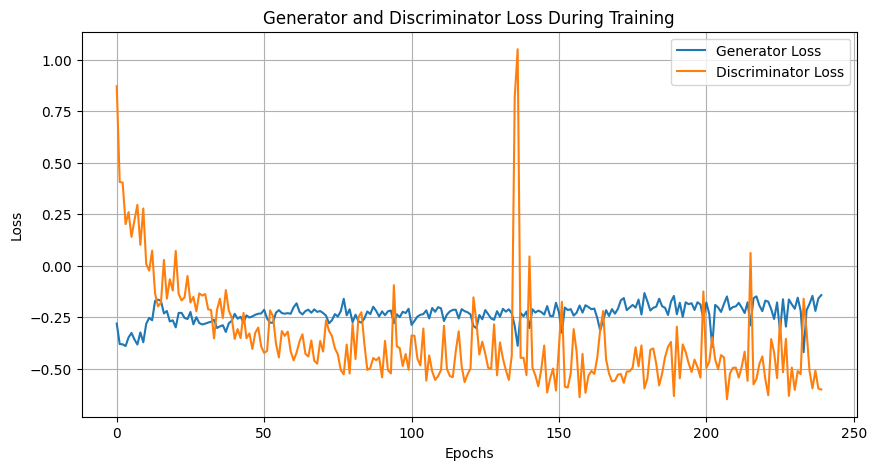

Training finished.


In [7]:
import torch
import torch.optim as optim
import glob
from torch.utils.tensorboard import SummaryWriter
import numpy as np
import os
import matplotlib.pyplot as plt
from tqdm import tqdm  # Import tqdm for progress bars

torch.cuda.empty_cache()

# Set device (use GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = torch.device( "cpu")

# Hyperparameters
lr = 0.0002             # Learning rate
lr_2 = 0.0001
beta1 = 0.5             # Beta1 for Adam optimizer
batch_size = 64         # Batch size
epochs = 350   # Number of epochs
latent_dim = 100        # Dimension of latent vector (noise)
image_size = 64         # Image size (64x64)
condition_dim = 128     # Dimension of compressed text embeddings (to match your previous setup)

# Directory to save generated images
output_dir = 'generated_images'
os.makedirs(output_dir, exist_ok=True)
os.makedirs('weights', exist_ok=True)

# Clear previous checkpoints
for checkpoint in glob.glob(os.path.join(output_dir, 'generator_epoch_*.pth')):
    os.remove(checkpoint)
for checkpoint in glob.glob(os.path.join(output_dir, 'discriminator_epoch_*.pth')):
    os.remove(checkpoint)

# TensorBoard writer
writer = SummaryWriter('runs/GAN_training')

# Define utility functions
def save_rgb_img(img, path):
    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)
    if isinstance(img, torch.Tensor):
        img = img.detach().permute(1, 2, 0).cpu().numpy()  # Convert CHW to HWC and move to CPU
    ax.imshow(img)
    ax.axis("off")
    ax.set_title("Generated Image")
    plt.savefig(path)
    plt.close()

def write_log(writer, name, loss, global_step):
    writer.add_scalar(name, loss, global_step)

# Models
gen_model = Stage1Generator().to(device)
dis_model = Stage1Discriminator().to(device)

# Optimizers
gen_optimizer = optim.Adam(gen_model.parameters(), lr=0.00001, betas=(beta1, 0.999))
dis_optimizer = optim.Adam(dis_model.parameters(), lr=0.00005, betas=(beta1, 0.999))

gen_scheduler = lr_scheduler.ReduceLROnPlateau(gen_optimizer, mode='min', factor=0.5, patience=10, verbose=True)
dis_scheduler = lr_scheduler.ReduceLROnPlateau(dis_optimizer, mode='min', factor=0.5, patience=10, verbose=True)

# Loss function
adversarial_loss = torch.nn.BCELoss()

# Labels for real and fake images
real_label = 1.0
fake_label = 0.0

save_interval = 10
image_save_interval = 10

# Load the resized images and their corresponding embeddings
train_images = torch.load('/kaggle/input/qwerty-3/image_tensors.pt_2')# Load resized images as tensors (batch_size, 3, 64, 64)
train_embeddings = torch.load('/kaggle/input/qwerty-3/text_embeddings')
train_embeddings = torch.stack(train_embeddings).to(device)


global_step = 0  # For logging steps

# Lists to store generator and discriminator losses for plotting
gen_losses = []
dis_losses = []

lambda_gp = 10  # Coefficient for gradient penalty

for epoch in tqdm(range(epochs), desc="Epochs"):
    gen_epoch_loss = 0
    dis_epoch_loss = 0
    num_batches = len(train_images) // batch_size

    for i in range(0, len(train_images), batch_size):
        real_images = train_images[i:i+batch_size].to(device)
        real_embeddings = train_embeddings[i:i+batch_size].to(device)
        batch_size = real_images.size(0)

        ############################
        # (1) Update Discriminator
        ###########################
        dis_model.zero_grad()

        # Generate fake images
        noise = torch.randn(batch_size, latent_dim, device=device)
        fake_images, mean_logsigma = gen_model(real_embeddings, noise)

        # Get discriminator outputs
        real_output = dis_model(real_images, real_embeddings).view(-1)
        fake_output = dis_model(fake_images.detach(), real_embeddings).view(-1)

        # Compute Wasserstein loss
        dis_loss = wasserstein_discriminator_loss(real_output, fake_output)

        # Compute gradient penalty
        gradient_penalty = compute_gradient_penalty(dis_model, real_images, fake_images, real_embeddings)
        dis_loss += lambda_gp * gradient_penalty  # Add gradient penalty to discriminator loss

        dis_loss.backward()
        dis_optimizer.step()

        ############################
        # (2) Update Generator
        ###########################
        gen_model.zero_grad()

        # Generate fake images and get critic output
        fake_images, mean_logsigma = gen_model(real_embeddings, noise)
        fake_output_gen = dis_model(fake_images, real_embeddings).view(-1)

        # Compute Wasserstein generator loss
        gen_loss = wasserstein_generator_loss(fake_output_gen)

        # Add KL loss (optional, if used in your architecture)
        kl_loss = KL_loss(mean_logsigma)
        total_gen_loss = gen_loss + kl_loss

        total_gen_loss.backward()
        gen_optimizer.step()
        
        global_step += 1
        write_log(writer, 'Discriminator Loss', dis_loss.item(), global_step)
        write_log(writer, 'Generator Loss', total_gen_loss.item(), global_step)

        # Print losses and save checkpoints
        if i % 50 == 0:
            print(f'Epoch [{epoch}/{epochs}] Step [{i}] Discriminator Loss: {dis_loss.item()} Generator Loss: {total_gen_loss.item()}')

            # Save generated images
            if i % 100 == 0:
                img_path = os.path.join(output_dir, f'generated_img_epoch_{epoch}_step_{i}.png')
                save_rgb_img(fake_images[0], img_path)  # Save first image in batch

        # Accumulate epoch losses
        dis_epoch_loss += dis_loss.item()
        gen_epoch_loss += total_gen_loss.item()

    # Store the average loss for each epoch
    dis_losses.append(dis_epoch_loss / num_batches)
    gen_losses.append(gen_epoch_loss / num_batches)
    
    avg_dis_losses = dis_losses[-1]
    avg_gen_losses = gen_losses[-1]
    
    gen_scheduler.step(avg_gen_loss)  
    dis_scheduler.step(avg_dis_loss)  
    
    if epoch % save_interval == 0:
        torch.save(gen_model.state_dict(), f'weights/generator_epoch_{epoch}.pth')
        torch.save(dis_model.state_dict(), f'weights/discriminator_epoch_{epoch}.pth')
    # Print average losses per epoch
    print(f'Epoch [{epoch}/{epochs}] Avg Discriminator Loss: {avg_dis_losses} Avg Generator Loss: {avg_gen_losses}')
    
    if epoch % image_save_interval == 0:
        img_path = os.path.join(output_dir, f'generated_img_epoch_{epoch}.png')
        save_rgb_img(fake_images[0], img_path)  # Save the first image in the batch for visualization
        
        # Plot generated images
        plot_generated_images(fake_images, epoch)  # Plot a few generated images from the batch

    
print('jaqnvi')    

    

torch.save(gen_model.state_dict(), "weights/stage1_gen_final.pth")
torch.save(dis_model.state_dict(), "weights/stage1_dis_final.pth")


# Plot the losses after training
plt.figure(figsize=(10, 5))
plt.plot(range(epochs), gen_losses, label='Generator Loss')
plt.plot(range(epochs), dis_losses, label='Discriminator Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Generator and Discriminator Loss During Training')
plt.legend()
plt.grid()
plt.show()

print("Training finished.")



/tmp/ipykernel_30/3026197346.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  gen_model.load_state_dict(torch.load('generator_epoch_19.pth'))  # Load the final epoch mode

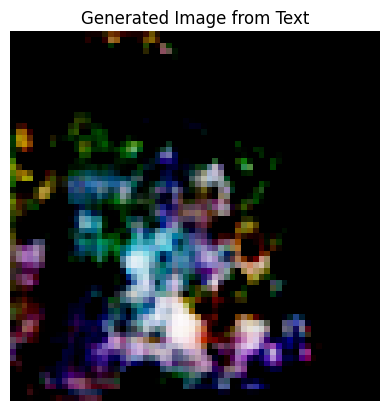

Image generation based on text complete.


In [11]:
import torch
import matplotlib.pyplot as plt
import os
from transformers import BertTokenizer, BertModel

# Load the trained generator model
gen_model = Stage1Generator().to(device)
gen_model.load_state_dict(torch.load('generator_epoch_19.pth'))  # Load the final epoch model
gen_model.eval()  # Set the model to evaluation mode

# Function to generate image from text embedding
def generate_image_from_text(text_embedding, save_path):
    # Convert the text embedding to tensor and send it to device
    text_embedding = torch.tensor(text_embedding).unsqueeze(0).to(device)  # Add batch dimension

    # Generate random noise (latent vector)
    noise = torch.randn(1, latent_dim, device=device)  # Single noise vector for 1 image

    # Generate the image using the generator
    with torch.no_grad():
        generated_image, _ = gen_model(text_embedding, noise)  # Pass the embedding and noise to generator

    # Function to save and show the image
    save_and_show_image(generated_image[0], save_path)

# Function to save and display the generated image
def save_and_show_image(img, path):
    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)
    if isinstance(img, torch.Tensor):
        img = img.detach().permute(1, 2, 0).cpu().numpy()  # Convert CHW to HWC and move to CPU
    ax.imshow(img)
    ax.axis("off")
    ax.set_title("Generated Image from Text")
    
    # Save image
    plt.savefig(path)
    
    # Show image
    plt.show()
    
    # Close plot to avoid memory issues
    plt.close()

# Example: Assuming you have a function to convert text into embeddings (e.g., using a pre-trained model)
def text_to_embedding(text):
    # Dummy embedding for demonstration, replace this with your actual text embedding process
    tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
    model = BertModel.from_pretrained('bert-base-uncased')
    inputs = tokenizer(text, return_tensors='pt', padding=True, truncation=True, max_length=128)
    
    with torch.no_grad():
                outputs = model(**inputs)

            # Extract the [CLS] token embedding (for the whole sentence)
    cls_embedding = outputs.last_hidden_state[:, 0, :]
    
    return cls_embedding

# Generate an image based on text
text_description = "white lily"
text_embedding = text_to_embedding(text_description)

# Directory to save generated image
output_dir = 'text_generated_images'
os.makedirs(output_dir, exist_ok=True)

# Generate and save the image based on the text
img_save_path = os.path.join(output_dir, 'generated_img_from_text.png')
generate_image_from_text(text_embedding, img_save_path)

print("Image generation based on text complete.")
